<a href="https://colab.research.google.com/github/AndryJunianto-code/Systematic-Benchmarking-Mental-Health/blob/main/Final_Loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import & Hierarchy Metric

In [ ]:
!pip -q install gensim==4.3.3 xgboost==2.1.4 lightgbm==4.5.0 emoji==2.12.1 unidecode==1.3.8 imblearn scipy imbalanced-learn tensorflow scikit-posthocs openpyxl matplotlib numpy seaborn



In [ ]:
import os
import re
import gc
import math
import json
import zipfile
import warnings
import pickle
import joblib
import random
import time
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
from unidecode import unidecode
import emoji
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import TruncatedSVD
from sklearn.base import clone, BaseEstimator, ClassifierMixin
from sklearn.ensemble import BaggingClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding, LSTM, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

import gensim
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess
from gensim.scripts.glove2word2vec import glove2word2vec

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

import scipy.sparse
from scipy.stats import friedmanchisquare, stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import defaultdict

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import pkg_resources
from symspellpy import SymSpell, Verbosity

from google.colab import drive

drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Mounted at /content/drive


In [ ]:
# Define the complete hierarchy tree with all ancestors
hierarchy_tree = {
    'Root': [],

    'Normal': ['Root'],
    'Internal': ['Root'],
    'External': ['Root'],

    'Anxiety': ['Internal', 'Root'],
    'Depression': ['Internal', 'Root'],
    'Stress': ['Internal', 'Root'],
    'Suicidal': ['Internal', 'Root'],

    'Bipolar': ['External', 'Root'],
    'Personality disorder': ['External', 'Root']
}

le = pickle.load(open('/content/drive/MyDrive/Skripsi Dataset/File/status_label_encoder.pkl','rb'))
labels = le['classes']

# For each leaf class, define its complete ancestor set (including itself)
def get_complete_ancestors(class_name):
    """Get all ancestors including the class itself"""
    return [class_name] + hierarchy_tree[class_name]

# Store complete ancestor sets for each class
ancestor_sets = {}
for class_name in labels:
    ancestor_sets[class_name] = get_complete_ancestors(class_name)

# Hierarchical Formula
def hierarchical_metrics_journal(y_true, y_pred, labels, ancestor_sets):
    """
    Implement the exact formula from the journal:
    hP = ∑|Anc_i ∩ Anĉ_i| / ∑|Anĉ_i|
    hR = ∑|Anc_i ∩ Anĉ_i| / ∑|Anc_i|
    hF1 = 2 * hP * hR / (hP + hR)
    """

    total_intersection = 0
    total_predicted_ancestors = 0
    total_true_ancestors = 0

    for true_idx, pred_idx in zip(y_true, y_pred):
        true_label = labels[true_idx]
        pred_label = labels[pred_idx]

        # Get ancestor sets
        true_ancestors = set(ancestor_sets[true_label])
        pred_ancestors = set(ancestor_sets[pred_label])

        intersection = true_ancestors.intersection(pred_ancestors)

        total_intersection += len(intersection)
        total_predicted_ancestors += len(pred_ancestors)
        total_true_ancestors += len(true_ancestors)

    # Calculate hierarchical precision and recall
    if total_predicted_ancestors > 0:
        hP = total_intersection / total_predicted_ancestors
    else:
        hP = 0.0

    if total_true_ancestors > 0:
        hR = total_intersection / total_true_ancestors
    else:
        hR = 0.0

    # Calculate hierarchical F1
    if hP + hR > 0:
        hF1 = 2 * hP * hR / (hP + hR)
    else:
        hF1 = 0.0

    return hF1, hP, hR, total_intersection, total_predicted_ancestors, total_true_ancestors

In [ ]:
def set_global_random_seed(seed=42):
    """Set all random seeds for complete reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    set_config(assume_finite=True, working_memory=256)
    print(f"All random seeds set to: {seed}")

set_global_random_seed(42)

All random seeds set to: 42


# Data Cleaning, Split & Embedding

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Skripsi Dataset/Combined Data.csv")
print(df['status'].value_counts())

df.dropna(inplace = True)
df['statement'] = df['statement'].astype(str)

def clean_text(text, lemmatizer):
    # Step 1: Basic text cleaning
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', ' ', text)
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()


    # Tokenization
    tokens = word_tokenize(text)

    # Lemmatization
    filtered_tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if len(word) > 2
    ]

    return ' '.join(filtered_tokens)

lemmatizer = WordNetLemmatizer()

# Apply cleaning
tqdm.pandas()
df['statement_cleaned'] = df['statement'].progress_apply(
    lambda x: clean_text(x, lemmatizer)
)

print("Text cleaning completed!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
status
Normal                  16351
Depression              15404
Suicidal                10652
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


  0%|          | 0/52680 [00:00<?, ?it/s]

Text cleaning completed!


In [ ]:
# label encoding
le = LabelEncoder()
df['status_label'] = le.fit_transform(df['status'])
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_map)
with open('/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl','wb') as f:
    pickle.dump({'classes':list(le.classes_)}, f)

Label mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


In [ ]:
# Super-class 1: Internal (Anxiety, Depression, Stress, Suicidal)
# Super-class 2: External (Bipolar, Personality Disorder)
# Super-class 3: Normal
df['super_class'] = df['status'].apply(lambda x: 'Internal' if x in ['Anxiety','Depression','Stress','Suicidal']
                                                     else ('External' if x in ['Bipolar','Personality disorder'] else 'Normal'))
# Encode super_class
le_super = LabelEncoder()
df['super_label'] = le_super.fit_transform(df['super_class'])
with open('/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl','wb') as f:
    pickle.dump({'classes':list(le_super.classes_)}, f)
print("Super class mapping:", dict(zip(le_super.classes_, le_super.transform(le_super.classes_))))

# train/test split stratified by original label
X = df['statement_cleaned'].values
y = df['status_label'].values
y_super = df['super_label'].values

X_train_statement, X_test_statement, y_train, y_test, y_super_train, y_super_test = train_test_split(
    X, y, y_super, test_size=0.2, random_state=42, stratify=y)

joblib.dump(X_train_statement, '/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_statement.pkl')
joblib.dump(X_test_statement, '/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_test_statement.pkl')
joblib.dump(y_train, '/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
joblib.dump(y_test, '/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_test.pkl')
joblib.dump(y_super_train, '/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
joblib.dump(y_super_test, '/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_test.pkl')

print("Train size:", len(X_train_statement), "Test size:", len(X_test_statement))

Super class mapping: {'External': 0, 'Internal': 1, 'Normal': 2}
Train size: 42144 Test size: 10536


In [ ]:
# FastText
X_train_statement = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_statement.pkl')
X_test_statement = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_test_statement.pkl')

# Convert to lists if they are numpy arrays
if hasattr(X_train_statement, 'shape'):
    X_train_statement = X_train_statement.tolist()
if hasattr(X_test_statement, 'shape'):
    X_test_statement = X_test_statement.tolist()

# Tokenise training set only
print(f"Training samples : {len(X_train_statement)}")
print(f"Test samples     : {len(X_test_statement)}")

sentences_train = [simple_preprocess(str(s)) for s in X_train_statement]
sentences_test  = [simple_preprocess(str(s)) for s in X_test_statement]


# Train FastText on training set only
print("\nTraining FastText on TRAIN split only ...")
fasttext_model = gensim.models.FastText(
    sentences=sentences_train,      # <-- TRAIN ONLY
    vector_size=100,
    window=5,
    min_count=2,
    epochs=10,
    sg=1,
    seed=42,
    workers=1
)

# Sentence-vector helper
def sent_vector(model, tokens):
    vecs = [model.wv[w] for w in tokens]      # sub-word fallback → no OOV error
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

# Create sentence vectors
print("\nCreating sentence vectors ...")
X_train_fast = np.vstack([sent_vector(fasttext_model, s) for s in sentences_train])
X_test_fast  = np.vstack([sent_vector(fasttext_model, s) for s in sentences_test])

# Save the sentence-level vectors
np.save('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy', X_train_fast)
np.save('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_test_fasttext.npy', X_test_fast)
fasttext_model.save('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_model.model')

print("FastText sentence vectors shapes:", X_train_fast.shape, X_test_fast.shape)

# Tokenizer
print("\nTraining Tokenizer on TRAIN split only ...")
tokenizer = Tokenizer()                     # no oov_token needed – FastText handles OOV
tokenizer.fit_on_texts([' '.join(tok) for tok in sentences_train])   # <-- TRAIN ONLY

# Convert to sequences of word indices
X_train_sequences = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in sentences_train])
X_test_sequences = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in sentences_test])

# Calculate max sequence length based on train
train_lengths = [len(seq) for seq in X_train_sequences]
max_sequence_length = int(np.percentile(train_lengths, 95))
print(f"Max sequence length (95th percentile): {max_sequence_length}")

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100

print(f"Creating embedding matrix with vocabulary size: {vocab_size}")

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = fasttext_model.wv[word]

print(f"Vocabulary size: {vocab_size}")
print(f"Padded sequences shape - Train: {X_train_padded.shape}, Test: {X_test_padded.shape}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")

# Verify OOV handling works
print("\nTesting OOV handling:")
test_words = ["unknownword123", "runningly", "unhappiness"]  # Words that probably don't exist
for word in test_words:
    try:
        vector = fasttext_model.wv[word]
        print(f"✓ '{word}' has vector (OOV handling works!)")
    except:
        print(f"✗ '{word}' not in vocabulary")

# Save the word-level data for GRU
np.save('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy', X_train_padded)
np.save('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_test_fasttext_sequences.npy', X_test_padded)
np.save('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy', embedding_matrix)
joblib.dump(tokenizer, '/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_tokenizer.pkl')

print("\nProcessing completed successfully!")

Training samples : 42144
Test samples     : 10536

Training FastText on TRAIN split only ...

Creating sentence vectors ...
FastText sentence vectors shapes: (42144, 100) (10536, 100)

Training Tokenizer on TRAIN split only ...
Max sequence length (95th percentile): 282
Creating embedding matrix with vocabulary size: 43899
Vocabulary size: 43899
Padded sequences shape - Train: (42144, 282), Test: (10536, 282)
Embedding matrix shape: (43899, 100)

Testing OOV handling:
✓ 'unknownword123' has vector (OOV handling works!)
✓ 'runningly' has vector (OOV handling works!)
✓ 'unhappiness' has vector (OOV handling works!)

Processing completed successfully!


In [ ]:
# word2vec
DRIVE_PATH = '/content/drive/MyDrive/Skripsi Dataset/FinalFile/'
EMBEDDING_DIM = 100
W2V_PARAMS = {
    'vector_size': EMBEDDING_DIM,
    'window': 5,
    'min_count': 2,
    'epochs': 10,
    'sg': 1,
    'seed': 42,
    'workers': 1
}
OOV_INIT_SCALE = 0.01
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Load Data ---
X_train_statement = joblib.load(os.path.join(DRIVE_PATH, 'X_train_statement.pkl'))
X_test_statement = joblib.load(os.path.join(DRIVE_PATH, 'X_test_statement.pkl'))

# Convert to lists
X_train_statement = X_train_statement.tolist()
X_test_statement = X_test_statement.tolist()

# Tokenize Data
print("Tokenizing data...")
sentences_train = [simple_preprocess(str(s)) for s in X_train_statement]

# Train Word2Vec
print("Training Word2Vec on training set...")
word2vec_model = gensim.models.Word2Vec(
    sentences=sentences_train,
    **W2V_PARAMS
)
word2vec_model.save(os.path.join(DRIVE_PATH, 'w2v_model.model'))

def sent_vector_w2v(model, tokens):
    """
    Averages word vectors, skipping OOV words.
    Word2Vec throws an error for OOV, unlike FastText.
    """
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

# Create sentence vectors
print("\nCreating sentence vectors...")
X_train_w2v = np.vstack([sent_vector_w2v(word2vec_model, s) for s in sentences_train])
X_test_w2v = np.vstack([sent_vector_w2v(word2vec_model, s) for s in sentences_test])

# Save the sentence level vectors
np.save(os.path.join(DRIVE_PATH, 'X_train_w2v.npy'), X_train_w2v)
np.save(os.path.join(DRIVE_PATH, 'X_test_w2v.npy'), X_test_w2v)
print(f"Word2Vec sentence vectors shapes: {X_train_w2v.shape} {X_test_w2v.shape}")

print("\nTraining tokenizer with UNK token on training set...")
tokenizer = Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts([' '.join(tok) for tok in sentences_train]) # <-- ENTIRE DATASET

# Convert train/test splits to sequences
X_train_sequences = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in sentences_train])
X_test_sequences = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in sentences_test])

# Calculate max sequence length
all_sequences = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in sentences_train])
all_lengths = [len(seq) for seq in all_sequences]
max_sequence_length = int(np.percentile(all_lengths, 95))
print(f"Max sequence length (95th percentile): {max_sequence_length}")

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Create Embedding Matrix
vocab_size = len(tokenizer.word_index) + 1
print(f"Creating embedding matrix with vocabulary size: {vocab_size}")
print(f"UNK token ID: {tokenizer.word_index['<UNK>']}")

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
oov_count = 0
known_count = 0
oov_vectors = {}

print(f"Using random initialization for OOV words (scale={OOV_INIT_SCALE})")

# Handle the <UNK> token
unk_token_index = tokenizer.word_index['<UNK>']
unk_vector = np.random.normal(0, OOV_INIT_SCALE, size=EMBEDDING_DIM)
embedding_matrix[unk_token_index] = unk_vector
print(f"UNK vector example (first 5 dims): {unk_vector[:5]}")

# Handle all other words
for word, i in tokenizer.word_index.items():
    if i == unk_token_index:
        continue

    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
        known_count += 1
    else:
        # Assign a unique, consistent random vector for reproducibility
        if word not in oov_vectors:
            oov_vectors[word] = np.random.normal(0, OOV_INIT_SCALE, size=EMBEDDING_DIM)
        embedding_matrix[i] = oov_vectors[word]
        oov_count += 1

# OOV Analysis
print("\n=== OOV Analysis ===")
total_vocab_words = len(tokenizer.word_index) - 1 # Exclude <UNK>
print(f"Total vocabulary: {total_vocab_words} words")
print(f"Known by Word2Vec: {known_count} words ({known_count/total_vocab_words*100:.2f}%)")
print(f"OOV words: {oov_count} words ({oov_count/total_vocab_words*100:.2f}%)")
print(f"OOV strategy: Each of {oov_count} OOV words gets unique random vector")

# Save sequence data
np.save(os.path.join(DRIVE_PATH, 'w2v_embedding_matrix.npy'), embedding_matrix)
np.save(os.path.join(DRIVE_PATH, 'X_train_w2v_sequences.npy'), X_train_padded)
np.save(os.path.join(DRIVE_PATH, 'X_test_w2v_sequences.npy'), X_test_padded)
joblib.dump(tokenizer, os.path.join(DRIVE_PATH, 'w2v_tokenizer.pkl'))

print("\nProcessing completed successfully!")

print("\n=== Environment Info (Include in Thesis Appendix) ===")
print(f"OOV initialization: random normal (mean=0, std={OOV_INIT_SCALE})")
print(f"Word2Vec min_count: {W2V_PARAMS['min_count']}")
print(f"Embedding dimensions: {EMBEDDING_DIM}")

Total samples: 52680
Tokenizing data...
Training Word2Vec on entire dataset...
Creating sentence vectors...
Word2Vec sentence vectors shapes: (42144, 100) (10536, 100)
Training tokenizer with UNK token on entire dataset...
Max sequence length (95th percentile): 281
Creating embedding matrix with vocabulary size: 49137
UNK token ID: 1
Using random initialization for OOV words (scale=0.01)
UNK vector example (first 5 dims): [ 0.00496714 -0.00138264  0.00647689  0.0152303  -0.00234153]

=== OOV Analysis ===
Total vocabulary: 49136 words
Known by Word2Vec: 24452 words (49.76%)
OOV words: 24684 words (50.24%)
OOV strategy: Each of 24684 OOV words gets unique random vector

Processing completed successfully!

=== Environment Info (Include in Thesis Appendix) ===
OOV initialization: random normal (mean=0, std=0.01)
Word2Vec min_count: 2
Embedding dimensions: 100


In [ ]:
#TF-IDF

X_train_statement = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_statement.pkl')
X_test_statement = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_test_statement.pkl')

tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_statement)
X_test_tfidf = tfidf.transform(X_test_statement)

scipy.sparse.save_npz('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_tfidf.npz', X_train_tfidf)
scipy.sparse.save_npz('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_test_tfidf.npz', X_test_tfidf)
joblib.dump(tfidf, '/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_vectorizer.pkl')

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

train_vocab = set(tfidf.get_feature_names_out())
test_words = set()
for doc in X_test_statement:
    test_words.update(doc.split())
oov_rate = len(test_words - train_vocab) / len(test_words) if test_words else 0
print(f"OOV rate in test set: {oov_rate:.2%}")

TF-IDF shapes: (42144, 1000) (10536, 1000)
OOV rate in test set: 95.91%


# FastText Loop

In [ ]:
# FLAT FASTTEXT ML
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define machine learning models to test
ml_models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# Initialize results storage
all_results = []

# =============================================================================
# MACHINE LEARNING MODELS LOOP
# =============================================================================
for model_name, model_class in ml_models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this model
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
        fold_idx += 1
        X_tr = X_train_fasttext[train_idx]
        X_val = X_train_fasttext[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        model = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42)),
            ('clf', clone(model_class))
        ])

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-FastText-{model_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time
    # Calculate and save final averages for this model
    all_results.append({
        'Model': f'Flat-FastText-{model_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-FastText-{model_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{model_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training LogisticRegression
Fold 1 done. MacroF1=0.5510, WeightedF1=0.6229, HierF1=0.8012
Fold 2 done. MacroF1=0.5433, WeightedF1=0.6195, HierF1=0.7986
Fold 3 done. MacroF1=0.5312, WeightedF1=0.6035, HierF1=0.7908


KeyboardInterrupt: 

In [ ]:
# FLAT GRU
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# =============================================================================
# GRU IMPLEMENTATION
# =============================================================================
print(f"\n{'='*60}")
print(f"Training GRU - FAIR COMPARISON")
print(f"{'='*60}")

# Start timing for GRU
model_start_time = time.time()

# Metrics containers for GRU
p_macros=[]; r_macros=[]; f1_macros=[]
p_weights=[]; r_weights=[]; f1_weights=[]
hF1s=[]; hPs=[]; hRs = []
all_y_true = []; all_y_pred = []

fold_idx = 0
for train_idx, val_idx in skf.split(X_train_sequences, y_train):
    fold_idx += 1

    # Get the data splits
    X_tr_seq = X_train_sequences[train_idx]
    X_val_seq = X_train_sequences[val_idx]
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]

    # RESAMPLE PIPE
    resample_pipe = ImbPipeline([
        ('ros', RandomOverSampler(random_state=42)),
        ('rus', RandomUnderSampler(random_state=42))
    ])
    X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

    y_tr_cat = tf.keras.utils.to_categorical(y_tr_hybrid, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_sequence_length,
            trainable=False
        ),
        GRU(64),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(
        X_tr_hybrid, y_tr_cat,
        validation_data=(X_val_seq, y_val_cat),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0,
    )

    y_pred = np.argmax(model.predict(X_val_seq, verbose=0), axis=1)

    p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
    r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
    p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
    r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
    hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

    # Store fold results
    p_macros.append(p_macro)
    r_macros.append(r_macro)
    f1_macros.append(f1_macro)
    p_weights.append(p_weighted)
    r_weights.append(r_weighted)
    f1_weights.append(f1_weighted)
    hF1s.append(hF1)
    hPs.append(hP)
    hRs.append(hR)

    all_y_true.extend(list(y_val))
    all_y_pred.extend(list(y_pred))

    # Save individual fold result
    all_results.append({
            'Model': f'Flat-FastText-GRU-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

    print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

model_total_time = time.time() - model_start_time
# Calculate and save final averages for this model
all_results.append({
        'Model': f'Flat-FastText-GRU-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

all_results.append({
        'Model': f'Flat-FastText-GRU-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

print(f"\nGRU Final Results:")
print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
print(f"Total Training Time: {model_total_time:.2f} seconds")


Training GRU - FAIR COMPARISON
Fold 1 done. MacroF1=0.7296, WeightedF1=0.7508, HierF1=0.8898
Fold 2 done. MacroF1=0.6995, WeightedF1=0.7477, HierF1=0.8810
Fold 3 done. MacroF1=0.6887, WeightedF1=0.7234, HierF1=0.8700
Fold 4 done. MacroF1=0.6890, WeightedF1=0.7332, HierF1=0.8753
Fold 5 done. MacroF1=0.7035, WeightedF1=0.7451, HierF1=0.8808

GRU Final Results:
Macro F1: 0.7021 ± 0.0149
Weighted F1: 0.7400 ± 0.0102
Hierarchical F1: 0.8794 ± 0.0066
Total Training Time: 16220.30 seconds


In [ ]:
# HARD VOTING ENSEMBLES
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# voting ensembles
voting_ensembles = {
    'HardVoting-XGBoost-GRU-LightGBM': ['XGBoost', 'GRU', 'LightGBM'],
    'HardVoting-XGBoost-GRU-RandomForest': ['XGBoost', 'GRU', 'RandomForest']
}

# =============================================================================
# HARD VOTING ENSEMBLES LOOP
# =============================================================================
for ensemble_name, model_names in voting_ensembles.items():
    print(f"\n{'='*60}")
    print(f"Training {ensemble_name}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
        fold_idx += 1

        # Get data splits
        X_tr_ft = X_train_fasttext[train_idx]
        X_val_ft = X_train_fasttext[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        # Apply resampling to FastText
        X_tr_ft_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_ft, y_tr)
        # Apply resampling to sequences
        X_tr_seq_hybrid, _ = resample_pipe.fit_resample(X_tr_seq, y_tr)

        # Store predictions from each model
        fold_predictions = []

        # Train each model in the ensemble
        for model_name in model_names:
            if model_name == 'GRU':
                # GRU Model
                y_tr_cat = tf.keras.utils.to_categorical(y_tr_hybrid, num_classes)
                y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

                gru_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_classes, activation='softmax')
                ])

                gru_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                gru_model.fit(
                    X_tr_seq_hybrid, y_tr_cat,
                    validation_data=(X_val_seq, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                    verbose=0,
                )

                y_pred_gru = np.argmax(gru_model.predict(X_val_seq, verbose=0), axis=1)
                fold_predictions.append(y_pred_gru)

            else:
                # ML Models
                if model_name == 'XGBoost':
                    model = XGBClassifier(random_state=42)
                elif model_name == 'LightGBM':
                    model = LGBMClassifier(random_state=42)
                elif model_name == 'RandomForest':
                    model = RandomForestClassifier(random_state=42)

                model.fit(X_tr_ft_hybrid, y_tr_hybrid)
                y_pred_ml = model.predict(X_val_ft)
                fold_predictions.append(y_pred_ml)

        # Hard Voting: majority vote
        fold_predictions = np.array(fold_predictions)
        y_pred_vote = []

        for i in range(len(y_val)):
            votes = fold_predictions[:, i]
            unique, counts = np.unique(votes, return_counts=True)
            max_count = np.max(counts)
            if np.sum(counts == max_count) > 1:
                y_pred_vote.append(votes[0])  # Tie → use first model (XGBoost)
            else:
                y_pred_vote.append(unique[np.argmax(counts)])

        y_pred = np.array(y_pred_vote)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-FastText-{ensemble_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': f'Flat-FastText-{ensemble_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-FastText-{ensemble_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{ensemble_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training HardVoting-XGBoost-GRU-LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 73213, number of used features: 100
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Fold 1 done. MacroF1=0.6971, WeightedF1=0.7386, HierF1=0.8787
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of da

In [ ]:
# WEIGHTED SOFT VOTING ENSEMBLES
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# Define weighted soft voting ensembles with performance-based weights
weighted_ensembles = {
    'WeightedSoft-XGBoost-GRU-LightGBM': {
        'models': ['XGBoost', 'GRU', 'LightGBM'],
        'weights': [0.7195, 0.7292, 0.7119]
    },
    'WeightedSoft-XGBoost-GRU-RandomForest': {
        'models': ['XGBoost', 'GRU', 'RandomForest'],
        'weights': [0.7195, 0.7292, 0.6844]
    }
}

# =============================================================================
# WEIGHTED SOFT VOTING ENSEMBLES LOOP
# =============================================================================
for ensemble_name, ensemble_config in weighted_ensembles.items():
    model_names = ensemble_config['models']
    performance_weights = ensemble_config['weights']

    # Normalize weights to sum to 1
    normalized_weights = np.array(performance_weights) / np.sum(performance_weights)

    print(f"\n{'='*60}")
    print(f"Training {ensemble_name}")
    print(f"Model Weights: {dict(zip(model_names, normalized_weights))}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
        fold_idx += 1

        # Get data splits
        X_tr_ft = X_train_fasttext[train_idx]
        X_val_ft = X_train_fasttext[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        # Apply resampling to FastText
        X_tr_ft_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_ft, y_tr)
        # Apply resampling to sequences
        X_tr_seq_hybrid, y_tr_seq_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

        # Store probability predictions from each model
        fold_probabilities = []

        # Train each model in the ensemble and get probabilities
        for i, model_name in enumerate(model_names):
            if model_name == 'GRU':
                # GRU Model - get probabilities
                y_tr_cat = tf.keras.utils.to_categorical(y_tr_seq_hybrid, num_classes)
                y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

                gru_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_classes, activation='softmax')
                ])

                gru_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                gru_model.fit(
                    X_tr_seq_hybrid, y_tr_cat,
                    validation_data=(X_val_seq, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                    verbose=0,
                )

                # Get probability predictions from GRU
                y_proba_gru = gru_model.predict(X_val_seq, verbose=0)
                fold_probabilities.append(y_proba_gru)

            else:
                # ML Models
                if model_name == 'XGBoost':
                    model = XGBClassifier(random_state=42)
                elif model_name == 'LightGBM':
                    model = LGBMClassifier(random_state=42)
                elif model_name == 'RandomForest':
                    model = RandomForestClassifier(random_state=42)

                model.fit(X_tr_ft_hybrid, y_tr_hybrid)
                y_proba_ml = model.predict_proba(X_val_ft)
                fold_probabilities.append(y_proba_ml)

        # Weighted Soft Voting: weighted average of probabilities
        weighted_probabilities = np.zeros_like(fold_probabilities[0])

        for i, proba in enumerate(fold_probabilities):
            # Apply normalized performance weight to each model's probabilities
            weighted_probabilities += normalized_weights[i] * proba

        # Get final predictions (class with highest weighted probability)
        y_pred = np.argmax(weighted_probabilities, axis=1)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-FastText-{ensemble_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': f'Flat-FastText-{ensemble_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-FastText-{ensemble_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{ensemble_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")
    print(f"Used Weights: {dict(zip(model_names, normalized_weights))}")


Training WeightedSoft-XGBoost-GRU-RandomForest
Model Weights: {'XGBoost': 0.33625349487418454, 'GRU': 0.3448275862068966, 'RandomForest': 0.31891891891891894}
Fold 1 done. MacroF1=0.7469, WeightedF1=0.7739, HierF1=0.8971
Fold 2 done. MacroF1=0.7312, WeightedF1=0.7644, HierF1=0.8930
Fold 3 done. MacroF1=0.7344, WeightedF1=0.7573, HierF1=0.8892
Fold 4 done. MacroF1=0.7265, WeightedF1=0.7588, HierF1=0.8892
Fold 5 done. MacroF1=0.7399, WeightedF1=0.7635, HierF1=0.8924

WeightedSoft-XGBoost-GRU-RandomForest Final Results:
Macro F1: 0.7358 ± 0.0070
Weighted F1: 0.7636 ± 0.0058
Hierarchical F1: 0.8922 ± 0.0029
Total Training Time: 18810.27 seconds
Used Weights: {'XGBoost': 0.33625349487418454, 'GRU': 0.3448275862068966, 'RandomForest': 0.31891891891891894}


In [ ]:
# STACKING ENSEMBLES
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# Define stacking ensembles
stacking_ensembles = {
    'Stacking-XGB-GRU-LGBM-LR': {
        'base_models': ['XGBoost', 'GRU', 'LightGBM'],
        'meta_model': LogisticRegression(random_state=42)
    },
    'Stacking-XGB-GRU-RF-LR': {
        'base_models': ['XGBoost', 'GRU', 'RandomForest'],
        'meta_model': LogisticRegression(random_state=42)
    }
}

# =============================================================================
# STACKING ENSEMBLES LOOP
# =============================================================================
for ensemble_name, ensemble_config in stacking_ensembles.items():
    base_model_names = ensemble_config['base_models']
    meta_model = ensemble_config['meta_model']

    print(f"\n{'='*60}")
    print(f"Training {ensemble_name}")
    print(f"Base Models: {base_model_names}")
    print(f"Meta Model: {type(meta_model).__name__}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Generate OOF Predictions
    print("Stage 1: Generating Out-of-Fold predictions...")

    # Initialize OOF arrays for base model predictions
    oof_predictions = {}
    for model_name in base_model_names:
        oof_predictions[model_name] = np.zeros((len(X_train_fasttext), num_classes))

    # Generate OOF predictions for each base model
    for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
        # Get data splits
        X_tr_ft = X_train_fasttext[train_idx]
        X_val_ft = X_train_fasttext[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

         # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        # Apply resampling to FastText
        X_tr_ft_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_ft, y_tr)
        # Apply resampling to sequences
        X_tr_seq_hybrid, y_tr_seq_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

        # Train each base model and get OOF predictions
        for model_name in base_model_names:
            if model_name == 'GRU':
                # GRU Model
                y_tr_cat = tf.keras.utils.to_categorical(y_tr_seq_hybrid, num_classes)
                y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

                gru_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_classes, activation='softmax')
                ])

                gru_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                gru_model.fit(
                    X_tr_seq_hybrid, y_tr_cat,
                    validation_data=(X_val_seq, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                    verbose=0,
                )

                # Get probability predictions for validation set
                y_proba_gru = gru_model.predict(X_val_seq, verbose=0)
                oof_predictions['GRU'][val_idx] = y_proba_gru

            else:
                # ML Models
                if model_name == 'XGBoost':
                    model = XGBClassifier(random_state=42)
                elif model_name == 'RandomForest':
                    model = RandomForestClassifier(random_state=42)
                elif model_name == 'LightGBM':
                    model = LGBMClassifier(random_state=42)
                elif model_name == 'SVM-rbf':
                    model = SVC(kernel='rbf', random_state=42, probability=True)

                model.fit(X_tr_ft_hybrid, y_tr_hybrid)

                # Get probability predictions for validation set
                if model_name == 'SVM-rbf':
                    y_proba_ml = model.predict_proba(X_val_ft)
                else:
                    y_proba_ml = model.predict_proba(X_val_ft)

                oof_predictions[model_name][val_idx] = y_proba_ml

    print("Stage 1 completed: OOF predictions generated for all base models")

    # Train and Evaluate Meta-Classifier
    print("Stage 2: Training and evaluating meta-classifier...")

    # Create meta-features dataset
    X_meta = np.hstack([oof_predictions[model_name] for model_name in base_model_names])

    # Metrics containers for stacking ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    # Cross-validation on meta-features
    for train_idx, val_idx in skf.split(X_meta, y_train):
        fold_idx += 1

        # Get meta-features splits
        X_tr_meta = X_meta[train_idx]
        X_val_meta = X_meta[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # === GOLD STANDARD: RESAMPLING FOR META-CLASSIFIER ===
        resample_pipe_meta = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        # Apply resampling to meta-features
        X_tr_meta_hybrid, y_tr_hybrid = resample_pipe_meta.fit_resample(X_tr_meta, y_tr)

        # Train meta-classifier
        meta_model_clone = clone(meta_model)
        meta_model_clone.fit(X_tr_meta_hybrid, y_tr_hybrid)

        # Predict with meta-classifier
        y_pred = meta_model_clone.predict(X_val_meta)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-FastText-{ensemble_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': f'Flat-FastText-{ensemble_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-FastText-{ensemble_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{ensemble_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")
    print(f"Base Models: {base_model_names}")
    print(f"Meta Model: {type(meta_model).__name__}")


Training Stacking-XGB-GRU-RF-LR-Andry
Base Models: ['XGBoost', 'GRU', 'RandomForest']
Meta Model: LogisticRegression
Stage 1: Generating Out-of-Fold predictions...
Stage 1 completed: OOF predictions generated for all base models
Stage 2: Training and evaluating meta-classifier...
Fold 1 done. MacroF1=0.6902, WeightedF1=0.7319, HierF1=0.8740
Fold 2 done. MacroF1=0.6816, WeightedF1=0.7337, HierF1=0.8743
Fold 3 done. MacroF1=0.6498, WeightedF1=0.7020, HierF1=0.8546
Fold 4 done. MacroF1=0.6574, WeightedF1=0.7204, HierF1=0.8596
Fold 5 done. MacroF1=0.6654, WeightedF1=0.7211, HierF1=0.8642

Stacking-XGB-GRU-RF-LR-Andry Final Results:
Macro F1: 0.6689 ± 0.0150
Weighted F1: 0.7218 ± 0.0113
Hierarchical F1: 0.8653 ± 0.0078
Total Training Time: 4427.52 seconds
Base Models: ['XGBoost', 'GRU', 'RandomForest']
Meta Model: LogisticRegression


In [ ]:
# recalibrate finding best model for each level lcpn
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

super_ancestor_sets = {
    'Internal': {'Internal', 'Root'},
    'External': {'External', 'Root'},
    'Normal': {'Normal', 'Root'}
}

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Get dimensions for GRU
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define all models
ml_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'GRU': 'gru_model'
}

# Performance tracking for all algorithms and levels
algorithm_performance = {}
all_results = []

# Initialize performance tracking for all algorithms
for algo_name in list(ml_models.keys()):
    algorithm_performance[algo_name] = {
        'root': {'macro_p': [], 'macro_r': [], 'macro_f1': [], 'weighted_p': [], 'weighted_r': [], 'weighted_f1': [], 'hF1': [], 'hP': [], 'hR': []},
        'internal': {'macro_p': [], 'macro_r': [], 'macro_f1': [], 'weighted_p': [], 'weighted_r': [], 'weighted_f1': [], 'hF1': [], 'hP': [], 'hR': []},
        'external': {'macro_p': [], 'macro_r': [], 'macro_f1': [], 'weighted_p': [], 'weighted_r': [], 'weighted_f1': [], 'hF1': [], 'hP': [], 'hR': []},
        'overall': {'macro_p': [], 'macro_r': [], 'macro_f1': [], 'weighted_p': [], 'weighted_r': [], 'weighted_f1': [], 'hF1': [], 'hP': [], 'hR': []}
    }

fold_no = 0
for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
    fold_no += 1
    print(f"\n---- Fold {fold_no} ----")

    # Split data
    X_tr = X_train_fasttext[train_idx]
    X_val = X_train_fasttext[val_idx]
    X_tr_seq = X_train_sequences[train_idx]
    X_val_seq = X_train_sequences[val_idx]

    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    y_super_tr = y_super_train[train_idx]
    y_super_val = y_super_train[val_idx]

    # Test each algorithm
    for algo_name in list(ml_models.keys()):
        print(f"\nTesting {algo_name}...")
        fold_start_time = time.time()

        # SINGLE RESAMPLE PIPE ===
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        if algo_name == 'GRU':
            # For GRU, use sequence data
            X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)
        else:
            # For ML models, use word2vec features
            X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)

        # Get corresponding super labels for the hybrid-sampled data
        y_super_tr_hybrid = []
        for leaf_label in y_tr_hybrid:
            super_label = leaf_to_super_name[leaf_label]
            super_idx = list(super_labels).index(super_label)
            y_super_tr_hybrid.append(super_idx)
        y_super_tr_hybrid = np.array(y_super_tr_hybrid)

        # =====================================================================
        # 1) Train ROOT level classifier
        # =====================================================================
        if algo_name == 'GRU':
            # GRU Root Model
            y_super_tr_hybrid_cat = tf.keras.utils.to_categorical(y_super_tr_hybrid, num_classes=len(super_labels))
            y_super_val_cat = tf.keras.utils.to_categorical(y_super_val, num_classes=len(super_labels))

            root_model = Sequential([
                Embedding(
                    input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False
                ),
                GRU(64),
                Dense(len(super_labels), activation='softmax')
            ])

            root_model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            root_model.fit(
                X_tr_hybrid, y_super_tr_hybrid_cat,
                validation_data=(X_val_seq, y_super_val_cat),
                epochs=50,
                batch_size=32,
                callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                verbose=0,
            )
        else:
            # ML Root Model
            root_model = clone(ml_models[algo_name])
            root_model.fit(X_tr_hybrid, y_super_tr_hybrid)

        # =====================================================================
        # 2) Train INTERNAL level classifier
        # =====================================================================
        internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
        if internal_mask_tr.sum() > 0:
            X_tr_internal = X_tr_hybrid[internal_mask_tr]
            y_tr_internal = y_tr_hybrid[internal_mask_tr]

            # Apply resampling to internal data
            resample_internal = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_internal_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal, y_tr_internal)

            if algo_name == 'GRU':
                # GRU Internal Model
                internal_label_encoder = LabelEncoder()
                y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
                num_internal_classes = len(np.unique(y_tr_internal_hybrid_encoded))
                y_tr_internal_cat = tf.keras.utils.to_categorical(y_tr_internal_hybrid_encoded, num_classes=num_internal_classes)

                # Get validation data for internal level
                internal_val_mask = (y_super_val == list(super_labels).index('Internal'))
                if internal_val_mask.sum() > 0:
                    X_val_internal = X_val_seq[internal_val_mask]
                    y_val_internal = y_val[internal_val_mask]
                    y_val_internal_encoded = internal_label_encoder.transform(y_val_internal)
                    y_val_internal_cat = tf.keras.utils.to_categorical(y_val_internal_encoded, num_classes=num_internal_classes)
                    validation_data = (X_val_internal, y_val_internal_cat)
                    monitor_metric = 'val_loss'
                else:
                    validation_data = None
                    monitor_metric = 'loss'

                internal_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_internal_classes, activation='softmax')
                ])

                internal_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                internal_model.fit(
                    X_tr_internal_hybrid, y_tr_internal_cat,
                    validation_data=validation_data,
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
                    verbose=0,
                )
            else:
                # ML Internal Model
                if algo_name in ['XGBoost', 'LightGBM']:
                    internal_label_encoder = LabelEncoder()
                    y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
                else:
                    internal_label_encoder = None
                    y_tr_internal_hybrid_encoded = y_tr_internal_hybrid

                internal_model = clone(ml_models[algo_name])
                internal_model.fit(X_tr_internal_hybrid, y_tr_internal_hybrid_encoded)
        else:
            print(f"  No internal samples for training")
            internal_model = None
            internal_label_encoder = None

        # =====================================================================
        # 3) Train EXTERNAL level classifier
        # =====================================================================
        external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
        if external_mask_tr.sum() > 0:
            X_tr_external = X_tr_hybrid[external_mask_tr]
            y_tr_external = y_tr_hybrid[external_mask_tr]

            # Apply resampling to external data
            resample_external = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_external_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external, y_tr_external)

            if algo_name == 'GRU':
                # GRU External Model
                external_label_encoder = LabelEncoder()
                y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)
                num_external_classes = len(np.unique(y_tr_external_hybrid_encoded))
                y_tr_external_cat = tf.keras.utils.to_categorical(y_tr_external_hybrid_encoded, num_classes=num_external_classes)

                # Get validation data for external level
                external_val_mask = (y_super_val == list(super_labels).index('External'))
                if external_val_mask.sum() > 0:
                    X_val_external = X_val_seq[external_val_mask]
                    y_val_external = y_val[external_val_mask]
                    y_val_external_encoded = external_label_encoder.transform(y_val_external)
                    y_val_external_cat = tf.keras.utils.to_categorical(y_val_external_encoded, num_classes=num_external_classes)
                    validation_data = (X_val_external, y_val_external_cat)
                    monitor_metric = 'val_loss'
                else:
                    validation_data = None
                    monitor_metric = 'loss'

                external_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_external_classes, activation='softmax')
                ])

                external_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                external_model.fit(
                    X_tr_external_hybrid, y_tr_external_cat,
                    validation_data=validation_data,
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
                    verbose=0,
                )
            else:
                # ML External Model
                if algo_name in ['XGBoost', 'LightGBM']:
                    external_label_encoder = LabelEncoder()
                    y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)
                else:
                    external_label_encoder = None
                    y_tr_external_hybrid_encoded = y_tr_external_hybrid

                external_model = clone(ml_models[algo_name])
                external_model.fit(X_tr_external_hybrid, y_tr_external_hybrid_encoded)
        else:
            print(f"  No external samples for training")
            external_model = None
            external_label_encoder = None

        # =====================================================================
        # 4) Hierarchical Prediction
        # =====================================================================
        if algo_name == 'GRU':
            # GRU Prediction
            y_super_val_pred_proba = root_model.predict(X_val_seq, verbose=0)
            y_super_val_pred = np.argmax(y_super_val_pred_proba, axis=1)
        else:
            # ML Prediction
            y_super_val_pred = root_model.predict(X_val)

        # Build final leaf predictions
        y_val_final_pred = np.zeros_like(y_super_val_pred)

        # Find normal leaf index
        normal_leaf_idx = None
        for idx, name in leaf_index_to_name.items():
            if name.lower() == 'normal' or name == 'Normal':
                normal_leaf_idx = idx
                break
        if normal_leaf_idx is None:
            normal_leaf_list = super_to_leaf_indices.get('Normal', [])
            normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

        # Apply hierarchical prediction logic
        for i in range(len(y_super_val_pred)):
            pred_sup = y_super_val_pred[i]

            if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                if algo_name == 'GRU':
                    single_sample = X_val_seq[i:i+1]
                    pred_proba = internal_model.predict(single_sample, verbose=0)
                    pred_encoded = np.argmax(pred_proba, axis=1)[0]
                    y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    single_sample = X_val[i].reshape(1, -1)
                    if algo_name in ['XGBoost', 'LightGBM'] and internal_label_encoder is not None:
                        pred_encoded = internal_model.predict(single_sample)[0]
                        y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]
                    else:
                        y_val_final_pred[i] = internal_model.predict(single_sample)[0]

            elif pred_sup == list(super_labels).index('External') and external_model is not None:
                if algo_name == 'GRU':
                    single_sample = X_val_seq[i:i+1]
                    pred_proba = external_model.predict(single_sample, verbose=0)
                    pred_encoded = np.argmax(pred_proba, axis=1)[0]
                    y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    single_sample = X_val[i].reshape(1, -1)
                    if algo_name in ['XGBoost', 'LightGBM'] and external_label_encoder is not None:
                        pred_encoded = external_model.predict(single_sample)[0]
                        y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                    else:
                        y_val_final_pred[i] = external_model.predict(single_sample)[0]

            else:  # Normal
                if normal_leaf_idx is not None:
                    y_val_final_pred[i] = normal_leaf_idx
                else:
                    vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                    y_val_final_pred[i] = vals[np.argmax(counts)]

        # =====================================================================
        # 5) Calculate Metrics for ALL LEVELS
        # =====================================================================
        fold_time = time.time() - fold_start_time

        # ROOT LEVEL METRICS
        root_macro_p = precision_score(y_super_val, y_super_val_pred, average='macro', zero_division=0)
        root_macro_r = recall_score(y_super_val, y_super_val_pred, average='macro', zero_division=0)
        root_macro_f1 = f1_score(y_super_val, y_super_val_pred, average='macro', zero_division=0)
        root_weighted_p = precision_score(y_super_val, y_super_val_pred, average='weighted', zero_division=0)
        root_weighted_r = recall_score(y_super_val, y_super_val_pred, average='weighted', zero_division=0)
        root_weighted_f1 = f1_score(y_super_val, y_super_val_pred, average='weighted', zero_division=0)
        root_hF1, root_hP, root_hR, _, _, _ = hierarchical_metrics_journal(y_super_val, y_super_val_pred, list(super_labels), super_ancestor_sets)

        algorithm_performance[algo_name]['root']['macro_p'].append(root_macro_p)
        algorithm_performance[algo_name]['root']['macro_r'].append(root_macro_r)
        algorithm_performance[algo_name]['root']['macro_f1'].append(root_macro_f1)
        algorithm_performance[algo_name]['root']['weighted_p'].append(root_weighted_p)
        algorithm_performance[algo_name]['root']['weighted_r'].append(root_weighted_r)
        algorithm_performance[algo_name]['root']['weighted_f1'].append(root_weighted_f1)
        algorithm_performance[algo_name]['root']['hF1'].append(root_hF1)
        algorithm_performance[algo_name]['root']['hP'].append(root_hP)
        algorithm_performance[algo_name]['root']['hR'].append(root_hR)

        # INTERNAL LEVEL METRICS
        internal_true_mask = (y_super_val == list(super_labels).index('Internal'))
        if internal_true_mask.sum() > 0:
            idxs_internal = np.where(internal_true_mask)[0]
            y_internal_true = y_val[idxs_internal]
            y_internal_pred = y_val_final_pred[idxs_internal]

            internal_macro_p = precision_score(y_internal_true, y_internal_pred, average='macro', zero_division=0)
            internal_macro_r = recall_score(y_internal_true, y_internal_pred, average='macro', zero_division=0)
            internal_macro_f1 = f1_score(y_internal_true, y_internal_pred, average='macro', zero_division=0)
            internal_weighted_p = precision_score(y_internal_true, y_internal_pred, average='weighted', zero_division=0)
            internal_weighted_r = recall_score(y_internal_true, y_internal_pred, average='weighted', zero_division=0)
            internal_weighted_f1 = f1_score(y_internal_true, y_internal_pred, average='weighted', zero_division=0)
            internal_hF1, internal_hP, internal_hR, _, _, _ = hierarchical_metrics_journal(y_internal_true, y_internal_pred, labels, ancestor_sets)
        else:
            internal_macro_p = internal_macro_r = internal_macro_f1 = 0.0
            internal_weighted_p = internal_weighted_r = internal_weighted_f1 = 0.0
            internal_hF1 = internal_hP = internal_hR = 0.0

        algorithm_performance[algo_name]['internal']['macro_p'].append(internal_macro_p)
        algorithm_performance[algo_name]['internal']['macro_r'].append(internal_macro_r)
        algorithm_performance[algo_name]['internal']['macro_f1'].append(internal_macro_f1)
        algorithm_performance[algo_name]['internal']['weighted_p'].append(internal_weighted_p)
        algorithm_performance[algo_name]['internal']['weighted_r'].append(internal_weighted_r)
        algorithm_performance[algo_name]['internal']['weighted_f1'].append(internal_weighted_f1)
        algorithm_performance[algo_name]['internal']['hF1'].append(internal_hF1)
        algorithm_performance[algo_name]['internal']['hP'].append(internal_hP)
        algorithm_performance[algo_name]['internal']['hR'].append(internal_hR)

        # EXTERNAL LEVEL METRICS
        external_true_mask = (y_super_val == list(super_labels).index('External'))
        if external_true_mask.sum() > 0:
            idxs_external = np.where(external_true_mask)[0]
            y_external_true = y_val[idxs_external]
            y_external_pred = y_val_final_pred[idxs_external]

            external_macro_p = precision_score(y_external_true, y_external_pred, average='macro', zero_division=0)
            external_macro_r = recall_score(y_external_true, y_external_pred, average='macro', zero_division=0)
            external_macro_f1 = f1_score(y_external_true, y_external_pred, average='macro', zero_division=0)
            external_weighted_p = precision_score(y_external_true, y_external_pred, average='weighted', zero_division=0)
            external_weighted_r = recall_score(y_external_true, y_external_pred, average='weighted', zero_division=0)
            external_weighted_f1 = f1_score(y_external_true, y_external_pred, average='weighted', zero_division=0)
            external_hF1, external_hP, external_hR, _, _, _ = hierarchical_metrics_journal(y_external_true, y_external_pred, labels, ancestor_sets)
        else:
            external_macro_p = external_macro_r = external_macro_f1 = 0.0
            external_weighted_p = external_weighted_r = external_weighted_f1 = 0.0
            external_hF1 = external_hP = external_hR = 0.0

        algorithm_performance[algo_name]['external']['macro_p'].append(external_macro_p)
        algorithm_performance[algo_name]['external']['macro_r'].append(external_macro_r)
        algorithm_performance[algo_name]['external']['macro_f1'].append(external_macro_f1)
        algorithm_performance[algo_name]['external']['weighted_p'].append(external_weighted_p)
        algorithm_performance[algo_name]['external']['weighted_r'].append(external_weighted_r)
        algorithm_performance[algo_name]['external']['weighted_f1'].append(external_weighted_f1)
        algorithm_performance[algo_name]['external']['hF1'].append(external_hF1)
        algorithm_performance[algo_name]['external']['hP'].append(external_hP)
        algorithm_performance[algo_name]['external']['hR'].append(external_hR)

        # OVERALL METRICS
        overall_macro_p = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        overall_macro_r = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        overall_macro_f1 = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        overall_weighted_p = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        overall_weighted_r = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        overall_weighted_f1 = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        overall_hF1, overall_hP, overall_hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

        algorithm_performance[algo_name]['overall']['macro_p'].append(overall_macro_p)
        algorithm_performance[algo_name]['overall']['macro_r'].append(overall_macro_r)
        algorithm_performance[algo_name]['overall']['macro_f1'].append(overall_macro_f1)
        algorithm_performance[algo_name]['overall']['weighted_p'].append(overall_weighted_p)
        algorithm_performance[algo_name]['overall']['weighted_r'].append(overall_weighted_r)
        algorithm_performance[algo_name]['overall']['weighted_f1'].append(overall_weighted_f1)
        algorithm_performance[algo_name]['overall']['hF1'].append(overall_hF1)
        algorithm_performance[algo_name]['overall']['hP'].append(overall_hP)
        algorithm_performance[algo_name]['overall']['hR'].append(overall_hR)

        # Store fold results for Excel output
        all_results.append({
            'Model': f'LCPN-{algo_name}',
            'Level': 'Overall',
            'Fold': f'Fold_{fold_no}',
            'Macro_Precision': overall_macro_p,
            'Macro_Recall': overall_macro_r,
            'Macro_F1': overall_macro_f1,
            'Weighted_Precision': overall_weighted_p,
            'Weighted_Recall': overall_weighted_r,
            'Weighted_F1': overall_weighted_f1,
            'Hierarchical_Precision': overall_hP,
            'Hierarchical_Recall': overall_hR,
            'Hierarchical_F1': overall_hF1,
            'Type': 'Fold',
            'Time': fold_time
        })

        print(f"{algo_name} - Root: {root_weighted_f1:.4f}, Internal: {internal_weighted_f1:.4f}, External: {external_weighted_f1:.4f}, Overall: {overall_weighted_f1:.4f}")

# =============================================================================
# CALCULATE FINAL MEANS AND STDS
# =============================================================================
for algo_name in algorithm_performance.keys():
    for level in ['root', 'internal', 'external', 'overall']:
        metrics = algorithm_performance[algo_name][level]

        # Add Mean rows
        all_results.append({
            'Model': f'LCPN-{algo_name}',
            'Level': level.capitalize(),
            'Fold': 'Mean',
            'Macro_Precision': np.mean(metrics['macro_p']),
            'Macro_Recall': np.mean(metrics['macro_r']),
            'Macro_F1': np.mean(metrics['macro_f1']),
            'Weighted_Precision': np.mean(metrics['weighted_p']),
            'Weighted_Recall': np.mean(metrics['weighted_r']),
            'Weighted_F1': np.mean(metrics['weighted_f1']),
            'Hierarchical_Precision': np.mean(metrics['hP']),
            'Hierarchical_Recall': np.mean(metrics['hR']),
            'Hierarchical_F1': np.mean(metrics['hF1']),
            'Type': 'Mean',
            'Time': ''
        })

        # Add Std rows
        all_results.append({
            'Model': f'LCPN-FastText-{algo_name}',
            'Level': level.capitalize(),
            'Fold': 'Std',
            'Macro_Precision': np.std(metrics['macro_p']),
            'Macro_Recall': np.std(metrics['macro_r']),
            'Macro_F1': np.std(metrics['macro_f1']),
            'Weighted_Precision': np.std(metrics['weighted_p']),
            'Weighted_Recall': np.std(metrics['weighted_r']),
            'Weighted_F1': np.std(metrics['weighted_f1']),
            'Hierarchical_Precision': np.std(metrics['hP']),
            'Hierarchical_Recall': np.std(metrics['hR']),
            'Hierarchical_F1': np.std(metrics['hF1']),
            'Type': 'Std',
            'Time': ''
        })

# =============================================================================
# DISPLAY FINAL RESULTS
# =============================================================================
print(f"\n{'='*80}")
print("FINAL PERFORMANCE RESULTS FOR ALL ALGORITHMS AT EACH LEVEL")
print(f"{'='*80}")

# Create summary DataFrame
results_data = []
for algo_name in algorithm_performance.keys():
    for level in ['root', 'internal', 'external', 'overall']:
        metrics = algorithm_performance[algo_name][level]

        result_row = {
            'Algorithm': algo_name,
            'Level': level.capitalize(),
            'Macro_Precision_Mean': np.mean(metrics['macro_p']),
            'Macro_Precision_Std': np.std(metrics['macro_p']),
            'Macro_Recall_Mean': np.mean(metrics['macro_r']),
            'Macro_Recall_Std': np.std(metrics['macro_r']),
            'Macro_F1_Mean': np.mean(metrics['macro_f1']),
            'Macro_F1_Std': np.std(metrics['macro_f1']),
            'Weighted_Precision_Mean': np.mean(metrics['weighted_p']),
            'Weighted_Precision_Std': np.std(metrics['weighted_p']),
            'Weighted_Recall_Mean': np.mean(metrics['weighted_r']),
            'Weighted_Recall_Std': np.std(metrics['weighted_r']),
            'Weighted_F1_Mean': np.mean(metrics['weighted_f1']),
            'Weighted_F1_Std': np.std(metrics['weighted_f1']),
            'Hierarchical_Precision_Mean': np.mean(metrics['hP']),
            'Hierarchical_Precision_Std': np.std(metrics['hP']),
            'Hierarchical_Recall_Mean': np.mean(metrics['hR']),
            'Hierarchical_Recall_Std': np.std(metrics['hR']),
            'Hierarchical_F1_Mean': np.mean(metrics['hF1']),
            'Hierarchical_F1_Std': np.std(metrics['hF1'])
        }
        results_data.append(result_row)

summary_df = pd.DataFrame(results_data)

# Display results by level
for level in ['Root', 'Internal', 'External', 'Overall']:
    print(f"\n{level} LEVEL PERFORMANCE:")
    print("-" * 100)
    level_results = summary_df[summary_df['Level'] == level]

    for _, row in level_results.iterrows():
        print(f"{row['Algorithm']:20} | "
              f"Macro F1: {row['Macro_F1_Mean']:.4f}±{row['Macro_F1_Std']:.4f} | "
              f"Weighted F1: {row['Weighted_F1_Mean']:.4f}±{row['Weighted_F1_Std']:.4f} | "
              f"Hierarchical F1: {row['Hierarchical_F1_Mean']:.4f}±{row['Hierarchical_F1_Std']:.4f}")

In [ ]:
# Uniform LCPN ML
# Load common data
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models
ml_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# Initialize results storage
all_results = []

# =============================================================================
# LCPN HIERARCHICAL MODELS LOOP
# =============================================================================
for model_name, model_class in ml_models.items():
    print(f"\n{'='*60}")
    print(f"Training LCPN-Hierarchical-{model_name}")
    print(f"{'='*60}")

    # Start timing for this model
    model_start_time = time.time()

    # Metrics containers for this model
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
        fold_idx += 1
        X_tr = X_train_fasttext[train_idx]
        X_val = X_train_fasttext[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]
        y_super_tr = y_super_train[train_idx]
        y_super_val = y_super_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)

        # Get corresponding super labels
        y_super_tr_hybrid = []
        for leaf_label in y_tr_hybrid:
            super_label = leaf_to_super_name[leaf_label]
            super_idx = list(super_labels).index(super_label)
            y_super_tr_hybrid.append(super_idx)
        y_super_tr_hybrid = np.array(y_super_tr_hybrid)

        # =====================================================================
        # 1) Train ROOT level classifier
        # =====================================================================
        root_model = clone(model_class)
        root_model.fit(X_tr_hybrid, y_super_tr_hybrid)
        joblib.dump(root_model, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{model_name}_root_fold{fold_idx}.joblib')
        # =====================================================================
        # 2) Train INTERNAL level classifier
        # =====================================================================
        internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
        if internal_mask_tr.sum() > 0:
            X_tr_internal = X_tr_hybrid[internal_mask_tr]
            y_tr_internal = y_tr_hybrid[internal_mask_tr]

            # Apply resampling to internal data
            resample_internal = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_internal_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal, y_tr_internal)

            # For tree-based models (XGBoost, LightGBM), re-encode labels to be consecutive
            if model_name in ['XGBoost', 'LightGBM']:
                internal_label_encoder = LabelEncoder()
                y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
                joblib.dump(internal_label_encoder, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{model_name}_internal_label_encoder_fold{fold_idx}.joblib')
            else:
                internal_label_encoder = None
                y_tr_internal_hybrid_encoded = y_tr_internal_hybrid

            internal_model = clone(model_class)
            internal_model.fit(X_tr_internal_hybrid, y_tr_internal_hybrid_encoded)
            joblib.dump(internal_model, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{model_name}_internal_fold{fold_idx}.joblib')
        else:
            print(f"  No internal samples for training")
            internal_model = None
            internal_label_encoder = None

        # =====================================================================
        # 3) Train EXTERNAL level classifier
        # =====================================================================
        external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
        if external_mask_tr.sum() > 0:
            X_tr_external = X_tr_hybrid[external_mask_tr]
            y_tr_external = y_tr_hybrid[external_mask_tr]

            # Apply resampling to external data
            resample_external = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_external_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external, y_tr_external)

            # For tree-based models (XGBoost, LightGBM), we need to re-encode labels to be consecutive
            if model_name in ['XGBoost', 'LightGBM']:
                external_label_encoder = LabelEncoder()
                y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)
                joblib.dump(external_label_encoder, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{model_name}_external_label_encoder_fold{fold_idx}.joblib')
            else:
                external_label_encoder = None
                y_tr_external_hybrid_encoded = y_tr_external_hybrid

            external_model = clone(model_class)
            external_model.fit(X_tr_external_hybrid, y_tr_external_hybrid_encoded)
            joblib.dump(external_model, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{model_name}_external_fold{fold_idx}.joblib')
        else:
            print(f"  No external samples for training")
            external_model = None
            external_label_encoder = None

        # =====================================================================
        # 4) Hierarchical Prediction
        # =====================================================================
        # Get root predictions
        y_super_val_pred = root_model.predict(X_val)

        # Build final leaf predictions
        y_val_final_pred = np.zeros_like(y_super_val_pred)

        # Find normal leaf index
        normal_leaf_idx = None
        for idx, name in leaf_index_to_name.items():
            if name.lower() == 'normal' or name == 'Normal':
                normal_leaf_idx = idx
                break
        if normal_leaf_idx is None:
            normal_leaf_list = super_to_leaf_indices.get('Normal', [])
            normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

        for i in range(len(y_super_val_pred)):
            pred_sup = y_super_val_pred[i]

            if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                single_sample = X_val[i].reshape(1, -1)
                if model_name in ['XGBoost', 'LightGBM'] and internal_label_encoder is not None:
                    # For tree-based models, decode the prediction back to original label
                    pred_encoded = internal_model.predict(single_sample)[0]
                    y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    y_val_final_pred[i] = internal_model.predict(single_sample)[0]

            elif pred_sup == list(super_labels).index('External') and external_model is not None:
                single_sample = X_val[i].reshape(1, -1)
                if model_name in ['XGBoost', 'LightGBM'] and external_label_encoder is not None:
                    # For tree-based models, decode the prediction back to original label
                    pred_encoded = external_model.predict(single_sample)[0]
                    y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    y_val_final_pred[i] = external_model.predict(single_sample)[0]

            else:  # Normal
                if normal_leaf_idx is not None:
                    y_val_final_pred[i] = normal_leaf_idx
                else:
                    # Fallback to majority class
                    vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                    y_val_final_pred[i] = vals[np.argmax(counts)]

        # =====================================================================
        # 5) Calculate Metrics
        # =====================================================================
        p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_val_final_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'LCPN-FastText-{model_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    # Calculate total time for this model
    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this model
    all_results.append({
        'Model': f'LCPN-FastText-{model_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'LCPN-FastText-{model_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\nLCPN-{model_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training LCPN-Hierarchical-SVM-linear
Fold 1 done. MacroF1=0.5363, WeightedF1=0.6184, HierF1=0.8000
Fold 2 done. MacroF1=0.5314, WeightedF1=0.6147, HierF1=0.7996
Fold 3 done. MacroF1=0.5278, WeightedF1=0.6065, HierF1=0.7962
Fold 4 done. MacroF1=0.5316, WeightedF1=0.6093, HierF1=0.7961
Fold 5 done. MacroF1=0.5278, WeightedF1=0.6068, HierF1=0.7938

LCPN-SVM-linear Final Results:
Macro F1: 0.5310 ± 0.0031
Weighted F1: 0.6111 ± 0.0047
Hierarchical F1: 0.7972 ± 0.0023
Total Training Time: 3241.86 seconds

Training LCPN-Hierarchical-SVM-rbf
Fold 1 done. MacroF1=0.6149, WeightedF1=0.6942, HierF1=0.8455
Fold 2 done. MacroF1=0.6017, WeightedF1=0.6840, HierF1=0.8433
Fold 3 done. MacroF1=0.5981, WeightedF1=0.6771, HierF1=0.8388
Fold 4 done. MacroF1=0.6043, WeightedF1=0.6807, HierF1=0.8400
Fold 5 done. MacroF1=0.6054, WeightedF1=0.6817, HierF1=0.8409

LCPN-SVM-rbf Final Results:
Macro F1: 0.6049 ± 0.0056
Weighted F1: 0.6836 ± 0.0058
Hierarchical F1: 0.8417 ± 0.0024
Total Training Time: 2993.17 se

In [ ]:
# LCPN GRU
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# =============================================================================
# LCPN HIERARCHICAL GRU
# =============================================================================
print(f"\n{'='*60}")
print(f"Training LCPN-Hierarchical-GRU")
print(f"{'='*60}")

# Start timing for GRU
model_start_time = time.time()

# Metrics containers for GRU
p_macros=[]; r_macros=[]; f1_macros=[]
p_weights=[]; r_weights=[]; f1_weights=[]
hF1s=[]; hPs=[]; hRs=[]
all_y_true = []; all_y_pred = []

fold_idx = 0
for train_idx, val_idx in skf.split(X_train_sequences, y_train):
    fold_idx += 1
    print(f"\n--- Fold {fold_idx} ---")

    # Get sequence data splits
    X_tr_seq = X_train_sequences[train_idx]
    X_val_seq = X_train_sequences[val_idx]
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    y_super_tr = y_super_train[train_idx]
    y_super_val = y_super_train[val_idx]

    # SINGLE RESAMPLE PIPE
    resample_pipe = ImbPipeline([
        ('ros', RandomOverSampler(random_state=42)),
        ('rus', RandomUnderSampler(random_state=42))
    ])
    X_tr_seq_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

    # Get corresponding super labels for the hybrid-sampled data
    y_super_tr_hybrid = []
    for leaf_label in y_tr_hybrid:
        super_label = leaf_to_super_name[leaf_label]
        super_idx = list(super_labels).index(super_label)
        y_super_tr_hybrid.append(super_idx)
    y_super_tr_hybrid = np.array(y_super_tr_hybrid)

    # =====================================================================
    # 1) Train ROOT level classifier
    # =====================================================================
    print("Training ROOT level...")
    # Convert to categorical for GRU
    y_super_tr_hybrid_cat = tf.keras.utils.to_categorical(y_super_tr_hybrid, num_classes=len(super_labels))
    y_super_val_cat = tf.keras.utils.to_categorical(y_super_val, num_classes=len(super_labels))

    root_model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_sequence_length,
            trainable=False
        ),
        GRU(64),
        Dense(len(super_labels), activation='softmax')
    ])

    root_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    root_model.fit(
        X_tr_seq_hybrid, y_super_tr_hybrid_cat,
        validation_data=(X_val_seq, y_super_val_cat),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0,
    )
    root_model.save(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_GRU_root_fold{fold_idx}.h5')

    # =====================================================================
    # 2) Train INTERNAL level classifier
    # =====================================================================
    internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
    if internal_mask_tr.sum() > 0:
        print("Training INTERNAL level...")
        X_tr_internal_seq = X_tr_seq_hybrid[internal_mask_tr]
        y_tr_internal = y_tr_hybrid[internal_mask_tr]

        # Apply resampling to internal data
        resample_internal = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_internal_seq_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal_seq, y_tr_internal)

        # Re-encode internal labels to be consecutive
        internal_label_encoder = LabelEncoder()
        y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)

        # Convert to categorical for GRU
        num_internal_classes = len(np.unique(y_tr_internal_hybrid_encoded))
        y_tr_internal_cat = tf.keras.utils.to_categorical(y_tr_internal_hybrid_encoded, num_classes=num_internal_classes)

        # Get validation data for internal level
        internal_val_mask = (y_super_val == list(super_labels).index('Internal'))
        if internal_val_mask.sum() > 0:
            X_val_internal_seq = X_val_seq[internal_val_mask]
            y_val_internal = y_val[internal_val_mask]

            # ✅ Re-encode validation labels using the same encoder
            y_val_internal_encoded = internal_label_encoder.transform(y_val_internal)
            y_val_internal_cat = tf.keras.utils.to_categorical(y_val_internal_encoded, num_classes=num_internal_classes)

            validation_data = (X_val_internal_seq, y_val_internal_cat)
            monitor_metric = 'val_loss'
            print(f"  Internal validation samples: {internal_val_mask.sum()}")
        else:
            validation_data = None
            monitor_metric = 'loss'
            print("  No internal validation samples, monitoring loss")

        internal_model = Sequential([
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=False
            ),
            GRU(64),
            Dense(num_internal_classes, activation='softmax')
        ])

        internal_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        internal_model.fit(
            X_tr_internal_seq_hybrid, y_tr_internal_cat,
            validation_data=validation_data,
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
            verbose=0,
        )
        internal_model.save(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_GRU_internal_fold{fold_idx}.h5')
        joblib.dump(internal_label_encoder, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_GRU_internal_label_encoder_fold{fold_idx}.joblib')
    else:
        print(f"  No internal samples for training")
        internal_model = None
        internal_label_encoder = None

    # =====================================================================
    # 3) Train EXTERNAL level classifier
    # =====================================================================
    external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
    if external_mask_tr.sum() > 0:
        print("Training EXTERNAL level...")
        X_tr_external_seq = X_tr_seq_hybrid[external_mask_tr]
        y_tr_external = y_tr_hybrid[external_mask_tr]

        # Apply resampling to external data
        resample_external = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_external_seq_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external_seq, y_tr_external)

        # Re-encode external labels to be consecutive
        external_label_encoder = LabelEncoder()
        y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)

        # Convert to categorical for GRU
        num_external_classes = len(np.unique(y_tr_external_hybrid_encoded))
        y_tr_external_cat = tf.keras.utils.to_categorical(y_tr_external_hybrid_encoded, num_classes=num_external_classes)

        # Get validation data for external level
        external_val_mask = (y_super_val == list(super_labels).index('External'))
        if external_val_mask.sum() > 0:
            X_val_external_seq = X_val_seq[external_val_mask]
            y_val_external = y_val[external_val_mask]

            # ✅ Re-encode validation labels using the same encoder
            y_val_external_encoded = external_label_encoder.transform(y_val_external)
            y_val_external_cat = tf.keras.utils.to_categorical(y_val_external_encoded, num_classes=num_external_classes)

            validation_data = (X_val_external_seq, y_val_external_cat)
            monitor_metric = 'val_loss'
            print(f"  External validation samples: {external_val_mask.sum()}")
        else:
            validation_data = None
            monitor_metric = 'loss'
            print("  No external validation samples, monitoring loss")

        external_model = Sequential([
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=False
            ),
            GRU(64),
            Dense(num_external_classes, activation='softmax')
        ])

        external_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        external_model.fit(
            X_tr_external_seq_hybrid, y_tr_external_cat,
            validation_data=validation_data,
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
            verbose=0,
        )
        external_model.save(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_GRU_external_fold{fold_idx}.h5')
        joblib.dump(external_label_encoder, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_GRU_external_label_encoder_fold{fold_idx}.joblib')
    else:
        print(f"  No external samples for training")
        external_model = None
        external_label_encoder = None

    # =====================================================================
    # 4) Hierarchical Prediction
    # =====================================================================
    print("Making hierarchical predictions...")
    # Get root predictions
    y_super_val_pred_proba = root_model.predict(X_val_seq, verbose=0)
    y_super_val_pred = np.argmax(y_super_val_pred_proba, axis=1)

    # Build final leaf predictions
    y_val_final_pred = np.zeros_like(y_super_val_pred)

    # Find normal leaf index
    normal_leaf_idx = None
    for idx, name in leaf_index_to_name.items():
        if name.lower() == 'normal' or name == 'Normal':
            normal_leaf_idx = idx
            break
    if normal_leaf_idx is None:
        normal_leaf_list = super_to_leaf_indices.get('Normal', [])
        normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

    # Apply hierarchical prediction logic
    for i in range(len(y_super_val_pred)):
        pred_sup = y_super_val_pred[i]

        if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
            single_sample = X_val_seq[i:i+1]
            pred_proba = internal_model.predict(single_sample, verbose=0)
            pred_encoded = np.argmax(pred_proba, axis=1)[0]
            # Decode back to original label using the encoder
            y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]

        elif pred_sup == list(super_labels).index('External') and external_model is not None:
            single_sample = X_val_seq[i:i+1]
            pred_proba = external_model.predict(single_sample, verbose=0)
            pred_encoded = np.argmax(pred_proba, axis=1)[0]
            # Decode back to original label using the encoder
            y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]

        else:  # Normal
            if normal_leaf_idx is not None:
                y_val_final_pred[i] = normal_leaf_idx
            else:
                # Fallback to majority class
                vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                y_val_final_pred[i] = vals[np.argmax(counts)]

    # =====================================================================
    # 5) Calculate Metrics
    # =====================================================================
    p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
    r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
    p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
    r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
    hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

    # Store fold results
    p_macros.append(p_macro)
    r_macros.append(r_macro)
    f1_macros.append(f1_macro)
    p_weights.append(p_weighted)
    r_weights.append(r_weighted)
    f1_weights.append(f1_weighted)
    hF1s.append(hF1)
    hPs.append(hP)
    hRs.append(hR)

    all_y_true.extend(list(y_val))
    all_y_pred.extend(list(y_val_final_pred))

    # Save individual fold result
    all_results.append({
        'Model': f'LCPN-FastText-GRU-skipgram',
        'Fold': f'Fold_{fold_idx}',
        'Macro_Precision': p_macro,
        'Macro_Recall': r_macro,
        'Macro_F1': f1_macro,
        'Weighted_Precision': p_weighted,
        'Weighted_Recall': r_weighted,
        'Weighted_F1': f1_weighted,
        'Hierarchical_Precision': hP,
        'Hierarchical_Recall': hR,
        'Hierarchical_F1': hF1,
        'Type': 'Fold',
        'Time': ''
    })

    print(f"Fold {fold_idx} - MacroF1: {f1_macro:.4f}, WeightedF1: {f1_weighted:.4f}, HierF1: {hF1:.4f}")

# Calculate total time for this model
model_total_time = time.time() - model_start_time

# Calculate and save final averages for this model
all_results.append({
    'Model': f'LCPN-FastText-GRU-skipgram',
    'Fold': 'Mean',
    'Macro_Precision': np.mean(p_macros),
    'Macro_Recall': np.mean(r_macros),
    'Macro_F1': np.mean(f1_macros),
    'Weighted_Precision': np.mean(p_weights),
    'Weighted_Recall': np.mean(r_weights),
    'Weighted_F1': np.mean(f1_weights),
    'Hierarchical_Precision': np.mean(hPs),
    'Hierarchical_Recall': np.mean(hRs),
    'Hierarchical_F1': np.mean(hF1s),
    'Type': 'Mean',
    'Time': model_total_time
})

all_results.append({
    'Model': f'LCPN-FastText-GRU-skipgram',
    'Fold': 'Std',
    'Macro_Precision': np.std(p_macros),
    'Macro_Recall': np.std(r_macros),
    'Macro_F1': np.std(f1_macros),
    'Weighted_Precision': np.std(p_weights),
    'Weighted_Recall': np.std(r_weights),
    'Weighted_F1': np.std(f1_weights),
    'Hierarchical_Precision': np.std(hPs),
    'Hierarchical_Recall': np.std(hRs),
    'Hierarchical_F1': np.std(hF1s),
    'Type': 'Std',
    'Time': ''
})

print(f"\nLCPN-GRU Final Results:")
print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
print(f"Total Training Time: {model_total_time:.2f} seconds")


Training LCPN-Hierarchical-GRU - TRUE GOLD STANDARD

--- Fold 1 ---
Training ROOT level...


Training INTERNAL level...
  Internal validation samples: 5198


Training EXTERNAL level...
  External validation samples: 616


Making hierarchical predictions...
Fold 1 - MacroF1: 0.5653, WeightedF1: 0.7062, HierF1: 0.8689

--- Fold 2 ---
Training ROOT level...


Training INTERNAL level...
  Internal validation samples: 5198


Training EXTERNAL level...
  External validation samples: 616


Making hierarchical predictions...
Fold 2 - MacroF1: 0.6609, WeightedF1: 0.7135, HierF1: 0.8647

--- Fold 3 ---
Training ROOT level...


Training INTERNAL level...
  Internal validation samples: 5197


Training EXTERNAL level...
  External validation samples: 618


Making hierarchical predictions...
Fold 3 - MacroF1: 0.6937, WeightedF1: 0.7370, HierF1: 0.8752

--- Fold 4 ---
Training ROOT level...


Training INTERNAL level...
  Internal validation samples: 5196


Training EXTERNAL level...
  External validation samples: 618


Making hierarchical predictions...
Fold 4 - MacroF1: 0.6898, WeightedF1: 0.7393, HierF1: 0.8769

--- Fold 5 ---
Training ROOT level...


Training INTERNAL level...
  Internal validation samples: 5197


Training EXTERNAL level...
  External validation samples: 616


Making hierarchical predictions...
Fold 5 - MacroF1: 0.5476, WeightedF1: 0.6844, HierF1: 0.8576

LCPN-GRU Final Results:
Macro F1: 0.6315 ± 0.0626
Weighted F1: 0.7161 ± 0.0204
Hierarchical F1: 0.8687 ± 0.0070
Total Training Time: 32643.91 seconds


In [ ]:
# Find Hybrid LCPN Combo SEPERATED
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Load common data
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]

# Define all algorithms
algorithms = ['GRU', 'XGBoost', 'LightGBM', 'SVM-rbf']

# COLAB INSTANCE A
allowed_roots = ['GRU']

# COLAB INSTANCE B
# allowed_roots = ['LightGBM', 'XGBoost']

# COLAB INSTANCE C
# allowed_roots = ['SVM-rbf']

print(f"THIS INSTANCE WILL TEST: Root algorithms = {allowed_roots}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# =============================================================================
# HYBRID LCPN COMBINATION SEARCH
# =============================================================================
print(f"\n{'='*80}")
print("HYBRID LCPN COMBINATION SEARCH - WITH LABEL ENCODERS (FastText)")
print(f"{'='*80}")

# For each fold, test all combinations
fold_no = 0
for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
    fold_no += 1
    print(f"\n---- Fold {fold_no} ----")

    # Get both FastText embeddings and sequences for this fold
    X_tr_emb = X_train_fasttext[train_idx]
    X_val_emb = X_train_fasttext[val_idx]
    X_tr_seq = X_train_sequences[train_idx]
    X_val_seq = X_train_sequences[val_idx]
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    y_super_tr = y_super_train[train_idx]
    y_super_val = y_super_train[val_idx]

    # Load all models AND label encoders for this fold
    print("Loading models and label encoders for this fold...")
    models = {}
    label_encoders = {}

    for algo in algorithms:
        # Load root model
        try:
            if algo == 'GRU':
                model = tf.keras.models.load_model(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{algo}_root_fold{fold_no}.h5')
                model.compile(
                    optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
                models[f'{algo}_root'] = model
            else:
                models[f'{algo}_root'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{algo}_root_fold{fold_no}.joblib')
        except Exception as e:
            print(f"  Warning: Could not load root model for {algo}: {e}")
            continue

        # Load internal model and label encoder
        try:
            if algo == 'GRU':
                model = tf.keras.models.load_model(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{algo}_internal_fold{fold_no}.h5')
                # Recompile to fix the metrics warning
                model.compile(
                    optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
                models[f'{algo}_internal'] = model
            else:
                models[f'{algo}_internal'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{algo}_internal_fold{fold_no}.joblib')

            # load label encoder for tree-based models and GRU
            if algo in ['XGBoost', 'LightGBM', 'GRU']:
                try:
                    label_encoders[f'{algo}_internal'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{algo}_internal_label_encoder_fold{fold_no}.joblib')
                    print(f"  Loaded internal label encoder for {algo}")
                except:
                    print(f"  Warning: Could not load internal label encoder for {algo}")
                    label_encoders[f'{algo}_internal'] = None
        except Exception as e:
            models[f'{algo}_internal'] = None

        # Load external model and label encoder
        try:
            if algo == 'GRU':
                model = tf.keras.models.load_model(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{algo}_external_fold{fold_no}.h5')
                model.compile(
                    optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
                models[f'{algo}_external'] = model
            else:
                models[f'{algo}_external'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{algo}_external_fold{fold_no}.joblib')

            if algo in ['XGBoost', 'LightGBM', 'GRU']:
                try:
                    label_encoders[f'{algo}_external'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_{algo}_external_label_encoder_fold{fold_no}.joblib')
                    print(f"  Loaded external label encoder for {algo}")
                except:
                    print(f"  Warning: Could not load external label encoder for {algo}")
                    label_encoders[f'{algo}_external'] = None
        except Exception as e:
            models[f'{algo}_external'] = None

    print("Models and encoders loaded. Testing hybrid combinations...")

    combination_count = 0

    for root_algo in allowed_roots:
        for internal_algo in algorithms:
            for external_algo in algorithms:
                combination_count += 1

                if (f'{root_algo}_root' not in models or models[f'{root_algo}_root'] is None):
                    continue

                # Get the models for this combination
                root_model = models[f'{root_algo}_root']
                internal_model = models[f'{internal_algo}_internal'] if f'{internal_algo}_internal' in models else None
                external_model = models[f'{external_algo}_external'] if f'{external_algo}_external' in models else None

                # Get label encoders for tree-based models and GRU
                internal_encoder = label_encoders.get(f'{internal_algo}_internal', None)
                external_encoder = label_encoders.get(f'{external_algo}_external', None)

                # =====================================================================
                # Hierarchical Prediction
                # =====================================================================
                # Get root predictions
                if root_algo == 'GRU':
                    # GRU uses sequence data
                    y_super_val_pred_proba = root_model.predict(X_val_seq, verbose=0)
                    y_super_val_pred = np.argmax(y_super_val_pred_proba, axis=1)
                else:
                    # ML models use embeddings
                    y_super_val_pred = root_model.predict(X_val_emb)

                # Build final leaf predictions
                y_val_final_pred = np.zeros_like(y_super_val_pred)

                # Find normal leaf index
                normal_leaf_idx = None
                for idx, name in leaf_index_to_name.items():
                    if name.lower() == 'normal' or name == 'Normal':
                        normal_leaf_idx = idx
                        break
                if normal_leaf_idx is None:
                    normal_leaf_list = super_to_leaf_indices.get('Normal', [])
                    normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

                # Apply hierarchical prediction logic
                for i in range(len(y_super_val_pred)):
                    pred_sup = y_super_val_pred[i]

                    if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                        if internal_algo == 'GRU':
                            single_sample = X_val_seq[i:i+1]
                            pred_proba = internal_model.predict(single_sample, verbose=0)
                            pred_encoded = np.argmax(pred_proba, axis=1)[0]
                            if internal_encoder is not None:
                                y_val_final_pred[i] = internal_encoder.inverse_transform([pred_encoded])[0]
                            else:
                                y_val_final_pred[i] = pred_encoded
                        else:
                            single_sample = X_val_emb[i].reshape(1, -1)
                            if internal_algo in ['XGBoost', 'LightGBM'] and internal_encoder is not None:
                                pred_encoded = internal_model.predict(single_sample)[0]
                                y_val_final_pred[i] = internal_encoder.inverse_transform([pred_encoded])[0]
                            else:
                                y_val_final_pred[i] = internal_model.predict(single_sample)[0]

                    elif pred_sup == list(super_labels).index('External') and external_model is not None:
                        if external_algo == 'GRU':
                            single_sample = X_val_seq[i:i+1]
                            pred_proba = external_model.predict(single_sample, verbose=0)
                            pred_encoded = np.argmax(pred_proba, axis=1)[0]
                            if external_encoder is not None:
                                y_val_final_pred[i] = external_encoder.inverse_transform([pred_encoded])[0]
                            else:
                                y_val_final_pred[i] = pred_encoded
                        else:
                            single_sample = X_val_emb[i].reshape(1, -1)
                            if external_algo in ['XGBoost', 'LightGBM'] and external_encoder is not None:
                                pred_encoded = external_model.predict(single_sample)[0]
                                y_val_final_pred[i] = external_encoder.inverse_transform([pred_encoded])[0]
                            else:
                                y_val_final_pred[i] = external_model.predict(single_sample)[0]

                    else:
                        if normal_leaf_idx is not None:
                            y_val_final_pred[i] = normal_leaf_idx
                        else:
                            vals, counts = np.unique(y_tr, return_counts=True)
                            y_val_final_pred[i] = vals[np.argmax(counts)]

                # =====================================================================
                # Calculate Metrics
                # =====================================================================
                p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
                r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
                f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
                p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
                r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
                f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
                hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

                # Store results
                hybrid_name = f'Hybrid-FastText-{root_algo}-{internal_algo}-{external_algo}'

                all_results.append({
                    'Model': hybrid_name,
                    'Root': root_algo,
                    'Internal': internal_algo,
                    'External': external_algo,
                    'Fold': f'Fold_{fold_no}',
                    'Macro_Precision': p_macro,
                    'Macro_Recall': r_macro,
                    'Macro_F1': f1_macro,
                    'Weighted_Precision': p_weighted,
                    'Weighted_Recall': r_weighted,
                    'Weighted_F1': f1_weighted,
                    'Hierarchical_Precision': hP,
                    'Hierarchical_Recall': hR,
                    'Hierarchical_F1': hF1,
                    'Type': 'Fold',
                    'Instance': 'A'
                })

                print(f"  {hybrid_name}: Weighted F1 = {f1_weighted:.4f}")

    print(f"Fold {fold_no} completed: {combination_count} combinations tested")

final_results_df = pd.DataFrame(all_results)
final_results_df.to_csv(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_hybrid_lcpn_instance_A.csv', index=False)
print(f"\nInstance completed! Results saved for: {allowed_roots}")

THIS INSTANCE WILL TEST: Root algorithms = ['GRU']

HYBRID LCPN COMBINATION SEARCH - WITH LABEL ENCODERS (FastText)

---- Fold 1 ----
Loading models and label encoders for this fold...
  Loaded internal label encoder for GRU
  Loaded external label encoder for GRU
  Loaded internal label encoder for XGBoost
  Loaded external label encoder for XGBoost
  Loaded internal label encoder for LightGBM
  Loaded external label encoder for LightGBM
Models and encoders loaded. Testing hybrid combinations...
  Hybrid-FastText-GRU-GRU-GRU: Weighted F1 = 0.7062
  Hybrid-FastText-GRU-GRU-XGBoost: Weighted F1 = 0.7473
  Hybrid-FastText-GRU-GRU-LightGBM: Weighted F1 = 0.7473
  Hybrid-FastText-GRU-GRU-SVM-rbf: Weighted F1 = 0.7468
  Hybrid-FastText-GRU-XGBoost-GRU: Weighted F1 = 0.6992
  Hybrid-FastText-GRU-XGBoost-XGBoost: Weighted F1 = 0.7403
  Hybrid-FastText-GRU-XGBoost-LightGBM: Weighted F1 = 0.7403
  Hybrid-FastText-GRU-XGBoost-SVM-rbf: Weighted F1 = 0.7398
  Hybrid-FastText-GRU-LightGBM-GRU: Weig

In [ ]:
# Load results from all instances
results_a = pd.read_csv('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_hybrid_lcpn_instance_A.csv')
results_b = pd.read_csv('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_hybrid_lcpn_instance_B.csv')
results_c = pd.read_csv('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_hybrid_lcpn_instance_C.csv')

# Combine all results
all_results_combined = pd.concat([results_a, results_b, results_c], ignore_index=True)

# Filter only Fold results
fold_results = all_results_combined[all_results_combined['Type'] == 'Fold'].copy()

print(f"Total fold evaluations: {len(fold_results)}")
print(f"Unique hybrid combinations: {fold_results['Model'].nunique()}")

# Calculate mean and std for each hybrid combination across all folds
hybrid_summary = fold_results.groupby(['Model', 'Root', 'Internal', 'External']).agg({
    'Macro_Precision': ['mean', 'std'],
    'Macro_Recall': ['mean', 'std'],
    'Macro_F1': ['mean', 'std'],
    'Weighted_Precision': ['mean', 'std'],
    'Weighted_Recall': ['mean', 'std'],
    'Weighted_F1': ['mean', 'std'],
    'Hierarchical_Precision': ['mean', 'std'],
    'Hierarchical_Recall': ['mean', 'std'],
    'Hierarchical_F1': ['mean', 'std']
}).round(4)

# Flatten column names
hybrid_summary.columns = ['_'.join(col).strip() for col in hybrid_summary.columns.values]
hybrid_summary = hybrid_summary.reset_index()

print(f"\nCombined summary for {len(hybrid_summary)} hybrid combinations")

final_combined_results = []

# Add Fold results
final_combined_results.extend(fold_results.to_dict('records'))

for _, row in hybrid_summary.iterrows():
    final_combined_results.append({
        'Model': row['Model'],
        'Root': row['Root'],
        'Internal': row['Internal'],
        'External': row['External'],
        'Fold': 'Mean',
        'Macro_Precision': row['Macro_Precision_mean'],
        'Macro_Recall': row['Macro_Recall_mean'],
        'Macro_F1': row['Macro_F1_mean'],
        'Weighted_Precision': row['Weighted_Precision_mean'],
        'Weighted_Recall': row['Weighted_Recall_mean'],
        'Weighted_F1': row['Weighted_F1_mean'],
        'Hierarchical_Precision': row['Hierarchical_Precision_mean'],
        'Hierarchical_Recall': row['Hierarchical_Recall_mean'],
        'Hierarchical_F1': row['Hierarchical_F1_mean'],
        'Type': 'Mean',
        'Time': '',
        'Instance': 'Combined'
    })

    final_combined_results.append({
        'Model': row['Model'],
        'Root': row['Root'],
        'Internal': row['Internal'],
        'External': row['External'],
        'Fold': 'Std',
        'Macro_Precision': row['Macro_Precision_std'],
        'Macro_Recall': row['Macro_Recall_std'],
        'Macro_F1': row['Macro_F1_std'],
        'Weighted_Precision': row['Weighted_Precision_std'],
        'Weighted_Recall': row['Weighted_Recall_std'],
        'Weighted_F1': row['Weighted_F1_std'],
        'Hierarchical_Precision': row['Hierarchical_Precision_std'],
        'Hierarchical_Recall': row['Hierarchical_Recall_std'],
        'Hierarchical_F1': row['Hierarchical_F1_std'],
        'Type': 'Std',
        'Time': '',
        'Instance': 'Combined'
    })

final_combined_df = pd.DataFrame(final_combined_results)
final_combined_df.to_csv('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_hybrid_lcpn_combined_final.csv', index=False)

print(f"Final combined results saved with {len(final_combined_df)} rows")

Total fold evaluations: 320
Unique hybrid combinations: 64

Combined summary for 64 hybrid combinations
Final combined results saved with 448 rows


In [ ]:
# Hybrid LCPN - Best Combination: GRU + GRU + SVM-rbf
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the best hybrid combination
hybrid_combinations = {
    'Hybrid-FastText-GRU-GRU-SVM-rbf': {
        'root': 'GRU',
        'internal': 'GRU',
        'external': 'SVM-rbf'
    }
}

# Initialize results storage
all_results = []

# =============================================================================
# HYBRID LCPN HIERARCHICAL - BEST COMBINATION
# =============================================================================
for hybrid_name, algo_combination in hybrid_combinations.items():
    print(f"\n{'='*60}")
    print(f"Training {hybrid_name}")
    print(f"{'='*60}")

    # Start timing for this model
    model_start_time = time.time()

    # Metrics containers for this model
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
        fold_idx += 1
        print(f"\n--- Fold {fold_idx} ---")

        # Get both FastText embeddings and sequences for this fold
        X_tr_emb = X_train_fasttext[train_idx]
        X_val_emb = X_train_fasttext[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]
        y_super_tr = y_super_train[train_idx]
        y_super_val = y_super_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_emb_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_emb, y_tr)
        X_tr_seq_hybrid, _ = resample_pipe.fit_resample(X_tr_seq, y_tr)

        # Get corresponding super labels for the hybrid-sampled data
        y_super_tr_hybrid = []
        for leaf_label in y_tr_hybrid:
            super_label = leaf_to_super_name[leaf_label]
            super_idx = list(super_labels).index(super_label)
            y_super_tr_hybrid.append(super_idx)
        y_super_tr_hybrid = np.array(y_super_tr_hybrid)

        # =====================================================================
        # 1) Train ROOT level classifier (GRU)
        # =====================================================================
        print("Training ROOT level (GRU)...")
        y_super_tr_hybrid_cat = tf.keras.utils.to_categorical(y_super_tr_hybrid, num_classes=len(super_labels))
        y_super_val_cat = tf.keras.utils.to_categorical(y_super_val, num_classes=len(super_labels))

        root_model = Sequential([
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=False
            ),
            GRU(64),
            Dense(len(super_labels), activation='softmax')
        ])

        root_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        root_model.fit(
            X_tr_seq_hybrid, y_super_tr_hybrid_cat,
            validation_data=(X_val_seq, y_super_val_cat),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
            verbose=0,
        )
        root_model.save(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/{hybrid_name}_root_fold{fold_idx}.h5')

        # =====================================================================
        # 2) Train INTERNAL level classifier (GRU)
        # =====================================================================
        internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
        if internal_mask_tr.sum() > 0:
            print("Training INTERNAL level (GRU)...")
            X_tr_internal_seq = X_tr_seq_hybrid[internal_mask_tr]
            y_tr_internal = y_tr_hybrid[internal_mask_tr]

            # Apply resampling to internal data
            resample_internal = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_internal_seq_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal_seq, y_tr_internal)

            # Re-encode internal labels to be consecutive starting from 0
            internal_label_encoder = LabelEncoder()
            y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)

            # Convert to categorical for GRU
            num_internal_classes = len(np.unique(y_tr_internal_hybrid_encoded))
            y_tr_internal_cat = tf.keras.utils.to_categorical(y_tr_internal_hybrid_encoded, num_classes=num_internal_classes)

            # Get validation data for internal level
            internal_val_mask = (y_super_val == list(super_labels).index('Internal'))
            if internal_val_mask.sum() > 0:
                X_val_internal_seq = X_val_seq[internal_val_mask]
                y_val_internal = y_val[internal_val_mask]
                y_val_internal_encoded = internal_label_encoder.transform(y_val_internal)
                y_val_internal_cat = tf.keras.utils.to_categorical(y_val_internal_encoded, num_classes=num_internal_classes)
                validation_data = (X_val_internal_seq, y_val_internal_cat)
                monitor_metric = 'val_loss'
            else:
                validation_data = None
                monitor_metric = 'loss'

            internal_model = Sequential([
                Embedding(
                    input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False
                ),
                GRU(64),
                Dense(num_internal_classes, activation='softmax')
            ])

            internal_model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            internal_model.fit(
                X_tr_internal_seq_hybrid, y_tr_internal_cat,
                validation_data=validation_data,
                epochs=50,
                batch_size=32,
                callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
                verbose=0,
            )
            internal_model.save(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/{hybrid_name}_internal_fold{fold_idx}.h5')
            joblib.dump(internal_label_encoder, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/{hybrid_name}_internal_label_encoder_fold{fold_idx}.joblib')
        else:
            print(f"  No internal samples for training")
            internal_model = None
            internal_label_encoder = None

        # =====================================================================
        # 3) Train EXTERNAL level classifier (SVM-rbf)
        # =====================================================================
        external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
        if external_mask_tr.sum() > 0:
            print("Training EXTERNAL level (SVM-rbf)...")
            X_tr_external_emb = X_tr_emb_hybrid[external_mask_tr]
            y_tr_external = y_tr_hybrid[external_mask_tr]

            # Apply resampling to external data
            resample_external = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_external_emb_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external_emb, y_tr_external)

            external_label_encoder = None
            y_tr_external_hybrid_encoded = y_tr_external_hybrid

            external_model = SVC(kernel='rbf', random_state=42)
            external_model.fit(X_tr_external_emb_hybrid, y_tr_external_hybrid_encoded)
            joblib.dump(external_model, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/{hybrid_name}_external_fold{fold_idx}.joblib')
        else:
            print(f"  No external samples for training")
            external_model = None
            external_label_encoder = None

        # =====================================================================
        # 4) Hierarchical Prediction
        # =====================================================================
        print("Making hierarchical predictions...")
        # Get root predictions
        y_super_val_pred_proba = root_model.predict(X_val_seq, verbose=0)
        y_super_val_pred = np.argmax(y_super_val_pred_proba, axis=1)

        # Build final leaf predictions
        y_val_final_pred = np.zeros_like(y_super_val_pred)

        # Find normal leaf index
        normal_leaf_idx = None
        for idx, name in leaf_index_to_name.items():
            if name.lower() == 'normal' or name == 'Normal':
                normal_leaf_idx = idx
                break
        if normal_leaf_idx is None:
            normal_leaf_list = super_to_leaf_indices.get('Normal', [])
            normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

        # Apply hierarchical prediction logic
        for i in range(len(y_super_val_pred)):
            pred_sup = y_super_val_pred[i]

            if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                # Internal uses GRU (sequence data)
                single_sample = X_val_seq[i:i+1]
                pred_proba = internal_model.predict(single_sample, verbose=0)
                pred_encoded = np.argmax(pred_proba, axis=1)[0]
                y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]

            elif pred_sup == list(super_labels).index('External') and external_model is not None:
                # External uses SVM-rbf (embedding data)
                single_sample = X_val_emb[i].reshape(1, -1)
                y_val_final_pred[i] = external_model.predict(single_sample)[0]

            else:
                if normal_leaf_idx is not None:
                    y_val_final_pred[i] = normal_leaf_idx
                else:
                    vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                    y_val_final_pred[i] = vals[np.argmax(counts)]

        # =====================================================================
        # 5) Calculate Metrics
        # =====================================================================
        p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_val_final_pred))

        # Save individual fold result
        all_results.append({
            'Model': hybrid_name,
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    # Calculate total time for this model
    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this model
    all_results.append({
        'Model': hybrid_name,
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': hybrid_name,
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{hybrid_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training Hybrid-FastText-GRU-GRU-SVM-rbf

--- Fold 1 ---
Training ROOT level (GRU)...


Training INTERNAL level (GRU)...


Training EXTERNAL level (SVM-rbf)...
Making hierarchical predictions...
Fold 1 done. MacroF1=0.6990, WeightedF1=0.7468, HierF1=0.8828

--- Fold 2 ---
Training ROOT level (GRU)...


Training INTERNAL level (GRU)...


Training EXTERNAL level (SVM-rbf)...
Making hierarchical predictions...
Fold 2 done. MacroF1=0.6828, WeightedF1=0.7315, HierF1=0.8734

--- Fold 3 ---
Training ROOT level (GRU)...


Training INTERNAL level (GRU)...


Training EXTERNAL level (SVM-rbf)...
Making hierarchical predictions...
Fold 3 done. MacroF1=0.7049, WeightedF1=0.7415, HierF1=0.8806

--- Fold 4 ---
Training ROOT level (GRU)...


Training INTERNAL level (GRU)...


Training EXTERNAL level (SVM-rbf)...
Making hierarchical predictions...
Fold 4 done. MacroF1=0.6920, WeightedF1=0.7413, HierF1=0.8793

--- Fold 5 ---
Training ROOT level (GRU)...


Training INTERNAL level (GRU)...


Training EXTERNAL level (SVM-rbf)...
Making hierarchical predictions...
Fold 5 done. MacroF1=0.6874, WeightedF1=0.7351, HierF1=0.8786

Hybrid-FastText-GRU-GRU-SVM-rbf Final Results:
Macro F1: 0.6932 ± 0.0079
Weighted F1: 0.7392 ± 0.0053
Hierarchical F1: 0.8790 ± 0.0031
Total Training Time: 30197.69 seconds


In [ ]:
# SUPER ENSEMBLE: Best Flat + Best Hierarchical Model Combination
# Load common data
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Define weight combinations to try (w_flat, w_hier)
weight_combinations = [
    #(0.5, 0.5),    # Equal weights
    #(0.6, 0.4),    # More weight to flat
    #(0.4, 0.6),    # More weight to hierarchical
    #(0.7, 0.3),    # Strong preference for flat
    #(0.3, 0.7),    # Strong preference for hierarchical
    (0.8, 0.2),    # Very strong preference for flat
    #(0.2, 0.8),    # Very strong preference for hierarchical
    #(0.9, 0.1),    # Almost all weight to flat
    #(0.1, 0.9),    # Almost all weight to hierarchical
]

# Define the best models
best_flat_models = ['XGBoost', 'GRU', 'RandomForest']
best_flat_weights = [0.7195, 0.7292, 0.6844]  # Based on your benchmarking scores
best_hierarchical_combo = 'Hybrid-FastText-GRU-GRU-SVM-rbf'

# Normalize flat weights to sum to 1
normalized_flat_weights = np.array(best_flat_weights) / np.sum(best_flat_weights)

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# =============================================================================
# SUPER ENSEMBLE: FLAT + HIERARCHICAL COMBINATION
# =============================================================================
for w_flat, w_hier in weight_combinations:
    ensemble_name = f'SuperEnsemble-Flat{w_flat}-Hier{w_hier}'

    print(f"\n{'='*60}")
    print(f"Training {ensemble_name}")
    print(f"Flat Weight: {w_flat:.2f}, Hierarchical Weight: {w_hier:.2f}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
        fold_idx += 1
        print(f"\n--- Fold {fold_idx} ---")

        # Get data splits
        X_tr_ft = X_train_fasttext[train_idx]
        X_val_ft = X_train_fasttext[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]
        y_super_tr = y_super_train[train_idx]
        y_super_val = y_super_train[val_idx]

        # === GOLD STANDARD: SINGLE RESAMPLE PIPE (NO LEAKAGE) ===
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        # Apply SAME resampling to FastText
        X_tr_ft_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_ft, y_tr)
        # Apply SAME resampling to sequences (same labels)
        X_tr_seq_hybrid, y_tr_seq_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

        # =====================================================================
        # 1) TRAIN BEST FLAT MODEL (Weighted Soft Voting Ensemble)
        # =====================================================================
        print("Training Best Flat Model (Weighted Soft Voting)...")
        flat_probabilities = []

        # Train each model in the flat ensemble and get probabilities
        for i, model_name in enumerate(best_flat_models):
            if model_name == 'GRU':
                # GRU Model - get probabilities
                y_tr_cat = tf.keras.utils.to_categorical(y_tr_seq_hybrid, num_classes)
                y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

                gru_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_classes, activation='softmax')
                ])

                gru_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                gru_model.fit(
                    X_tr_seq_hybrid, y_tr_cat,
                    validation_data=(X_val_seq, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                    verbose=0,
                )

                # Get probability predictions from GRU
                y_proba_gru = gru_model.predict(X_val_seq, verbose=0)
                flat_probabilities.append(y_proba_gru)

            else:
                # ML Models - get probabilities
                if model_name == 'XGBoost':
                    model = XGBClassifier(random_state=42)
                elif model_name == 'RandomForest':
                    model = RandomForestClassifier(random_state=42)

                model.fit(X_tr_ft_hybrid, y_tr_hybrid)
                y_proba_ml = model.predict_proba(X_val_ft)
                flat_probabilities.append(y_proba_ml)

        # Weighted Soft Voting: weighted average of probabilities
        weighted_flat_proba = np.zeros_like(flat_probabilities[0])
        for i, proba in enumerate(flat_probabilities):
            weighted_flat_proba += normalized_flat_weights[i] * proba

        # =====================================================================
        # 2) TRAIN BEST HIERARCHICAL MODEL (GRU + GRU + SVM-rbf)
        # =====================================================================
        print("Training Best Hierarchical Model...")

        # Get corresponding super labels for the hybrid-sampled data
        y_super_tr_hybrid = []
        for leaf_label in y_tr_hybrid:
            super_label = leaf_to_super_name[leaf_label]
            super_idx = list(super_labels).index(super_label)
            y_super_tr_hybrid.append(super_idx)
        y_super_tr_hybrid = np.array(y_super_tr_hybrid)

        # Train ROOT level (GRU)
        print("  Training ROOT level...")
        y_super_tr_hybrid_cat = tf.keras.utils.to_categorical(y_super_tr_hybrid, num_classes=len(super_labels))
        y_super_val_cat = tf.keras.utils.to_categorical(y_super_val, num_classes=len(super_labels))

        root_model = Sequential([
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=False
            ),
            GRU(64),
            Dense(len(super_labels), activation='softmax')
        ])

        root_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        root_model.fit(
            X_tr_seq_hybrid, y_super_tr_hybrid_cat,
            validation_data=(X_val_seq, y_super_val_cat),
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
            verbose=0,
        )

        # Train INTERNAL level (GRU)
        internal_model = None
        internal_label_encoder = None
        internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
        if internal_mask_tr.sum() > 0:
            print("  Training INTERNAL level...")
            X_tr_internal_seq = X_tr_seq_hybrid[internal_mask_tr]
            y_tr_internal = y_tr_hybrid[internal_mask_tr]

            resample_internal = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_internal_seq_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal_seq, y_tr_internal)

            internal_label_encoder = LabelEncoder()
            y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
            num_internal_classes = len(np.unique(y_tr_internal_hybrid_encoded))
            y_tr_internal_cat = tf.keras.utils.to_categorical(y_tr_internal_hybrid_encoded, num_classes=num_internal_classes)

            internal_model = Sequential([
                Embedding(
                    input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False
                ),
                GRU(64),
                Dense(num_internal_classes, activation='softmax')
            ])

            internal_model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            internal_val_mask = (y_super_val == list(super_labels).index('Internal'))
            if internal_val_mask.sum() > 0:
                X_val_internal_seq = X_val_seq[internal_val_mask]
                y_val_internal = y_val[internal_val_mask]
                y_val_internal_encoded = internal_label_encoder.transform(y_val_internal)
                y_val_internal_cat = tf.keras.utils.to_categorical(y_val_internal_encoded, num_classes=num_internal_classes)
                validation_data = (X_val_internal_seq, y_val_internal_cat)
            else:
                validation_data = None

            internal_model.fit(
                X_tr_internal_seq_hybrid, y_tr_internal_cat,
                validation_data=validation_data,
                epochs=50,
                batch_size=32,
                callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                verbose=0,
            )

        # Train EXTERNAL level (SVM-rbf)
        external_model = None
        external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
        if external_mask_tr.sum() > 0:
            print("  Training EXTERNAL level...")
            X_tr_external_emb = X_tr_ft_hybrid[external_mask_tr]
            y_tr_external = y_tr_hybrid[external_mask_tr]

            resample_external = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_external_emb_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external_emb, y_tr_external)

            external_model = SVC(kernel='rbf', random_state=42, probability=True)  # Enable probability
            external_model.fit(X_tr_external_emb_hybrid, y_tr_external_hybrid)

        # =====================================================================
        # 3) GET HIERARCHICAL PROBABILITIES (Probabilistic LCPN)
        # =====================================================================
        print("Getting Hierarchical Probabilities...")

        # Get root probabilities
        y_super_val_pred_proba = root_model.predict(X_val_seq, verbose=0)  # Shape: (n_samples, n_super_classes)

        # Initialize hierarchical probabilities matrix
        hierarchical_proba = np.zeros((len(y_val), num_classes))

        # Find normal leaf index
        normal_leaf_idx = None
        for idx, name in leaf_index_to_name.items():
            if name.lower() == 'normal' or name == 'Normal':
                normal_leaf_idx = idx
                break
        if normal_leaf_idx is None:
            normal_leaf_list = super_to_leaf_indices.get('Normal', [])
            normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

        # Build hierarchical probabilities
        for i in range(len(y_val)):
            # Get super class probabilities for this sample
            super_proba = y_super_val_pred_proba[i]  # Shape: (n_super_classes,)

            # Internal branch
            internal_prob = super_proba[list(super_labels).index('Internal')]
            if internal_model is not None and internal_label_encoder is not None:
                single_sample = X_val_seq[i:i+1]
                internal_leaf_proba = internal_model.predict(single_sample, verbose=0)[0]  # Shape: (n_internal_classes,)

                # Map internal leaf probabilities to global leaf indices
                for leaf_idx, prob in enumerate(internal_leaf_proba):
                    global_leaf_idx = internal_label_encoder.inverse_transform([leaf_idx])[0]
                    hierarchical_proba[i, global_leaf_idx] += internal_prob * prob

            # External branch
            external_prob = super_proba[list(super_labels).index('External')]
            if external_model is not None:
                single_sample = X_val_ft[i].reshape(1, -1)
                external_leaf_proba = external_model.predict_proba(single_sample)[0]  # Shape: (n_external_classes,)

                # For SVM, we need to handle class mapping
                external_classes = external_model.classes_
                for class_idx, prob in enumerate(external_leaf_proba):
                    global_leaf_idx = external_classes[class_idx]
                    hierarchical_proba[i, global_leaf_idx] += external_prob * prob

            # Normal branch
            normal_prob = super_proba[list(super_labels).index('Normal')]
            if normal_leaf_idx is not None:
                hierarchical_proba[i, normal_leaf_idx] += normal_prob

        # Normalize hierarchical probabilities to sum to 1 for each sample
        hierarchical_proba = hierarchical_proba / hierarchical_proba.sum(axis=1, keepdims=True)

        # =====================================================================
        # 4) COMBINE FLAT AND HIERARCHICAL PROBABILITIES
        # =====================================================================
        print("Combining Flat and Hierarchical Probabilities...")

        # Final Score = (w_flat × P_flat) + (w_hier × P_hier)
        final_probabilities = (w_flat * weighted_flat_proba) + (w_hier * hierarchical_proba)

        # Get final predictions (class with highest combined probability)
        y_pred = np.argmax(final_probabilities, axis=1)

        # =====================================================================
        # 5) Calculate Metrics
        # =====================================================================
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': ensemble_name,
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': '',
            'Flat_Weight': w_flat,
            'Hier_Weight': w_hier
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    # Calculate total time for this model
    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': ensemble_name,
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time,
        'Flat_Weight': w_flat,
        'Hier_Weight': w_hier
    })

    all_results.append({
        'Model': ensemble_name,
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': '',
        'Flat_Weight': w_flat,
        'Hier_Weight': w_hier
    })

    print(f"\n{ensemble_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")
    print(f"Weights - Flat: {w_flat:.2f}, Hierarchical: {w_hier:.2f}")


Training SuperEnsemble-Flat0.8-Hier0.2
Flat Weight: 0.80, Hierarchical Weight: 0.20

--- Fold 1 ---
Training Best Flat Model (Weighted Soft Voting)...
Training Best Hierarchical Model...
  Training ROOT level...
  Training INTERNAL level...
  Training EXTERNAL level...
Getting Hierarchical Probabilities...
Combining Flat and Hierarchical Probabilities...
Fold 1 done. MacroF1=0.7499, WeightedF1=0.7778, HierF1=0.8988

--- Fold 2 ---
Training Best Flat Model (Weighted Soft Voting)...
Training Best Hierarchical Model...
  Training ROOT level...
  Training INTERNAL level...
  Training EXTERNAL level...
Getting Hierarchical Probabilities...
Combining Flat and Hierarchical Probabilities...
Fold 2 done. MacroF1=0.7443, WeightedF1=0.7713, HierF1=0.8961

--- Fold 3 ---
Training Best Flat Model (Weighted Soft Voting)...
Training Best Hierarchical Model...
  Training ROOT level...
  Training INTERNAL level...
  Training EXTERNAL level...
Getting Hierarchical Probabilities...
Combining Flat and Hi

# Word2Vec Loop

In [ ]:
# FLAT W2V ML
X_train_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/w2v_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    'LightGBM': LGBMClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# Initialize results storage
all_results = []

# =============================================================================
# MACHINE LEARNING MODELS LOOP
# =============================================================================
for model_name, model_class in ml_models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this model
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_w2v, y_train):
        fold_idx += 1
        X_tr = X_train_w2v[train_idx]
        X_val = X_train_w2v[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        model = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42)),
            ('clf', clone(model_class))
        ])

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-W2V-{model_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time
    # Calculate and save final averages for this model
    all_results.append({
        'Model': f'Flat-W2V-{model_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-W2V-{model_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{model_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 73213, number of used features: 100
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Fold 1 done. MacroF1=0.6587, WeightedF1=0.7116, HierF1=0.8631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train 

In [ ]:
# FLAT GRU
X_train_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/w2v_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# =============================================================================
# GRU IMPLEMENTATION
# =============================================================================
print(f"\n{'='*60}")
print(f"Training GRU")
print(f"{'='*60}")

# Start timing for GRU
model_start_time = time.time()

# Metrics containers for GRU
p_macros=[]; r_macros=[]; f1_macros=[]
p_weights=[]; r_weights=[]; f1_weights=[]
hF1s=[]; hPs=[]; hRs = []
all_y_true = []; all_y_pred = []

fold_idx = 0
for train_idx, val_idx in skf.split(X_train_sequences, y_train):
    fold_idx += 1

    # Get data splits
    X_tr_seq = X_train_sequences[train_idx]
    X_val_seq = X_train_sequences[val_idx]
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]

    # SINGLE RESAMPLE PIPE
    resample_pipe = ImbPipeline([
        ('ros', RandomOverSampler(random_state=42)),
        ('rus', RandomUnderSampler(random_state=42))
    ])
    X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

    y_tr_cat = tf.keras.utils.to_categorical(y_tr_hybrid, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_sequence_length,
            trainable=False
        ),
        GRU(64),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.fit(
        X_tr_hybrid, y_tr_cat,
        validation_data=(X_val_seq, y_val_cat),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0,
    )

    y_pred = np.argmax(model.predict(X_val_seq, verbose=0), axis=1)

    p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
    r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
    p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
    r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
    hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

    # Store fold results
    p_macros.append(p_macro)
    r_macros.append(r_macro)
    f1_macros.append(f1_macro)
    p_weights.append(p_weighted)
    r_weights.append(r_weighted)
    f1_weights.append(f1_weighted)
    hF1s.append(hF1)
    hPs.append(hP)
    hRs.append(hR)

    all_y_true.extend(list(y_val))
    all_y_pred.extend(list(y_pred))

    # Save individual fold result
    all_results.append({
            'Model': f'Flat-W2V-GRU-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

    print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

model_total_time = time.time() - model_start_time
# Calculate and save final averages for this model
all_results.append({
        'Model': f'Flat-W2V-GRU-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

all_results.append({
        'Model': f'Flat-W2V-GRU-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

print(f"\nGRU Final Results:")
print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
print(f"Total Training Time: {model_total_time:.2f} seconds")


Training GRU with TF-IDF - FAIR COMPARISON


KeyboardInterrupt: 

In [ ]:
# HARD VOTING ENSEMBLES
X_train_fasttext = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_fasttext_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/fasttext_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))
# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Initialize results storage
all_results = []
# Define voting ensembles
voting_ensembles = {
    'HardVoting-XGBoost-GRU-LightGBM': ['XGBoost', 'GRU', 'LightGBM'],
    'HardVoting-XGBoost-GRU-RandomForest': ['XGBoost', 'GRU', 'RandomForest']
}
# =============================================================================
# HARD VOTING ENSEMBLES LOOP
# =============================================================================
for ensemble_name, model_names in voting_ensembles.items():
    print(f"\n{'='*60}")
    print(f"Training {ensemble_name}")
    print(f"{'='*60}")
    model_start_time = time.time()
    # Metrics containers for this ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []
    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_fasttext, y_train):
        fold_idx += 1
        # Get data splits
        X_tr_ft = X_train_fasttext[train_idx]
        X_val_ft = X_train_fasttext[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]
        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_ft_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_ft, y_tr)
        X_tr_seq_hybrid, y_tr_seq_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)
        # Store predictions from each model
        fold_predictions = []
        # Train each model in the ensemble
        for model_name in model_names:
            if model_name == 'GRU':
                # GRU Model
                y_tr_cat = tf.keras.utils.to_categorical(y_tr_seq_hybrid, num_classes)
                y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
                gru_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_classes, activation='softmax')
                ])
                gru_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )
                gru_model.fit(
                    X_tr_seq_hybrid, y_tr_cat,
                    validation_data=(X_val_seq, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                    verbose=0,
                )
                y_pred_gru = np.argmax(gru_model.predict(X_val_seq, verbose=0), axis=1)
                fold_predictions.append(y_pred_gru)
            else:
                # ML Models
                if model_name == 'XGBoost':
                    model = XGBClassifier(random_state=42)
                elif model_name == 'LightGBM':
                    model = LGBMClassifier(random_state=42)
                elif model_name == 'RandomForest':
                    model = RandomForestClassifier(random_state=42)
                model.fit(X_tr_ft_hybrid, y_tr_hybrid)
                y_pred_ml = model.predict(X_val_ft)
                fold_predictions.append(y_pred_ml)
        # Hard Voting
        fold_predictions = np.array(fold_predictions)
        y_pred_vote = []
        for i in range(len(y_val)):
            votes = fold_predictions[:, i]
            unique, counts = np.unique(votes, return_counts=True)
            max_count = np.max(counts)
            if np.sum(counts == max_count) > 1:
                y_pred_vote.append(votes[0]) # Tie → use first model (XGBoost)
            else:
                y_pred_vote.append(unique[np.argmax(counts)])
        y_pred = np.array(y_pred_vote)
        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)
        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)
        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))
        # Save individual fold result
        all_results.append({
            'Model': f'Flat-FastText-{ensemble_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })
        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")
    model_total_time = time.time() - model_start_time
    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': f'Flat-FastText-{ensemble_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })
    all_results.append({
        'Model': f'Flat-FastText-{ensemble_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })
    print(f"\n{ensemble_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training HardVoting-XGBoost-GRU-LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 73213, number of used features: 100
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Fold 1 done. MacroF1=0.6966, WeightedF1=0.7381, HierF1=0.8789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of da

In [ ]:
# WEIGHTED SOFT VOTING ENSEMBLES
X_train_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/w2v_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# Define weighted soft voting ensembles with performance-based weights
weighted_ensembles = {
    'WeightedSoft-XGBoost-GRU-LightGBM': {
        'models': ['XGBoost', 'GRU', 'LightGBM'],
        'weights': [0.7195, 0.7411, 0.7103]
    },
    'WeightedSoft-XGBoost-GRU-RandomForest': {
        'models': ['XGBoost', 'GRU', 'RandomForest'],
        'weights': [0.7195, 0.7411, 0.6803]
    }
}

# =============================================================================
# WEIGHTED SOFT VOTING ENSEMBLES LOOP
# =============================================================================
for ensemble_name, ensemble_config in weighted_ensembles.items():
    model_names = ensemble_config['models']
    performance_weights = ensemble_config['weights']

    # Normalize weights to sum to 1
    normalized_weights = np.array(performance_weights) / np.sum(performance_weights)

    print(f"\n{'='*60}")
    print(f"Training {ensemble_name}")
    print(f"Model Weights: {dict(zip(model_names, normalized_weights))}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_w2v, y_train):
        fold_idx += 1

        # Get data splits
        X_tr_ft = X_train_w2v[train_idx]
        X_val_ft = X_train_w2v[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        X_tr_ft_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_ft, y_tr)
        X_tr_seq_hybrid, y_tr_seq_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

        # Store probability predictions from each model
        fold_probabilities = []

        # Train each model in the ensemble and get probabilities
        for i, model_name in enumerate(model_names):
            if model_name == 'GRU':
                # GRU Model
                y_tr_cat = tf.keras.utils.to_categorical(y_tr_seq_hybrid, num_classes)
                y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

                gru_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_classes, activation='softmax')
                ])

                gru_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                gru_model.fit(
                    X_tr_seq_hybrid, y_tr_cat,
                    validation_data=(X_val_seq, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                    verbose=0,
                )

                # probability predictions from GRU
                y_proba_gru = gru_model.predict(X_val_seq, verbose=0)
                fold_probabilities.append(y_proba_gru)

            else:
                # ML Models - get probabilities
                if model_name == 'XGBoost':
                    model = XGBClassifier(random_state=42)
                elif model_name == 'LightGBM':
                    model = LGBMClassifier(random_state=42)
                elif model_name == 'RandomForest':
                    model = RandomForestClassifier(random_state=42)

                model.fit(X_tr_ft_hybrid, y_tr_hybrid)
                y_proba_ml = model.predict_proba(X_val_ft)
                fold_probabilities.append(y_proba_ml)

        # Weighted Soft Voting: weighted average of probabilities
        weighted_probabilities = np.zeros_like(fold_probabilities[0])

        for i, proba in enumerate(fold_probabilities):
            # Apply normalized performance weight to each model's probabilities
            weighted_probabilities += normalized_weights[i] * proba

        # Get final predictions (class with highest weighted probability)
        y_pred = np.argmax(weighted_probabilities, axis=1)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-W2V-{ensemble_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': f'Flat-W2V-{ensemble_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-W2V-{ensemble_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{ensemble_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")
    print(f"Used Weights: {dict(zip(model_names, normalized_weights))}")

In [ ]:
# STACKING ENSEMBLES
X_train_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/w2v_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# Define stacking ensembles
stacking_ensembles = {
    'Stacking-XGB-GRU-RF-LR': {
        'base_models': ['XGBoost', 'GRU', 'RandomForest'],
        'meta_model': LogisticRegression(random_state=42)
    },
    'Stacking-XGB-GRU-LGBM-LR': {
        'base_models': ['XGBoost', 'GRU', 'LightGBM'],
        'meta_model': LogisticRegression(random_state=42)
    },
}

# =============================================================================
# STACKING ENSEMBLES LOOP
# =============================================================================
for ensemble_name, ensemble_config in stacking_ensembles.items():
    base_model_names = ensemble_config['base_models']
    meta_model = ensemble_config['meta_model']

    print(f"\n{'='*60}")
    print(f"Training {ensemble_name}")
    print(f"Base Models: {base_model_names}")
    print(f"Meta Model: {type(meta_model).__name__}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Generate Out-of-Fold Predictions
    print("Stage 1: Generating Out-of-Fold predictions...")

    # Initialize OOF arrays for base model predictions
    oof_predictions = {}
    for model_name in base_model_names:
        oof_predictions[model_name] = np.zeros((len(X_train_w2v), num_classes))

    # Generate OOF predictions for each base model
    for train_idx, val_idx in skf.split(X_train_w2v, y_train):
        # Get data splits
        X_tr_ft = X_train_w2v[train_idx]
        X_val_ft = X_train_w2v[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

         # SINGLE RESAMPLE PIPE (NO LEAKAGE)
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        X_tr_ft_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_ft, y_tr)
        X_tr_seq_hybrid, y_tr_seq_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

        # Train each base model and get OOF predictions
        for model_name in base_model_names:
            if model_name == 'GRU':
                # GRU Model
                y_tr_cat = tf.keras.utils.to_categorical(y_tr_seq_hybrid, num_classes)
                y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

                gru_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_classes, activation='softmax')
                ])

                gru_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                gru_model.fit(
                    X_tr_seq_hybrid, y_tr_cat,
                    validation_data=(X_val_seq, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                    verbose=0,
                )

                y_proba_gru = gru_model.predict(X_val_seq, verbose=0)
                oof_predictions['GRU'][val_idx] = y_proba_gru

            else:
                if model_name == 'XGBoost':
                    model = XGBClassifier(random_state=42)
                elif model_name == 'RandomForest':
                    model = RandomForestClassifier(random_state=42)
                elif model_name == 'LightGBM':
                    model = LGBMClassifier(random_state=42)
                elif model_name == 'SVM-rbf':
                    model = SVC(kernel='rbf', random_state=42, probability=True)

                model.fit(X_tr_ft_hybrid, y_tr_hybrid)

                # Get probability predictions for validation set
                if model_name == 'SVM-rbf':
                    y_proba_ml = model.predict_proba(X_val_ft)
                else:
                    y_proba_ml = model.predict_proba(X_val_ft)

                oof_predictions[model_name][val_idx] = y_proba_ml

    print("Stage 1 completed: OOF predictions generated for all base models")

    # Train and Evaluate Meta-Classifier
    print("Stage 2: Training and evaluating meta-classifier...")

    # Create meta-features dataset
    X_meta = np.hstack([oof_predictions[model_name] for model_name in base_model_names])

    # Metrics containers for stacking ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    # Cross-validation on meta-features
    for train_idx, val_idx in skf.split(X_meta, y_train):
        fold_idx += 1

        # Get meta-features splits
        X_tr_meta = X_meta[train_idx]
        X_val_meta = X_meta[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # RESAMPLING FOR META-CLASSIFIER
        resample_pipe_meta = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        # Apply resampling to meta-features
        X_tr_meta_hybrid, y_tr_hybrid = resample_pipe_meta.fit_resample(X_tr_meta, y_tr)

        # Train meta-classifier
        meta_model_clone = clone(meta_model)
        meta_model_clone.fit(X_tr_meta_hybrid, y_tr_hybrid)

        # Predict with meta-classifier
        y_pred = meta_model_clone.predict(X_val_meta)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-W2V-{ensemble_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': f'Flat-W2V-{ensemble_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-W2V-{ensemble_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{ensemble_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")
    print(f"Base Models: {base_model_names}")
    print(f"Meta Model: {type(meta_model).__name__}")

In [ ]:
# recalibrate with GRU included
X_train_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/w2v_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

super_ancestor_sets = {
    'Internal': {'Internal', 'Root'},
    'External': {'External', 'Root'},
    'Normal': {'Normal', 'Root'}
}

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Get dimensions for GRU
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define all ML models including GRU
ml_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'GRU': 'gru_model'  # Special marker for GRU
}

# Performance tracking for all algorithms and levels
algorithm_performance = {}
all_results = []

# Initialize performance tracking for all algorithms
for algo_name in list(ml_models.keys()):
    algorithm_performance[algo_name] = {
        'root': {'macro_p': [], 'macro_r': [], 'macro_f1': [], 'weighted_p': [], 'weighted_r': [], 'weighted_f1': [], 'hF1': [], 'hP': [], 'hR': []},
        'internal': {'macro_p': [], 'macro_r': [], 'macro_f1': [], 'weighted_p': [], 'weighted_r': [], 'weighted_f1': [], 'hF1': [], 'hP': [], 'hR': []},
        'external': {'macro_p': [], 'macro_r': [], 'macro_f1': [], 'weighted_p': [], 'weighted_r': [], 'weighted_f1': [], 'hF1': [], 'hP': [], 'hR': []},
        'overall': {'macro_p': [], 'macro_r': [], 'macro_f1': [], 'weighted_p': [], 'weighted_r': [], 'weighted_f1': [], 'hF1': [], 'hP': [], 'hR': []}
    }

fold_no = 0
for train_idx, val_idx in skf.split(X_train_w2v, y_train):
    fold_no += 1
    print(f"\n---- Fold {fold_no} ----")

    # Split data
    X_tr = X_train_w2v[train_idx]
    X_val = X_train_w2v[val_idx]
    X_tr_seq = X_train_sequences[train_idx]
    X_val_seq = X_train_sequences[val_idx]

    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    y_super_tr = y_super_train[train_idx]
    y_super_val = y_super_train[val_idx]

    # Test each algorithm
    for algo_name in list(ml_models.keys()):
        print(f"\nTesting {algo_name}...")
        fold_start_time = time.time()

        # SINGLE RESAMPLE PIPE ===
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        if algo_name == 'GRU':
            # For GRU, use sequence data
            X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)
        else:
            # For ML models, use word2vec features
            X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)

        # Get corresponding super labels for the hybrid-sampled data
        y_super_tr_hybrid = []
        for leaf_label in y_tr_hybrid:
            super_label = leaf_to_super_name[leaf_label]
            super_idx = list(super_labels).index(super_label)
            y_super_tr_hybrid.append(super_idx)
        y_super_tr_hybrid = np.array(y_super_tr_hybrid)

        # =====================================================================
        # 1) Train ROOT level classifier
        # =====================================================================
        if algo_name == 'GRU':
            # GRU Root Model
            y_super_tr_hybrid_cat = tf.keras.utils.to_categorical(y_super_tr_hybrid, num_classes=len(super_labels))
            y_super_val_cat = tf.keras.utils.to_categorical(y_super_val, num_classes=len(super_labels))

            root_model = Sequential([
                Embedding(
                    input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False
                ),
                GRU(64),
                Dense(len(super_labels), activation='softmax')
            ])

            root_model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            root_model.fit(
                X_tr_hybrid, y_super_tr_hybrid_cat,
                validation_data=(X_val_seq, y_super_val_cat),
                epochs=50,
                batch_size=32,
                callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                verbose=0,
            )
        else:
            # ML Root Model
            root_model = clone(ml_models[algo_name])
            root_model.fit(X_tr_hybrid, y_super_tr_hybrid)

        # =====================================================================
        # 2) Train INTERNAL level classifier
        # =====================================================================
        internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
        if internal_mask_tr.sum() > 0:
            X_tr_internal = X_tr_hybrid[internal_mask_tr]
            y_tr_internal = y_tr_hybrid[internal_mask_tr]

            # Apply resampling to internal data
            resample_internal = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_internal_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal, y_tr_internal)

            if algo_name == 'GRU':
                # GRU Internal Model
                internal_label_encoder = LabelEncoder()
                y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
                num_internal_classes = len(np.unique(y_tr_internal_hybrid_encoded))
                y_tr_internal_cat = tf.keras.utils.to_categorical(y_tr_internal_hybrid_encoded, num_classes=num_internal_classes)

                internal_val_mask = (y_super_val == list(super_labels).index('Internal'))
                if internal_val_mask.sum() > 0:
                    X_val_internal = X_val_seq[internal_val_mask]
                    y_val_internal = y_val[internal_val_mask]
                    y_val_internal_encoded = internal_label_encoder.transform(y_val_internal)
                    y_val_internal_cat = tf.keras.utils.to_categorical(y_val_internal_encoded, num_classes=num_internal_classes)
                    validation_data = (X_val_internal, y_val_internal_cat)
                    monitor_metric = 'val_loss'
                else:
                    validation_data = None
                    monitor_metric = 'loss'

                internal_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_internal_classes, activation='softmax')
                ])

                internal_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                internal_model.fit(
                    X_tr_internal_hybrid, y_tr_internal_cat,
                    validation_data=validation_data,
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
                    verbose=0,
                )
            else:
                if algo_name in ['XGBoost', 'LightGBM']:
                    internal_label_encoder = LabelEncoder()
                    y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
                else:
                    internal_label_encoder = None
                    y_tr_internal_hybrid_encoded = y_tr_internal_hybrid

                internal_model = clone(ml_models[algo_name])
                internal_model.fit(X_tr_internal_hybrid, y_tr_internal_hybrid_encoded)
        else:
            print(f"  No internal samples for training")
            internal_model = None
            internal_label_encoder = None

        # =====================================================================
        # 3) Train EXTERNAL level classifier
        # =====================================================================
        external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
        if external_mask_tr.sum() > 0:
            X_tr_external = X_tr_hybrid[external_mask_tr]
            y_tr_external = y_tr_hybrid[external_mask_tr]

            # Apply resampling to external data
            resample_external = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_external_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external, y_tr_external)

            if algo_name == 'GRU':
                # GRU External Model
                external_label_encoder = LabelEncoder()
                y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)
                num_external_classes = len(np.unique(y_tr_external_hybrid_encoded))
                y_tr_external_cat = tf.keras.utils.to_categorical(y_tr_external_hybrid_encoded, num_classes=num_external_classes)

                external_val_mask = (y_super_val == list(super_labels).index('External'))
                if external_val_mask.sum() > 0:
                    X_val_external = X_val_seq[external_val_mask]
                    y_val_external = y_val[external_val_mask]
                    y_val_external_encoded = external_label_encoder.transform(y_val_external)
                    y_val_external_cat = tf.keras.utils.to_categorical(y_val_external_encoded, num_classes=num_external_classes)
                    validation_data = (X_val_external, y_val_external_cat)
                    monitor_metric = 'val_loss'
                else:
                    validation_data = None
                    monitor_metric = 'loss'

                external_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_external_classes, activation='softmax')
                ])

                external_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                external_model.fit(
                    X_tr_external_hybrid, y_tr_external_cat,
                    validation_data=validation_data,
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
                    verbose=0,
                )
            else:
                if algo_name in ['XGBoost', 'LightGBM']:
                    external_label_encoder = LabelEncoder()
                    y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)
                else:
                    external_label_encoder = None
                    y_tr_external_hybrid_encoded = y_tr_external_hybrid

                external_model = clone(ml_models[algo_name])
                external_model.fit(X_tr_external_hybrid, y_tr_external_hybrid_encoded)
        else:
            print(f"  No external samples for training")
            external_model = None
            external_label_encoder = None

        # =====================================================================
        # 4) Hierarchical Prediction
        # =====================================================================
        if algo_name == 'GRU':
            # GRU Prediction
            y_super_val_pred_proba = root_model.predict(X_val_seq, verbose=0)
            y_super_val_pred = np.argmax(y_super_val_pred_proba, axis=1)
        else:
            # ML Prediction
            y_super_val_pred = root_model.predict(X_val)

        # Build final leaf predictions
        y_val_final_pred = np.zeros_like(y_super_val_pred)

        # Find normal leaf index
        normal_leaf_idx = None
        for idx, name in leaf_index_to_name.items():
            if name.lower() == 'normal' or name == 'Normal':
                normal_leaf_idx = idx
                break
        if normal_leaf_idx is None:
            normal_leaf_list = super_to_leaf_indices.get('Normal', [])
            normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

        # Apply hierarchical prediction logic
        for i in range(len(y_super_val_pred)):
            pred_sup = y_super_val_pred[i]

            if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                if algo_name == 'GRU':
                    single_sample = X_val_seq[i:i+1]
                    pred_proba = internal_model.predict(single_sample, verbose=0)
                    pred_encoded = np.argmax(pred_proba, axis=1)[0]
                    y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    single_sample = X_val[i].reshape(1, -1)
                    if algo_name in ['XGBoost', 'LightGBM'] and internal_label_encoder is not None:
                        pred_encoded = internal_model.predict(single_sample)[0]
                        y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]
                    else:
                        y_val_final_pred[i] = internal_model.predict(single_sample)[0]

            elif pred_sup == list(super_labels).index('External') and external_model is not None:
                if algo_name == 'GRU':
                    single_sample = X_val_seq[i:i+1]
                    pred_proba = external_model.predict(single_sample, verbose=0)
                    pred_encoded = np.argmax(pred_proba, axis=1)[0]
                    y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    single_sample = X_val[i].reshape(1, -1)
                    if algo_name in ['XGBoost', 'LightGBM'] and external_label_encoder is not None:
                        pred_encoded = external_model.predict(single_sample)[0]
                        y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                    else:
                        y_val_final_pred[i] = external_model.predict(single_sample)[0]

            else:  # Normal
                if normal_leaf_idx is not None:
                    y_val_final_pred[i] = normal_leaf_idx
                else:
                    vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                    y_val_final_pred[i] = vals[np.argmax(counts)]

        # =====================================================================
        # 5) Calculate Metrics
        # =====================================================================
        fold_time = time.time() - fold_start_time

        # ROOT LEVEL METRICS
        root_macro_p = precision_score(y_super_val, y_super_val_pred, average='macro', zero_division=0)
        root_macro_r = recall_score(y_super_val, y_super_val_pred, average='macro', zero_division=0)
        root_macro_f1 = f1_score(y_super_val, y_super_val_pred, average='macro', zero_division=0)
        root_weighted_p = precision_score(y_super_val, y_super_val_pred, average='weighted', zero_division=0)
        root_weighted_r = recall_score(y_super_val, y_super_val_pred, average='weighted', zero_division=0)
        root_weighted_f1 = f1_score(y_super_val, y_super_val_pred, average='weighted', zero_division=0)
        root_hF1, root_hP, root_hR, _, _, _ = hierarchical_metrics_journal(y_super_val, y_super_val_pred, list(super_labels), super_ancestor_sets)

        algorithm_performance[algo_name]['root']['macro_p'].append(root_macro_p)
        algorithm_performance[algo_name]['root']['macro_r'].append(root_macro_r)
        algorithm_performance[algo_name]['root']['macro_f1'].append(root_macro_f1)
        algorithm_performance[algo_name]['root']['weighted_p'].append(root_weighted_p)
        algorithm_performance[algo_name]['root']['weighted_r'].append(root_weighted_r)
        algorithm_performance[algo_name]['root']['weighted_f1'].append(root_weighted_f1)
        algorithm_performance[algo_name]['root']['hF1'].append(root_hF1)
        algorithm_performance[algo_name]['root']['hP'].append(root_hP)
        algorithm_performance[algo_name]['root']['hR'].append(root_hR)

        # INTERNAL LEVEL METRICS
        internal_true_mask = (y_super_val == list(super_labels).index('Internal'))
        if internal_true_mask.sum() > 0:
            idxs_internal = np.where(internal_true_mask)[0]
            y_internal_true = y_val[idxs_internal]
            y_internal_pred = y_val_final_pred[idxs_internal]

            internal_macro_p = precision_score(y_internal_true, y_internal_pred, average='macro', zero_division=0)
            internal_macro_r = recall_score(y_internal_true, y_internal_pred, average='macro', zero_division=0)
            internal_macro_f1 = f1_score(y_internal_true, y_internal_pred, average='macro', zero_division=0)
            internal_weighted_p = precision_score(y_internal_true, y_internal_pred, average='weighted', zero_division=0)
            internal_weighted_r = recall_score(y_internal_true, y_internal_pred, average='weighted', zero_division=0)
            internal_weighted_f1 = f1_score(y_internal_true, y_internal_pred, average='weighted', zero_division=0)
            internal_hF1, internal_hP, internal_hR, _, _, _ = hierarchical_metrics_journal(y_internal_true, y_internal_pred, labels, ancestor_sets)
        else:
            internal_macro_p = internal_macro_r = internal_macro_f1 = 0.0
            internal_weighted_p = internal_weighted_r = internal_weighted_f1 = 0.0
            internal_hF1 = internal_hP = internal_hR = 0.0

        algorithm_performance[algo_name]['internal']['macro_p'].append(internal_macro_p)
        algorithm_performance[algo_name]['internal']['macro_r'].append(internal_macro_r)
        algorithm_performance[algo_name]['internal']['macro_f1'].append(internal_macro_f1)
        algorithm_performance[algo_name]['internal']['weighted_p'].append(internal_weighted_p)
        algorithm_performance[algo_name]['internal']['weighted_r'].append(internal_weighted_r)
        algorithm_performance[algo_name]['internal']['weighted_f1'].append(internal_weighted_f1)
        algorithm_performance[algo_name]['internal']['hF1'].append(internal_hF1)
        algorithm_performance[algo_name]['internal']['hP'].append(internal_hP)
        algorithm_performance[algo_name]['internal']['hR'].append(internal_hR)

        # EXTERNAL LEVEL METRICS
        external_true_mask = (y_super_val == list(super_labels).index('External'))
        if external_true_mask.sum() > 0:
            idxs_external = np.where(external_true_mask)[0]
            y_external_true = y_val[idxs_external]
            y_external_pred = y_val_final_pred[idxs_external]

            external_macro_p = precision_score(y_external_true, y_external_pred, average='macro', zero_division=0)
            external_macro_r = recall_score(y_external_true, y_external_pred, average='macro', zero_division=0)
            external_macro_f1 = f1_score(y_external_true, y_external_pred, average='macro', zero_division=0)
            external_weighted_p = precision_score(y_external_true, y_external_pred, average='weighted', zero_division=0)
            external_weighted_r = recall_score(y_external_true, y_external_pred, average='weighted', zero_division=0)
            external_weighted_f1 = f1_score(y_external_true, y_external_pred, average='weighted', zero_division=0)
            external_hF1, external_hP, external_hR, _, _, _ = hierarchical_metrics_journal(y_external_true, y_external_pred, labels, ancestor_sets)
        else:
            external_macro_p = external_macro_r = external_macro_f1 = 0.0
            external_weighted_p = external_weighted_r = external_weighted_f1 = 0.0
            external_hF1 = external_hP = external_hR = 0.0

        algorithm_performance[algo_name]['external']['macro_p'].append(external_macro_p)
        algorithm_performance[algo_name]['external']['macro_r'].append(external_macro_r)
        algorithm_performance[algo_name]['external']['macro_f1'].append(external_macro_f1)
        algorithm_performance[algo_name]['external']['weighted_p'].append(external_weighted_p)
        algorithm_performance[algo_name]['external']['weighted_r'].append(external_weighted_r)
        algorithm_performance[algo_name]['external']['weighted_f1'].append(external_weighted_f1)
        algorithm_performance[algo_name]['external']['hF1'].append(external_hF1)
        algorithm_performance[algo_name]['external']['hP'].append(external_hP)
        algorithm_performance[algo_name]['external']['hR'].append(external_hR)

        # OVERALL METRICS
        overall_macro_p = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        overall_macro_r = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        overall_macro_f1 = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        overall_weighted_p = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        overall_weighted_r = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        overall_weighted_f1 = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        overall_hF1, overall_hP, overall_hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

        algorithm_performance[algo_name]['overall']['macro_p'].append(overall_macro_p)
        algorithm_performance[algo_name]['overall']['macro_r'].append(overall_macro_r)
        algorithm_performance[algo_name]['overall']['macro_f1'].append(overall_macro_f1)
        algorithm_performance[algo_name]['overall']['weighted_p'].append(overall_weighted_p)
        algorithm_performance[algo_name]['overall']['weighted_r'].append(overall_weighted_r)
        algorithm_performance[algo_name]['overall']['weighted_f1'].append(overall_weighted_f1)
        algorithm_performance[algo_name]['overall']['hF1'].append(overall_hF1)
        algorithm_performance[algo_name]['overall']['hP'].append(overall_hP)
        algorithm_performance[algo_name]['overall']['hR'].append(overall_hR)

        # Store fold results for Excel output
        all_results.append({
            'Model': f'LCPN-W2V-{algo_name}',
            'Level': 'Overall',
            'Fold': f'Fold_{fold_no}',
            'Macro_Precision': overall_macro_p,
            'Macro_Recall': overall_macro_r,
            'Macro_F1': overall_macro_f1,
            'Weighted_Precision': overall_weighted_p,
            'Weighted_Recall': overall_weighted_r,
            'Weighted_F1': overall_weighted_f1,
            'Hierarchical_Precision': overall_hP,
            'Hierarchical_Recall': overall_hR,
            'Hierarchical_F1': overall_hF1,
            'Type': 'Fold',
            'Time': fold_time
        })

        print(f"{algo_name} - Root: {root_weighted_f1:.4f}, Internal: {internal_weighted_f1:.4f}, External: {external_weighted_f1:.4f}, Overall: {overall_weighted_f1:.4f}")

# =============================================================================
# CALCULATE FINAL MEANS AND STDS
# =============================================================================
for algo_name in algorithm_performance.keys():
    for level in ['root', 'internal', 'external', 'overall']:
        metrics = algorithm_performance[algo_name][level]

        # Add Mean rows
        all_results.append({
            'Model': f'LCPN-{algo_name}',
            'Level': level.capitalize(),
            'Fold': 'Mean',
            'Macro_Precision': np.mean(metrics['macro_p']),
            'Macro_Recall': np.mean(metrics['macro_r']),
            'Macro_F1': np.mean(metrics['macro_f1']),
            'Weighted_Precision': np.mean(metrics['weighted_p']),
            'Weighted_Recall': np.mean(metrics['weighted_r']),
            'Weighted_F1': np.mean(metrics['weighted_f1']),
            'Hierarchical_Precision': np.mean(metrics['hP']),
            'Hierarchical_Recall': np.mean(metrics['hR']),
            'Hierarchical_F1': np.mean(metrics['hF1']),
            'Type': 'Mean',
            'Time': ''
        })

        # Add Std rows
        all_results.append({
            'Model': f'LCPN-{algo_name}',
            'Level': level.capitalize(),
            'Fold': 'Std',
            'Macro_Precision': np.std(metrics['macro_p']),
            'Macro_Recall': np.std(metrics['macro_r']),
            'Macro_F1': np.std(metrics['macro_f1']),
            'Weighted_Precision': np.std(metrics['weighted_p']),
            'Weighted_Recall': np.std(metrics['weighted_r']),
            'Weighted_F1': np.std(metrics['weighted_f1']),
            'Hierarchical_Precision': np.std(metrics['hP']),
            'Hierarchical_Recall': np.std(metrics['hR']),
            'Hierarchical_F1': np.std(metrics['hF1']),
            'Type': 'Std',
            'Time': ''
        })

# =============================================================================
# DISPLAY FINAL RESULTS
# =============================================================================
print(f"\n{'='*80}")
print("FINAL PERFORMANCE RESULTS FOR ALL ALGORITHMS AT EACH LEVEL")
print(f"{'='*80}")

# Create summary DataFrame
results_data = []
for algo_name in algorithm_performance.keys():
    for level in ['root', 'internal', 'external', 'overall']:
        metrics = algorithm_performance[algo_name][level]

        result_row = {
            'Algorithm': algo_name,
            'Level': level.capitalize(),
            'Macro_Precision_Mean': np.mean(metrics['macro_p']),
            'Macro_Precision_Std': np.std(metrics['macro_p']),
            'Macro_Recall_Mean': np.mean(metrics['macro_r']),
            'Macro_Recall_Std': np.std(metrics['macro_r']),
            'Macro_F1_Mean': np.mean(metrics['macro_f1']),
            'Macro_F1_Std': np.std(metrics['macro_f1']),
            'Weighted_Precision_Mean': np.mean(metrics['weighted_p']),
            'Weighted_Precision_Std': np.std(metrics['weighted_p']),
            'Weighted_Recall_Mean': np.mean(metrics['weighted_r']),
            'Weighted_Recall_Std': np.std(metrics['weighted_r']),
            'Weighted_F1_Mean': np.mean(metrics['weighted_f1']),
            'Weighted_F1_Std': np.std(metrics['weighted_f1']),
            'Hierarchical_Precision_Mean': np.mean(metrics['hP']),
            'Hierarchical_Precision_Std': np.std(metrics['hP']),
            'Hierarchical_Recall_Mean': np.mean(metrics['hR']),
            'Hierarchical_Recall_Std': np.std(metrics['hR']),
            'Hierarchical_F1_Mean': np.mean(metrics['hF1']),
            'Hierarchical_F1_Std': np.std(metrics['hF1'])
        }
        results_data.append(result_row)

summary_df = pd.DataFrame(results_data)

# Display results by level
for level in ['Root', 'Internal', 'External', 'Overall']:
    print(f"\n{level} LEVEL PERFORMANCE:")
    print("-" * 100)
    level_results = summary_df[summary_df['Level'] == level]

    for _, row in level_results.iterrows():
        print(f"{row['Algorithm']:20} | "
              f"Macro F1: {row['Macro_F1_Mean']:.4f}±{row['Macro_F1_Std']:.4f} | "
              f"Weighted F1: {row['Weighted_F1_Mean']:.4f}±{row['Weighted_F1_Std']:.4f} | "
              f"Hierarchical F1: {row['Hierarchical_F1_Mean']:.4f}±{row['Hierarchical_F1_Std']:.4f}")


---- Fold 1 ----

Testing GRU...
GRU - Root: 0.9129, Internal: 0.6901, External: 0.8473, Overall: 0.7466

---- Fold 2 ----

Testing GRU...
GRU - Root: 0.9086, Internal: 0.6841, External: 0.8076, Overall: 0.7364

---- Fold 3 ----

Testing GRU...
GRU - Root: 0.9024, Internal: 0.6957, External: 0.5829, Overall: 0.7242

---- Fold 4 ----

Testing GRU...
GRU - Root: 0.9011, Internal: 0.6711, External: 0.1933, Overall: 0.6972

---- Fold 5 ----

Testing GRU...
GRU - Root: 0.8824, Internal: 0.6804, External: 0.2247, Overall: 0.6809

FINAL PERFORMANCE RESULTS FOR ALL ALGORITHMS AT EACH LEVEL

Root LEVEL PERFORMANCE:
----------------------------------------------------------------------------------------------------
GRU                  | Macro F1: 0.8485±0.0133 | Weighted F1: 0.9015±0.0105 | Hierarchical F1: 0.9502±0.0055

Internal LEVEL PERFORMANCE:
----------------------------------------------------------------------------------------------------
GRU                  | Macro F1: 0.3980±0.006

In [ ]:
# Uniform LCPN ML
X_train_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# Initialize results storage
all_results = []

# =============================================================================
# LCPN HIERARCHICAL MODELS LOOP
# =============================================================================
for model_name, model_class in ml_models.items():
    print(f"\n{'='*60}")
    print(f"Training LCPN-Hierarchical-{model_name}")
    print(f"{'='*60}")

    # Start timing for this model
    model_start_time = time.time()

    # Metrics containers for this model
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_w2v, y_train):
        fold_idx += 1
        X_tr = X_train_w2v[train_idx]
        X_val = X_train_w2v[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]
        y_super_tr = y_super_train[train_idx]
        y_super_val = y_super_train[val_idx]

        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)

        # Get corresponding super labels
        y_super_tr_hybrid = []
        for leaf_label in y_tr_hybrid:
            super_label = leaf_to_super_name[leaf_label]
            super_idx = list(super_labels).index(super_label)
            y_super_tr_hybrid.append(super_idx)
        y_super_tr_hybrid = np.array(y_super_tr_hybrid)

        # =====================================================================
        # 1) Train ROOT level classifier
        # =====================================================================
        root_model = clone(model_class)
        root_model.fit(X_tr_hybrid, y_super_tr_hybrid)

        # =====================================================================
        # 2) Train INTERNAL level classifier
        # =====================================================================
        internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
        if internal_mask_tr.sum() > 0:
            X_tr_internal = X_tr_hybrid[internal_mask_tr]
            y_tr_internal = y_tr_hybrid[internal_mask_tr]

            # Apply resampling to internal data
            resample_internal = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_internal_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal, y_tr_internal)

            if model_name in ['XGBoost', 'LightGBM']:
                internal_label_encoder = LabelEncoder()
                y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
            else:
                internal_label_encoder = None
                y_tr_internal_hybrid_encoded = y_tr_internal_hybrid

            internal_model = clone(model_class)
            internal_model.fit(X_tr_internal_hybrid, y_tr_internal_hybrid_encoded)
        else:
            print(f"  No internal samples for training")
            internal_model = None
            internal_label_encoder = None

        # =====================================================================
        # 3) Train EXTERNAL level classifier
        # =====================================================================
        external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
        if external_mask_tr.sum() > 0:
            X_tr_external = X_tr_hybrid[external_mask_tr]
            y_tr_external = y_tr_hybrid[external_mask_tr]

            # Apply resampling to external data
            resample_external = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_external_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external, y_tr_external)

            if model_name in ['XGBoost', 'LightGBM']:
                external_label_encoder = LabelEncoder()
                y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)
            else:
                external_label_encoder = None
                y_tr_external_hybrid_encoded = y_tr_external_hybrid

            external_model = clone(model_class)
            external_model.fit(X_tr_external_hybrid, y_tr_external_hybrid_encoded)
        else:
            print(f"  No external samples for training")
            external_model = None
            external_label_encoder = None

        # =====================================================================
        # 4) Hierarchical Prediction
        # =====================================================================
        # Get root predictions
        y_super_val_pred = root_model.predict(X_val)

        # Build final leaf predictions
        y_val_final_pred = np.zeros_like(y_super_val_pred)

        normal_leaf_idx = None
        for idx, name in leaf_index_to_name.items():
            if name.lower() == 'normal' or name == 'Normal':
                normal_leaf_idx = idx
                break
        if normal_leaf_idx is None:
            normal_leaf_list = super_to_leaf_indices.get('Normal', [])
            normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

        # Apply hierarchical prediction logic
        for i in range(len(y_super_val_pred)):
            pred_sup = y_super_val_pred[i]

            if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                single_sample = X_val[i].reshape(1, -1)
                if model_name in ['XGBoost', 'LightGBM'] and internal_label_encoder is not None:
                    # For tree-based models, decode the prediction back to original label
                    pred_encoded = internal_model.predict(single_sample)[0]
                    y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    y_val_final_pred[i] = internal_model.predict(single_sample)[0]

            elif pred_sup == list(super_labels).index('External') and external_model is not None:
                single_sample = X_val[i].reshape(1, -1)
                if model_name in ['XGBoost', 'LightGBM'] and external_label_encoder is not None:
                    # For tree-based models, decode the prediction back to original label
                    pred_encoded = external_model.predict(single_sample)[0]
                    y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    y_val_final_pred[i] = external_model.predict(single_sample)[0]

            else:
                if normal_leaf_idx is not None:
                    y_val_final_pred[i] = normal_leaf_idx
                else:
                    vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                    y_val_final_pred[i] = vals[np.argmax(counts)]

        # =====================================================================
        # 5) Calculate Metrics
        # =====================================================================
        p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_val_final_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'LCPN-w2v-{model_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    # Calculate total time for this model
    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this model
    all_results.append({
        'Model': f'LCPN-w2v-{model_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'LCPN-w2v-{model_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\nLCPN-{model_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")

In [ ]:
# LCPN GRU
X_train_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/w2v_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# =============================================================================
# LCPN HIERARCHICAL GRU
# =============================================================================
print(f"\n{'='*60}")
print(f"Training LCPN-Hierarchical-GRU")
print(f"{'='*60}")

# Start timing for GRU
model_start_time = time.time()

# Metrics containers for GRU
p_macros=[]; r_macros=[]; f1_macros=[]
p_weights=[]; r_weights=[]; f1_weights=[]
hF1s=[]; hPs=[]; hRs=[]
all_y_true = []; all_y_pred = []

fold_idx = 0
for train_idx, val_idx in skf.split(X_train_sequences, y_train):
    fold_idx += 1
    print(f"\n--- Fold {fold_idx} ---")

    # Get sequence data splits
    X_tr_seq = X_train_sequences[train_idx]
    X_val_seq = X_train_sequences[val_idx]
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    y_super_tr = y_super_train[train_idx]
    y_super_val = y_super_train[val_idx]

    # SINGLE RESAMPLE PIPE
    resample_pipe = ImbPipeline([
        ('ros', RandomOverSampler(random_state=42)),
        ('rus', RandomUnderSampler(random_state=42))
    ])
    X_tr_seq_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

    # Get corresponding super labels
    y_super_tr_hybrid = []
    for leaf_label in y_tr_hybrid:
        super_label = leaf_to_super_name[leaf_label]
        super_idx = list(super_labels).index(super_label)
        y_super_tr_hybrid.append(super_idx)
    y_super_tr_hybrid = np.array(y_super_tr_hybrid)

    # =====================================================================
    # 1) Train ROOT level classifier
    # =====================================================================
    print("Training ROOT level...")
    # Convert to categorical for GRU
    y_super_tr_hybrid_cat = tf.keras.utils.to_categorical(y_super_tr_hybrid, num_classes=len(super_labels))
    y_super_val_cat = tf.keras.utils.to_categorical(y_super_val, num_classes=len(super_labels))

    root_model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_sequence_length,
            trainable=False
        ),
        GRU(64),
        Dense(len(super_labels), activation='softmax')
    ])

    root_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    root_model.fit(
        X_tr_seq_hybrid, y_super_tr_hybrid_cat,
        validation_data=(X_val_seq, y_super_val_cat),
        epochs=50,
        batch_size=32,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0,
    )

    # =====================================================================
    # 2) Train INTERNAL level classifier
    # =====================================================================
    internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
    if internal_mask_tr.sum() > 0:
        print("Training INTERNAL level...")
        X_tr_internal_seq = X_tr_seq_hybrid[internal_mask_tr]
        y_tr_internal = y_tr_hybrid[internal_mask_tr]

        resample_internal = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_internal_seq_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal_seq, y_tr_internal)

        # Re-encode internal labels to be consecutive
        internal_label_encoder = LabelEncoder()
        y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)

        # Convert to categorical for GRU
        num_internal_classes = len(np.unique(y_tr_internal_hybrid_encoded))
        y_tr_internal_cat = tf.keras.utils.to_categorical(y_tr_internal_hybrid_encoded, num_classes=num_internal_classes)

        internal_val_mask = (y_super_val == list(super_labels).index('Internal'))
        if internal_val_mask.sum() > 0:
            X_val_internal_seq = X_val_seq[internal_val_mask]
            y_val_internal = y_val[internal_val_mask]

            y_val_internal_encoded = internal_label_encoder.transform(y_val_internal)
            y_val_internal_cat = tf.keras.utils.to_categorical(y_val_internal_encoded, num_classes=num_internal_classes)

            validation_data = (X_val_internal_seq, y_val_internal_cat)
            monitor_metric = 'val_loss'
            print(f"  Internal validation samples: {internal_val_mask.sum()}")
        else:
            validation_data = None
            monitor_metric = 'loss'
            print("  No internal validation samples, monitoring loss")

        internal_model = Sequential([
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=False
            ),
            GRU(64),
            Dense(num_internal_classes, activation='softmax')
        ])

        internal_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        internal_model.fit(
            X_tr_internal_seq_hybrid, y_tr_internal_cat,
            validation_data=validation_data,
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
            verbose=0,
        )
    else:
        print(f"  No internal samples for training")
        internal_model = None
        internal_label_encoder = None

    # =====================================================================
    # 3) Train EXTERNAL level classifier
    # =====================================================================
    external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
    if external_mask_tr.sum() > 0:
        print("Training EXTERNAL level...")
        X_tr_external_seq = X_tr_seq_hybrid[external_mask_tr]
        y_tr_external = y_tr_hybrid[external_mask_tr]

        resample_external = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_external_seq_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external_seq, y_tr_external)

        # ✅ Re-encode external labels to be consecutive
        external_label_encoder = LabelEncoder()
        y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)

        # Convert to categorical for GRU
        num_external_classes = len(np.unique(y_tr_external_hybrid_encoded))
        y_tr_external_cat = tf.keras.utils.to_categorical(y_tr_external_hybrid_encoded, num_classes=num_external_classes)

        external_val_mask = (y_super_val == list(super_labels).index('External'))
        if external_val_mask.sum() > 0:
            X_val_external_seq = X_val_seq[external_val_mask]
            y_val_external = y_val[external_val_mask]

            y_val_external_encoded = external_label_encoder.transform(y_val_external)
            y_val_external_cat = tf.keras.utils.to_categorical(y_val_external_encoded, num_classes=num_external_classes)

            validation_data = (X_val_external_seq, y_val_external_cat)
            monitor_metric = 'val_loss'
            print(f"  External validation samples: {external_val_mask.sum()}")
        else:
            validation_data = None
            monitor_metric = 'loss'
            print("  No external validation samples, monitoring loss")

        external_model = Sequential([
            Embedding(
                input_dim=vocab_size,
                output_dim=embedding_dim,
                weights=[embedding_matrix],
                input_length=max_sequence_length,
                trainable=False
            ),
            GRU(64),
            Dense(num_external_classes, activation='softmax')
        ])

        external_model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        external_model.fit(
            X_tr_external_seq_hybrid, y_tr_external_cat,
            validation_data=validation_data,
            epochs=50,
            batch_size=32,
            callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
            verbose=0,
        )
    else:
        print(f"  No external samples for training")
        external_model = None
        external_label_encoder = None

    # =====================================================================
    # 4) Hierarchical Prediction
    # =====================================================================
    print("Making hierarchical predictions...")
    # Get root predictions
    y_super_val_pred_proba = root_model.predict(X_val_seq, verbose=0)
    y_super_val_pred = np.argmax(y_super_val_pred_proba, axis=1)

    # Build final leaf predictions
    y_val_final_pred = np.zeros_like(y_super_val_pred)

    # Find normal leaf index
    normal_leaf_idx = None
    for idx, name in leaf_index_to_name.items():
        if name.lower() == 'normal' or name == 'Normal':
            normal_leaf_idx = idx
            break
    if normal_leaf_idx is None:
        normal_leaf_list = super_to_leaf_indices.get('Normal', [])
        normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

    # Apply hierarchical prediction logic
    for i in range(len(y_super_val_pred)):
        pred_sup = y_super_val_pred[i]

        if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
            single_sample = X_val_seq[i:i+1]
            pred_proba = internal_model.predict(single_sample, verbose=0)
            pred_encoded = np.argmax(pred_proba, axis=1)[0]
            # Decode back to original label
            y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]

        elif pred_sup == list(super_labels).index('External') and external_model is not None:
            single_sample = X_val_seq[i:i+1]
            pred_proba = external_model.predict(single_sample, verbose=0)
            pred_encoded = np.argmax(pred_proba, axis=1)[0]
            # Decode back to original label
            y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]

        else:
            if normal_leaf_idx is not None:
                y_val_final_pred[i] = normal_leaf_idx
            else:
                vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                y_val_final_pred[i] = vals[np.argmax(counts)]

    # =====================================================================
    # 5) Calculate Metrics
    # =====================================================================
    p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
    r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
    p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
    r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
    hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

    # Store fold results
    p_macros.append(p_macro)
    r_macros.append(r_macro)
    f1_macros.append(f1_macro)
    p_weights.append(p_weighted)
    r_weights.append(r_weighted)
    f1_weights.append(f1_weighted)
    hF1s.append(hF1)
    hPs.append(hP)
    hRs.append(hR)

    all_y_true.extend(list(y_val))
    all_y_pred.extend(list(y_val_final_pred))

    # Save individual fold result
    all_results.append({
        'Model': f'LCPN-W2V-GRU-skipgram',
        'Fold': f'Fold_{fold_idx}',
        'Macro_Precision': p_macro,
        'Macro_Recall': r_macro,
        'Macro_F1': f1_macro,
        'Weighted_Precision': p_weighted,
        'Weighted_Recall': r_weighted,
        'Weighted_F1': f1_weighted,
        'Hierarchical_Precision': hP,
        'Hierarchical_Recall': hR,
        'Hierarchical_F1': hF1,
        'Type': 'Fold',
        'Time': ''
    })

    print(f"Fold {fold_idx} - MacroF1: {f1_macro:.4f}, WeightedF1: {f1_weighted:.4f}, HierF1: {hF1:.4f}")

# Calculate total time for this model
model_total_time = time.time() - model_start_time

# Calculate and save final averages for this model
all_results.append({
    'Model': f'LCPN-W2V-GRU-skipgram',
    'Fold': 'Mean',
    'Macro_Precision': np.mean(p_macros),
    'Macro_Recall': np.mean(r_macros),
    'Macro_F1': np.mean(f1_macros),
    'Weighted_Precision': np.mean(p_weights),
    'Weighted_Recall': np.mean(r_weights),
    'Weighted_F1': np.mean(f1_weights),
    'Hierarchical_Precision': np.mean(hPs),
    'Hierarchical_Recall': np.mean(hRs),
    'Hierarchical_F1': np.mean(hF1s),
    'Type': 'Mean',
    'Time': model_total_time
})

all_results.append({
    'Model': f'LCPN-W2V-GRU-skipgram',
    'Fold': 'Std',
    'Macro_Precision': np.std(p_macros),
    'Macro_Recall': np.std(r_macros),
    'Macro_F1': np.std(f1_macros),
    'Weighted_Precision': np.std(p_weights),
    'Weighted_Recall': np.std(r_weights),
    'Weighted_F1': np.std(f1_weights),
    'Hierarchical_Precision': np.std(hPs),
    'Hierarchical_Recall': np.std(hRs),
    'Hierarchical_F1': np.std(hF1s),
    'Type': 'Std',
    'Time': ''
})

print(f"\nLCPN-GRU Final Results:")
print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
print(f"Total Training Time: {model_total_time:.2f} seconds")

In [ ]:
# Hybrid LCPN
X_train_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/w2v_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# =============================================================================
# HYBRID LCPN CONFIGURATION
# =============================================================================
hybrid_configs = {
    'Hybrid-GRU-GRU-SVM(rbf)': {
        'root': 'gru',
        'internal': 'gru',
        'external': 'SVM-rbf'
    },
}

# Define all available algorithms
ml_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# =============================================================================
# HYBRID LCPN IMPLEMENTATION
# =============================================================================
for hybrid_name, config in hybrid_configs.items():
    print(f"\n{'='*60}")
    print(f"Training {hybrid_name}")
    print(f"Configuration: Root={config['root']}, Internal={config['internal']}, External={config['external']}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this model
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_w2v, y_train):
        fold_idx += 1
        print(f"\n--- Fold {fold_idx} ---")

        # Split data for both feature types
        X_tr = X_train_w2v[train_idx]
        X_val = X_train_w2v[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]
        y_super_tr = y_super_train[train_idx]
        y_super_val = y_super_train[val_idx]

        original_indices = np.arange(len(X_tr))

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        # Choose resampling data based on root algorithm type
        if config['root'] == 'gru':
            # For GRU root, resample sequence data
            X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)
            # Also resample the original indices to maintain mapping
            _, original_indices_hybrid = resample_pipe.fit_resample(original_indices.reshape(-1, 1), y_tr)
            original_indices_hybrid = original_indices_hybrid.flatten()
        else:
            # For ML root, resample feature data
            X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)
            original_indices_hybrid = None

        # Get corresponding super labels
        y_super_tr_hybrid = []
        for leaf_label in y_tr_hybrid:
            super_label = leaf_to_super_name[leaf_label]
            super_idx = list(super_labels).index(super_label)
            y_super_tr_hybrid.append(super_idx)
        y_super_tr_hybrid = np.array(y_super_tr_hybrid)

        # =====================================================================
        # 1) Train ROOT level classifier
        # =====================================================================
        print(f"Training ROOT level with {config['root']}...")
        if config['root'] == 'gru':
            # GRU Root Model
            y_super_tr_hybrid_cat = tf.keras.utils.to_categorical(y_super_tr_hybrid, num_classes=len(super_labels))
            y_super_val_cat = tf.keras.utils.to_categorical(y_super_val, num_classes=len(super_labels))

            root_model = Sequential([
                Embedding(
                    input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False
                ),
                GRU(64),
                Dense(len(super_labels), activation='softmax')
            ])

            root_model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            root_model.fit(
                X_tr_hybrid, y_super_tr_hybrid_cat,
                validation_data=(X_val_seq, y_super_val_cat),
                epochs=50,
                batch_size=32,
                callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                verbose=0,
            )
        else:
            # ML Root Model
            root_model = clone(ml_models[config['root']])
            root_model.fit(X_tr_hybrid, y_super_tr_hybrid)

        # =====================================================================
        # 2) Train INTERNAL level classifier
        # =====================================================================
        internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
        if internal_mask_tr.sum() > 0:
            print(f"Training INTERNAL level with {config['internal']}...")

            # Get internal training data based on algorithm type
            if config['internal'] == 'gru':
                X_tr_internal = X_tr_hybrid[internal_mask_tr]
            else:
                # For ML models, we need to get the corresponding feature data
                if config['root'] == 'gru':
                    # Map back from resampled sequence indices to original feature indices
                    internal_hybrid_indices = np.where(internal_mask_tr)[0]
                    internal_original_indices = original_indices_hybrid[internal_hybrid_indices]
                    X_tr_internal = X_tr[internal_original_indices]
                else:
                    # Root is already ML, so we can use the resampled feature data directly
                    X_tr_internal = X_tr_hybrid[internal_mask_tr]

            y_tr_internal = y_tr_hybrid[internal_mask_tr]

            resample_internal = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_internal_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal, y_tr_internal)

            if config['internal'] == 'gru':
                # GRU Internal Model
                internal_label_encoder = LabelEncoder()
                y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
                num_internal_classes = len(np.unique(y_tr_internal_hybrid_encoded))
                y_tr_internal_cat = tf.keras.utils.to_categorical(y_tr_internal_hybrid_encoded, num_classes=num_internal_classes)

                internal_val_mask = (y_super_val == list(super_labels).index('Internal'))
                if internal_val_mask.sum() > 0:
                    X_val_internal = X_val_seq[internal_val_mask]
                    y_val_internal = y_val[internal_val_mask]
                    y_val_internal_encoded = internal_label_encoder.transform(y_val_internal)
                    y_val_internal_cat = tf.keras.utils.to_categorical(y_val_internal_encoded, num_classes=num_internal_classes)
                    validation_data = (X_val_internal, y_val_internal_cat)
                    monitor_metric = 'val_loss'
                else:
                    validation_data = None
                    monitor_metric = 'loss'

                internal_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_internal_classes, activation='softmax')
                ])

                internal_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                internal_model.fit(
                    X_tr_internal_hybrid, y_tr_internal_cat,
                    validation_data=validation_data,
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
                    verbose=0,
                )
            else:
                if config['internal'] in ['XGBoost', 'LightGBM']:
                    internal_label_encoder = LabelEncoder()
                    y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
                else:
                    internal_label_encoder = None
                    y_tr_internal_hybrid_encoded = y_tr_internal_hybrid

                internal_model = clone(ml_models[config['internal']])
                internal_model.fit(X_tr_internal_hybrid, y_tr_internal_hybrid_encoded)
        else:
            print(f"  No internal samples for training")
            internal_model = None
            internal_label_encoder = None

        # =====================================================================
        # 3) Train EXTERNAL level classifier
        # =====================================================================
        external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
        if external_mask_tr.sum() > 0:
            print(f"Training EXTERNAL level with {config['external']}...")

            # Get external training data based on algorithm type
            if config['external'] == 'gru':
                X_tr_external = X_tr_hybrid[external_mask_tr]
            else:
                # For ML models, we need to get the corresponding feature data
                if config['root'] == 'gru':
                    external_hybrid_indices = np.where(external_mask_tr)[0]
                    external_original_indices = original_indices_hybrid[external_hybrid_indices]
                    X_tr_external = X_tr[external_original_indices]
                else:
                    X_tr_external = X_tr_hybrid[external_mask_tr]

            y_tr_external = y_tr_hybrid[external_mask_tr]

            resample_external = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_external_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external, y_tr_external)

            if config['external'] == 'gru':
                # GRU External Model
                external_label_encoder = LabelEncoder()
                y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)
                num_external_classes = len(np.unique(y_tr_external_hybrid_encoded))
                y_tr_external_cat = tf.keras.utils.to_categorical(y_tr_external_hybrid_encoded, num_classes=num_external_classes)

                external_val_mask = (y_super_val == list(super_labels).index('External'))
                if external_val_mask.sum() > 0:
                    X_val_external = X_val_seq[external_val_mask]
                    y_val_external = y_val[external_val_mask]
                    y_val_external_encoded = external_label_encoder.transform(y_val_external)
                    y_val_external_cat = tf.keras.utils.to_categorical(y_val_external_encoded, num_classes=num_external_classes)
                    validation_data = (X_val_external, y_val_external_cat)
                    monitor_metric = 'val_loss'
                else:
                    validation_data = None
                    monitor_metric = 'loss'

                external_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_external_classes, activation='softmax')
                ])

                external_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                external_model.fit(
                    X_tr_external_hybrid, y_tr_external_cat,
                    validation_data=validation_data,
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor=monitor_metric, patience=3, restore_best_weights=True)],
                    verbose=0,
                )
            else:
                # ML External Model
                if config['external'] in ['XGBoost', 'LightGBM']:
                    external_label_encoder = LabelEncoder()
                    y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)
                else:
                    external_label_encoder = None
                    y_tr_external_hybrid_encoded = y_tr_external_hybrid

                external_model = clone(ml_models[config['external']])
                external_model.fit(X_tr_external_hybrid, y_tr_external_hybrid_encoded)
        else:
            print(f"  No external samples for training")
            external_model = None
            external_label_encoder = None

        # =====================================================================
        # 4) Hierarchical Prediction
        # =====================================================================
        print("Making hierarchical predictions...")

        # Get root predictions
        if config['root'] == 'gru':
            y_super_val_pred_proba = root_model.predict(X_val_seq, verbose=0)
            y_super_val_pred = np.argmax(y_super_val_pred_proba, axis=1)
        else:
            y_super_val_pred = root_model.predict(X_val)

        # Build final leaf predictions
        y_val_final_pred = np.zeros_like(y_super_val_pred)

        # Find normal leaf index
        normal_leaf_idx = None
        for idx, name in leaf_index_to_name.items():
            if name.lower() == 'normal' or name == 'Normal':
                normal_leaf_idx = idx
                break
        if normal_leaf_idx is None:
            normal_leaf_list = super_to_leaf_indices.get('Normal', [])
            normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

        # Apply hierarchical prediction logic
        for i in range(len(y_super_val_pred)):
            pred_sup = y_super_val_pred[i]

            if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                if config['internal'] == 'gru':
                    single_sample = X_val_seq[i:i+1]
                    pred_proba = internal_model.predict(single_sample, verbose=0)
                    pred_encoded = np.argmax(pred_proba, axis=1)[0]
                    y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    single_sample = X_val[i].reshape(1, -1)
                    if config['internal'] in ['XGBoost', 'LightGBM'] and internal_label_encoder is not None:
                        pred_encoded = internal_model.predict(single_sample)[0]
                        y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]
                    else:
                        y_val_final_pred[i] = internal_model.predict(single_sample)[0]

            elif pred_sup == list(super_labels).index('External') and external_model is not None:
                if config['external'] == 'gru':
                    single_sample = X_val_seq[i:i+1]
                    pred_proba = external_model.predict(single_sample, verbose=0)
                    pred_encoded = np.argmax(pred_proba, axis=1)[0]
                    y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    single_sample = X_val[i].reshape(1, -1)
                    if config['external'] in ['XGBoost', 'LightGBM'] and external_label_encoder is not None:
                        pred_encoded = external_model.predict(single_sample)[0]
                        y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                    else:
                        y_val_final_pred[i] = external_model.predict(single_sample)[0]

            else:
                if normal_leaf_idx is not None:
                    y_val_final_pred[i] = normal_leaf_idx
                else:
                    vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                    y_val_final_pred[i] = vals[np.argmax(counts)]

        # =====================================================================
        # 5) Calculate Metrics
        # =====================================================================
        p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_val_final_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'W2V-{hybrid_name}',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} - MacroF1: {f1_macro:.4f}, WeightedF1: {f1_weighted:.4f}, HierF1: {hF1:.4f}")

    # Calculate total time for this model
    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this model
    all_results.append({
        'Model': f'W2V-{hybrid_name}',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'W2V-{hybrid_name}',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{hybrid_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")

NameError: name 'np' is not defined

# TF-IDF Loop

In [ ]:
# FLAT TFIDF
X_train_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_tfidf.npz')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load( open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    'LightGBM': LGBMClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# Initialize results storage
all_results = []

# =============================================================================
# MACHINE LEARNING MODELS LOOP - TF-IDF
# =============================================================================
for model_name, model_class in ml_models.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name} with TF-IDF")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this model
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_tfidf, y_train):
        fold_idx += 1
        X_tr = X_train_tfidf[train_idx]
        X_val = X_train_tfidf[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # SINGLE RESAMPLE PIPE
        model = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42)),
            ('clf', clone(model_class))
        ])

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-TFIDF-{model_name}',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this model
    all_results.append({
        'Model': f'Flat-TFIDF-{model_name}',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-TFIDF-{model_name}',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{model_name} with TF-IDF Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training LightGBM with TF-IDF
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.052226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232451
[LightGBM] [Info] Number of data points in the train set: 73213, number of used features: 1000
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
Fold 1 done. MacroF1=0.6964, WeightedF1=0.7387, HierF1=0.8768
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.585321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if mem

In [ ]:
# HARD VOTING ENSEMBLES WITH TF-IDF
X_train_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_tfidf.npz')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# Define voting ensembles
voting_ensembles = {
    'HardVoting-SVM(rbf)-LightGBM-XGBoost': ['SVM-rbf', 'LightGBM', 'XGBoost'],
    'HardVoting-SVM(rbf)-LightGBM-RandomForest': ['SVM-rbf', 'LightGBM', 'RandomForest'],
}

ml_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# =============================================================================
# HARD VOTING ENSEMBLES LOOP - TF-IDF
# =============================================================================
for ensemble_name, model_names in voting_ensembles.items():
    print(f"\n{'='*60}")
    print(f"Training {ensemble_name} with TF-IDF")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_tfidf, y_train):
        fold_idx += 1
        print(f"--- Fold {fold_idx} ---")

        X_tr = X_train_tfidf[train_idx]
        X_val = X_train_tfidf[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)

        # Store predictions from each model and label encoders for tree-based models
        fold_predictions = []
        label_encoders = {}

        # Train each model in the ensemble
        for model_name in model_names:
            print(f"  Training {model_name}...")

            if model_name in ['XGBoost', 'LightGBM']:
                # For tree-based models, we need to re-encode labels to be consecutive
                label_encoder = LabelEncoder()
                y_tr_hybrid_encoded = label_encoder.fit_transform(y_tr_hybrid)
                label_encoders[model_name] = label_encoder

                model = clone(ml_models[model_name])
                model.fit(X_tr_hybrid, y_tr_hybrid_encoded)

                # Predict and decode back to original labels
                y_pred_encoded = model.predict(X_val)
                y_pred_ml = label_encoder.inverse_transform(y_pred_encoded)
                fold_predictions.append(y_pred_ml)

            else:
                # For non-tree-based models
                model = clone(ml_models[model_name])
                model.fit(X_tr_hybrid, y_tr_hybrid)
                y_pred_ml = model.predict(X_val)
                fold_predictions.append(y_pred_ml)

        # Hard Voting: majority vote
        fold_predictions = np.array(fold_predictions)
        y_pred_vote = []

        for i in range(len(y_val)):
            votes = fold_predictions[:, i]
            unique, counts = np.unique(votes, return_counts=True)
            max_count = np.max(counts)

            # Handle ties: if multiple classes have same max votes
            if np.sum(counts == max_count) > 1:
                # Tie-breaking strategy: use the prediction from the first model in the ensemble
                y_pred_vote.append(votes[0])
            else:
                y_pred_vote.append(unique[np.argmax(counts)])

        y_pred = np.array(y_pred_vote)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-TFIDF-{ensemble_name}',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': f'Flat-TFIDF-{ensemble_name}',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-TFIDF-{ensemble_name}',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{ensemble_name} with TF-IDF Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training HardVoting-SVM(rbf)-LightGBM-XGBoost with TF-IDF
--- Fold 1 ---
  Training SVM-rbf...
  Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.721023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232451
[LightGBM] [Info] Number of data points in the train set: 73213, number of used features: 1000
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
  Training XGBoost...
Fold 1 done. MacroF1=0.7141, WeightedF1=0.7492, HierF1=0.8834
--- Fold 2 ---
  Training SVM-rbf...
  Training LightGBM...
[L

In [ ]:
# WEIGHTED SOFT VOTING ENSEMBLES - TF-IDF
X_train_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_tfidf.npz')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

# Define machine learning models
ml_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# Define weighted soft voting ensembles
weighted_ensembles = {
    'WeightedSoft-SVM(rbf)-LightGBM-XGBoost': {
        'models': ['SVM-rbf', 'LightGBM', 'XGBoost'],
        'weights': [0.7382, 0.7323, 0.728]
    },
    'WeightedSoft-SVM(rbf)-LightGBM-RandomForest': {
        'models': ['SVM-rbf', 'LightGBM', 'RandomForest'],
        'weights': [0.7382, 0.7323, 0.7158]
    },
}
# =============================================================================
# WEIGHTED SOFT VOTING ENSEMBLES LOOP - TF-IDF
# =============================================================================
for ensemble_name, ensemble_config in weighted_ensembles.items():
    model_names = ensemble_config['models']
    performance_weights = ensemble_config['weights']

    # Normalize weights to sum to 1
    normalized_weights = np.array(performance_weights) / np.sum(performance_weights)

    print(f"\n{'='*60}")
    print(f"Training {ensemble_name} with TF-IDF")
    print(f"Models: {model_names}")
    print(f"Model Weights: {dict(zip(model_names, normalized_weights))}")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_tfidf, y_train):
        fold_idx += 1

        # Get data splits
        X_tr = X_train_tfidf[train_idx]
        X_val = X_train_tfidf[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)

        # Store probability predictions from each model
        fold_probabilities = []
        label_encoders = {}

        # Train each model in the ensemble and get probabilities
        for i, model_name in enumerate(model_names):
            print(f"  Training {model_name}...")

            if model_name in ['XGBoost', 'LightGBM']:
                label_encoder = LabelEncoder()
                y_tr_encoded = label_encoder.fit_transform(y_tr_hybrid)
                label_encoders[model_name] = label_encoder

                model = clone(ml_models[model_name])

                model.fit(X_tr_hybrid, y_tr_encoded)

                y_proba = model.predict_proba(X_val)

                fold_probabilities.append(y_proba)

            else:
                model = clone(ml_models[model_name])

                model.fit(X_tr_hybrid, y_tr_hybrid)

                y_proba = model.predict_proba(X_val)

                fold_probabilities.append(y_proba)

        # Weighted Soft Voting
        weighted_probabilities = np.zeros_like(fold_probabilities[0])

        for i, proba in enumerate(fold_probabilities):
            # Apply normalized performance weight to each model probabilities
            weighted_probabilities += normalized_weights[i] * proba

        # Get final predictions
        y_pred_encoded = np.argmax(weighted_probabilities, axis=1)

        y_pred = y_pred_encoded

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-TFIDF-{ensemble_name}',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': f'Flat-TFIDF-{ensemble_name}',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-TFIDF-{ensemble_name}',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{ensemble_name} with TF-IDF Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")
    print(f"Used Weights: {dict(zip(model_names, normalized_weights))}")

In [ ]:
# STACKING ENSEMBLES - TF-IDF
X_train_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_tfidf.npz')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []

ml_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'SVM-linear': SVC(kernel='linear', probability=True, random_state=42),
    'SVM-rbf': SVC(kernel='rbf', probability=True, random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

stacking_ensembles = {
    'Stacking-SVM-LGBM-XGB-LR': {
        'base_models': ['SVM-rbf', 'LightGBM', 'XGBoost'],
        'meta_model': LogisticRegression(random_state=42)
    },
    'Stacking-SVM-LGBM-RF-LR': {
        'base_models': ['SVM-rbf', 'LightGBM', 'RandomForest'],
        'meta_model': LogisticRegression(random_state=42)
    },
}

# =============================================================================
# STACKING ENSEMBLES LOOP - TF-IDF
# =============================================================================
for ensemble_name, ensemble_config in stacking_ensembles.items():
    base_model_names = ensemble_config['base_models']
    meta_model = ensemble_config['meta_model']
    num_classes = len(np.unique(y_train))

    print(f"\n{'='*60}")
    print(f"Training {ensemble_name} with TF-IDF")
    print(f"Base Models: {base_model_names}")
    print(f"Meta Model: {type(meta_model).__name__}")
    print(f"{'='*60}")

    model_start_time = time.time()

    print("Stage 1: Generating Out-of-Fold predictions...")
    # Initialize OOF arrays for base model predictions
    oof_predictions = {}
    for model_name in base_model_names:
        oof_predictions[model_name] = np.zeros((X_train_tfidf.shape[0], num_classes))

    # Generate OOF predictions
    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_tfidf, y_train):
        fold_idx += 1
        print(f"  Generating OOF predictions - Fold {fold_idx}")

        X_tr = X_train_tfidf[train_idx]
        X_val = X_train_tfidf[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)

        for model_name in base_model_names:
            if model_name in ['XGBoost', 'LightGBM']:
                # Handle tree-based models with label encoding
                label_encoder = LabelEncoder()
                y_tr_encoded = label_encoder.fit_transform(y_tr_hybrid)

                model = clone(ml_models[model_name])
                model.fit(X_tr_hybrid, y_tr_encoded)

                y_proba = model.predict_proba(X_val)
                oof_predictions[model_name][val_idx] = y_proba

            else:
                model = clone(ml_models[model_name])
                model.fit(X_tr_hybrid, y_tr_hybrid)

                y_proba = model.predict_proba(X_val)
                oof_predictions[model_name][val_idx] = y_proba

    print("Stage 1 completed: OOF predictions generated for all base models")
    print("Stage 2: Training and evaluating meta-classifier...")

    # Create meta-features dataset
    meta_features_list = []
    for model_name in base_model_names:
        meta_features_list.append(oof_predictions[model_name])

    X_meta = np.hstack(meta_features_list)

    print(f"Meta-features shape: {X_meta.shape}")
    print(f"Number of meta-features: {X_meta.shape[1]}")

    # Metrics containers
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    # Cross-validation on meta-features
    for train_idx, val_idx in skf.split(X_meta, y_train):
        fold_idx += 1

        # Get meta-features splits
        X_tr_meta = X_meta[train_idx]
        X_val_meta = X_meta[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

        # RESAMPLING FOR META-CLASSIFIER
        resample_pipe_meta = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        X_tr_meta_hybrid, y_tr_hybrid = resample_pipe_meta.fit_resample(X_tr_meta, y_tr)

        # Train meta-classifier
        meta_model_clone = clone(meta_model)
        meta_model_clone.fit(X_tr_meta_hybrid, y_tr_hybrid)

        y_pred = meta_model_clone.predict(X_val_meta)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-TFIDF-{ensemble_name}',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this ensemble
    all_results.append({
        'Model': f'Flat-TFIDF-{ensemble_name}',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-TFIDF-{ensemble_name}',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{ensemble_name} with TF-IDF Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")
    print(f"Base Models: {base_model_names}")
    print(f"Meta Model: {type(meta_model).__name__}")
    print(f"Meta-features shape: {X_meta.shape}")


Training Stacking-SVM-LGBM-XGB-LR with TF-IDF
Base Models: ['SVM-rbf', 'LightGBM', 'XGBoost']
Meta Model: LogisticRegression
Stage 1: Generating Out-of-Fold predictions...
  Generating OOF predictions - Fold 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.676824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232451
[LightGBM] [Info] Number of data points in the train set: 73213, number of used features: 1000
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
  Generating OOF predictions - Fold 2
[LightGBM] [Info

In [ ]:
# Find Hybrid LCPN Combo SEPERATED - WITH LABEL ENCODERS
X_train_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_tfidf.npz')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

algorithms = ['XGBoost', 'LightGBM', 'SVM-rbf', 'RandomForest']

# COLAB INSTANCE A
allowed_roots = ['XGBoost','RandomForest']

# COLAB INSTANCE B
#allowed_roots = ['LightGBM']

# COLAB INSTANCE C
#allowed_roots = ['SVM-rbf']

print(f"THIS INSTANCE WILL TEST: Root algorithms = {allowed_roots}")

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_results = []

# =============================================================================
# HYBRID LCPN COMBINATION SEARCH
# =============================================================================
print(f"\n{'='*80}")
print("HYBRID LCPN COMBINATION SEARCH")
print(f"{'='*80}")

# For each fold, test all combinations
fold_no = 0
for train_idx, val_idx in skf.split(X_train_tfidf, y_train):
    fold_no += 1
    print(f"\n---- Fold {fold_no} ----")

    # Get data splits
    X_tr = X_train_tfidf[train_idx]
    X_val = X_train_tfidf[val_idx]
    y_tr = y_train[train_idx]
    y_val = y_train[val_idx]
    y_super_tr = y_super_train[train_idx]
    y_super_val = y_super_train[val_idx]

    print("Loading models and label encoders for this fold...")
    models = {}
    label_encoders = {}

    for algo in algorithms:
        # Load root model
        try:
            models[f'{algo}_root'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{algo}_root_fold{fold_no}.joblib')
        except:
            print(f"  Warning: Could not load root model for {algo}")
            continue

        # Load internal model and label encoder
        try:
            models[f'{algo}_internal'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{algo}_internal_fold{fold_no}.joblib')
            # Try to load label encoder for tree-based models
            if algo in ['XGBoost', 'LightGBM']:
                try:
                    label_encoders[f'{algo}_internal'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{algo}_internal_label_encoder_fold{fold_no}.joblib')
                    print(f"  Loaded internal label encoder for {algo}")
                except:
                    print(f"  Warning: Could not load internal label encoder for {algo}")
                    label_encoders[f'{algo}_internal'] = None
        except:
            models[f'{algo}_internal'] = None

        # Load external model and label encoder
        try:
            models[f'{algo}_external'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{algo}_external_fold{fold_no}.joblib')
            # Try to load label encoder for tree-based models
            if algo in ['XGBoost', 'LightGBM']:
                try:
                    label_encoders[f'{algo}_external'] = joblib.load(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{algo}_external_label_encoder_fold{fold_no}.joblib')
                    print(f"  Loaded external label encoder for {algo}")
                except:
                    print(f"  Warning: Could not load external label encoder for {algo}")
                    label_encoders[f'{algo}_external'] = None
        except:
            models[f'{algo}_external'] = None

    print("Models and encoders loaded. Testing hybrid combinations...")

    # Test combinations
    combination_count = 0

    for root_algo in allowed_roots:
        for internal_algo in algorithms:
            for external_algo in algorithms:
                combination_count += 1

                if (f'{root_algo}_root' not in models or models[f'{root_algo}_root'] is None):
                    continue

                # Get the models for this combination
                root_model = models[f'{root_algo}_root']
                internal_model = models[f'{internal_algo}_internal'] if f'{internal_algo}_internal' in models else None
                external_model = models[f'{external_algo}_external'] if f'{external_algo}_external' in models else None

                # Get label encoders for tree-based models
                internal_encoder = label_encoders.get(f'{internal_algo}_internal', None)
                external_encoder = label_encoders.get(f'{external_algo}_external', None)

                # =====================================================================
                # Hierarchical Prediction - WITH LABEL ENCODER HANDLING
                # =====================================================================
                # Get root predictions
                y_super_val_pred = root_model.predict(X_val)

                # Build final leaf predictions
                y_val_final_pred = np.zeros_like(y_super_val_pred)

                # Find normal leaf index
                normal_leaf_idx = None
                for idx, name in leaf_index_to_name.items():
                    if name.lower() == 'normal' or name == 'Normal':
                        normal_leaf_idx = idx
                        break
                if normal_leaf_idx is None:
                    normal_leaf_list = super_to_leaf_indices.get('Normal', [])
                    normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

                # Apply hierarchical prediction logic
                for i in range(len(y_super_val_pred)):
                    pred_sup = y_super_val_pred[i]

                    if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                        single_sample = X_val[i].reshape(1, -1)
                        if internal_algo in ['XGBoost', 'LightGBM'] and internal_encoder is not None:
                            # For tree-based models, decode the prediction back to original label
                            pred_encoded = internal_model.predict(single_sample)[0]
                            y_val_final_pred[i] = internal_encoder.inverse_transform([pred_encoded])[0]
                        else:
                            y_val_final_pred[i] = internal_model.predict(single_sample)[0]

                    elif pred_sup == list(super_labels).index('External') and external_model is not None:
                        single_sample = X_val[i].reshape(1, -1)
                        if external_algo in ['XGBoost', 'LightGBM'] and external_encoder is not None:
                            # For tree-based models, decode the prediction back to original label
                            pred_encoded = external_model.predict(single_sample)[0]
                            y_val_final_pred[i] = external_encoder.inverse_transform([pred_encoded])[0]
                        else:
                            y_val_final_pred[i] = external_model.predict(single_sample)[0]

                    else:
                        if normal_leaf_idx is not None:
                            y_val_final_pred[i] = normal_leaf_idx
                        else:
                            vals, counts = np.unique(y_tr, return_counts=True)
                            y_val_final_pred[i] = vals[np.argmax(counts)]

                # =====================================================================
                # Calculate Metrics
                # =====================================================================
                p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
                r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
                f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
                p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
                r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
                f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
                hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

                # Store results
                hybrid_name = f'Hybrid-{root_algo}-{internal_algo}-{external_algo}'

                all_results.append({
                    'Model': hybrid_name,
                    'Root': root_algo,
                    'Internal': internal_algo,
                    'External': external_algo,
                    'Fold': f'Fold_{fold_no}',
                    'Macro_Precision': p_macro,
                    'Macro_Recall': r_macro,
                    'Macro_F1': f1_macro,
                    'Weighted_Precision': p_weighted,
                    'Weighted_Recall': r_weighted,
                    'Weighted_F1': f1_weighted,
                    'Hierarchical_Precision': hP,
                    'Hierarchical_Recall': hR,
                    'Hierarchical_F1': hF1,
                    'Type': 'Fold',
                    'Instance': 'A'
                })

                print(f"  {hybrid_name}: Weighted F1 = {f1_weighted:.4f}")

    print(f"Fold {fold_no} completed: {combination_count} combinations tested")

final_results_df = pd.DataFrame(all_results)
final_results_df.to_csv(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_hybrid_lcpn_instance_A.csv', index=False)
print(f"\nInstance completed! Results saved for: {allowed_roots}")

THIS INSTANCE WILL TEST: Root algorithms = ['XGBoost', 'RandomForest']

HYBRID LCPN COMBINATION SEARCH - WITH LABEL ENCODERS

---- Fold 1 ----
Loading models and label encoders for this fold...
  Loaded internal label encoder for XGBoost
  Loaded external label encoder for XGBoost
  Loaded internal label encoder for LightGBM
  Loaded external label encoder for LightGBM
Models and encoders loaded. Testing hybrid combinations...
  Hybrid-XGBoost-XGBoost-XGBoost: Weighted F1 = 0.7275
  Hybrid-XGBoost-XGBoost-LightGBM: Weighted F1 = 0.7278
  Hybrid-XGBoost-XGBoost-SVM-rbf: Weighted F1 = 0.7275
  Hybrid-XGBoost-XGBoost-RandomForest: Weighted F1 = 0.7276
  Hybrid-XGBoost-LightGBM-XGBoost: Weighted F1 = 0.7276
  Hybrid-XGBoost-LightGBM-LightGBM: Weighted F1 = 0.7280
  Hybrid-XGBoost-LightGBM-SVM-rbf: Weighted F1 = 0.7277
  Hybrid-XGBoost-LightGBM-RandomForest: Weighted F1 = 0.7278
  Hybrid-XGBoost-SVM-rbf-XGBoost: Weighted F1 = 0.7284
  Hybrid-XGBoost-SVM-rbf-LightGBM: Weighted F1 = 0.7287
  

In [ ]:
# Load results from all instances
results_a = pd.read_csv('/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_hybrid_lcpn_instance_A.csv')
results_b = pd.read_csv('/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_hybrid_lcpn_instance_B.csv')
results_c = pd.read_csv('/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_hybrid_lcpn_instance_C.csv')

# Combine all results
all_results_combined = pd.concat([results_a, results_b, results_c], ignore_index=True)

# Filter only Fold results
fold_results = all_results_combined[all_results_combined['Type'] == 'Fold'].copy()

print(f"Total fold evaluations: {len(fold_results)}")
print(f"Unique hybrid combinations: {fold_results['Model'].nunique()}")

# Calculate mean and std for each hybrid combination across all folds
hybrid_summary = fold_results.groupby(['Model', 'Root', 'Internal', 'External']).agg({
    'Macro_Precision': ['mean', 'std'],
    'Macro_Recall': ['mean', 'std'],
    'Macro_F1': ['mean', 'std'],
    'Weighted_Precision': ['mean', 'std'],
    'Weighted_Recall': ['mean', 'std'],
    'Weighted_F1': ['mean', 'std'],
    'Hierarchical_Precision': ['mean', 'std'],
    'Hierarchical_Recall': ['mean', 'std'],
    'Hierarchical_F1': ['mean', 'std']
}).round(4)

# Flatten column names
hybrid_summary.columns = ['_'.join(col).strip() for col in hybrid_summary.columns.values]
hybrid_summary = hybrid_summary.reset_index()

print(f"\nCombined summary for {len(hybrid_summary)} hybrid combinations")

final_combined_results = []

# Add Fold results
final_combined_results.extend(fold_results.to_dict('records'))

for _, row in hybrid_summary.iterrows():
    final_combined_results.append({
        'Model': row['Model'],
        'Root': row['Root'],
        'Internal': row['Internal'],
        'External': row['External'],
        'Fold': 'Mean',
        'Macro_Precision': row['Macro_Precision_mean'],
        'Macro_Recall': row['Macro_Recall_mean'],
        'Macro_F1': row['Macro_F1_mean'],
        'Weighted_Precision': row['Weighted_Precision_mean'],
        'Weighted_Recall': row['Weighted_Recall_mean'],
        'Weighted_F1': row['Weighted_F1_mean'],
        'Hierarchical_Precision': row['Hierarchical_Precision_mean'],
        'Hierarchical_Recall': row['Hierarchical_Recall_mean'],
        'Hierarchical_F1': row['Hierarchical_F1_mean'],
        'Type': 'Mean',
        'Time': '',
        'Instance': 'Combined'
    })

    final_combined_results.append({
        'Model': row['Model'],
        'Root': row['Root'],
        'Internal': row['Internal'],
        'External': row['External'],
        'Fold': 'Std',
        'Macro_Precision': row['Macro_Precision_std'],
        'Macro_Recall': row['Macro_Recall_std'],
        'Macro_F1': row['Macro_F1_std'],
        'Weighted_Precision': row['Weighted_Precision_std'],
        'Weighted_Recall': row['Weighted_Recall_std'],
        'Weighted_F1': row['Weighted_F1_std'],
        'Hierarchical_Precision': row['Hierarchical_Precision_std'],
        'Hierarchical_Recall': row['Hierarchical_Recall_std'],
        'Hierarchical_F1': row['Hierarchical_F1_std'],
        'Type': 'Std',
        'Time': '',
        'Instance': 'Combined'
    })

# Convert to DataFrame and save
final_combined_df = pd.DataFrame(final_combined_results)
final_combined_df.to_csv('/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_hybrid_lcpn_combined_final.csv', index=False)

print(f"Final combined results saved with {len(final_combined_df)} rows")

Combined 320 results from all instances!


In [ ]:
# Uniform LCPN ML - TF-IDF
X_train_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_tfidf.npz')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ml_models = {
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SVM-linear': SVC(kernel='linear', random_state=42),
    'SVM-rbf': SVC(kernel='rbf', random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
}

# Initialize results storage
all_results = []

# =============================================================================
# LCPN HIERARCHICAL MODELS LOOP - TF-IDF
# =============================================================================
for model_name, model_class in ml_models.items():
    print(f"\n{'='*60}")
    print(f"Training LCPN-Hierarchical-{model_name} with TF-IDF")
    print(f"{'='*60}")

    # Start timing for this model
    model_start_time = time.time()

    # Metrics containers for this model
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_tfidf, y_train):
        fold_idx += 1
        print(f"  Processing Fold {fold_idx}")

        # Split TF-IDF data - maintaining sparse matrix format
        X_tr = X_train_tfidf[train_idx]
        X_val = X_train_tfidf[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]
        y_super_tr = y_super_train[train_idx]
        y_super_val = y_super_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)

        y_super_tr_hybrid = []
        for leaf_label in y_tr_hybrid:
            super_label = leaf_to_super_name[leaf_label]
            super_idx = list(super_labels).index(super_label)
            y_super_tr_hybrid.append(super_idx)
        y_super_tr_hybrid = np.array(y_super_tr_hybrid)

        # =====================================================================
        # 1) Train ROOT level classifier
        # =====================================================================
        root_model = clone(model_class)
        root_model.fit(X_tr_hybrid, y_super_tr_hybrid)
        joblib.dump(root_model, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{model_name}_root_fold{fold_idx}.joblib')
        # =====================================================================
        # 2) Train INTERNAL level classifier
        # =====================================================================
        internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
        if internal_mask_tr.sum() > 0:
            X_tr_internal = X_tr_hybrid[internal_mask_tr]
            y_tr_internal = y_tr_hybrid[internal_mask_tr]

            resample_internal = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_internal_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal, y_tr_internal)

            # For tree-based models re-encode labels to be consecutive
            if model_name in ['XGBoost', 'LightGBM']:
                internal_label_encoder = LabelEncoder()
                y_tr_internal_hybrid_encoded = internal_label_encoder.fit_transform(y_tr_internal_hybrid)
                joblib.dump(internal_label_encoder, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{model_name}_internal_label_encoder_fold{fold_idx}.joblib')
            else:
                internal_label_encoder = None
                y_tr_internal_hybrid_encoded = y_tr_internal_hybrid

            internal_model = clone(model_class)
            internal_model.fit(X_tr_internal_hybrid, y_tr_internal_hybrid_encoded)
            joblib.dump(internal_model, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{model_name}_internal_fold{fold_idx}.joblib')
        else:
            print(f"  No internal samples for training")
            internal_model = None
            internal_label_encoder = None

        # =====================================================================
        # 3) Train EXTERNAL level classifier
        # =====================================================================
        external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
        if external_mask_tr.sum() > 0:
            X_tr_external = X_tr_hybrid[external_mask_tr]
            y_tr_external = y_tr_hybrid[external_mask_tr]

            resample_external = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_external_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external, y_tr_external)

            if model_name in ['XGBoost', 'LightGBM']:
                external_label_encoder = LabelEncoder()
                y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)
                joblib.dump(external_label_encoder, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{model_name}_external_label_encoder_fold{fold_idx}.joblib')
            else:
                external_label_encoder = None
                y_tr_external_hybrid_encoded = y_tr_external_hybrid

            external_model = clone(model_class)
            external_model.fit(X_tr_external_hybrid, y_tr_external_hybrid_encoded)
            joblib.dump(external_model, f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/tfidf_{model_name}_external_fold{fold_idx}.joblib')
        else:
            print(f"  No external samples for training")
            external_model = None
            external_label_encoder = None

        # =====================================================================
        # 4) Hierarchical Prediction
        # =====================================================================
        # Get root predictions
        y_super_val_pred = root_model.predict(X_val)

        # Build final leaf predictions
        y_val_final_pred = np.zeros_like(y_super_val_pred)

        # Find normal leaf index
        normal_leaf_idx = None
        for idx, name in leaf_index_to_name.items():
            if name.lower() == 'normal' or name == 'Normal':
                normal_leaf_idx = idx
                break
        if normal_leaf_idx is None:
            normal_leaf_list = super_to_leaf_indices.get('Normal', [])
            normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

        # Apply hierarchical prediction logic
        for i in range(len(y_super_val_pred)):
            pred_sup = y_super_val_pred[i]

            if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                single_sample = X_val[i].reshape(1, -1)
                if model_name in ['XGBoost', 'LightGBM'] and internal_label_encoder is not None:
                    # For tree-based models, decode the prediction back to original label
                    pred_encoded = internal_model.predict(single_sample)[0]
                    y_val_final_pred[i] = internal_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    y_val_final_pred[i] = internal_model.predict(single_sample)[0]

            elif pred_sup == list(super_labels).index('External') and external_model is not None:
                single_sample = X_val[i].reshape(1, -1)
                if model_name in ['XGBoost', 'LightGBM'] and external_label_encoder is not None:
                    # For tree-based models, decode the prediction back to original label
                    pred_encoded = external_model.predict(single_sample)[0]
                    y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    y_val_final_pred[i] = external_model.predict(single_sample)[0]

            else:
                if normal_leaf_idx is not None:
                    y_val_final_pred[i] = normal_leaf_idx
                else:
                    vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                    y_val_final_pred[i] = vals[np.argmax(counts)]

        # =====================================================================
        # 5) Calculate Metrics
        # =====================================================================
        p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_val_final_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'LCPN-TFIDF-{model_name}',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    # Calculate total time for this model
    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this model
    all_results.append({
        'Model': f'LCPN-TFIDF-{model_name}',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'LCPN-TFIDF-{model_name}',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\nLCPN-{model_name} with TF-IDF Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training LCPN-Hierarchical-RandomForest with TF-IDF
  Processing Fold 1
Fold 1 done. MacroF1=0.6672, WeightedF1=0.7134, HierF1=0.8654
  Processing Fold 2
Fold 2 done. MacroF1=0.6627, WeightedF1=0.7158, HierF1=0.8672
  Processing Fold 3
Fold 3 done. MacroF1=0.6595, WeightedF1=0.7032, HierF1=0.8611
  Processing Fold 4
Fold 4 done. MacroF1=0.6556, WeightedF1=0.7067, HierF1=0.8619
  Processing Fold 5
Fold 5 done. MacroF1=0.6696, WeightedF1=0.7190, HierF1=0.8681

LCPN-RandomForest with TF-IDF Final Results:
Macro F1: 0.6629 ± 0.0051
Weighted F1: 0.7116 ± 0.0059
Hierarchical F1: 0.8647 ± 0.0028
Total Training Time: 2159.21 seconds


In [ ]:
# Hybrid LCPN ML - TF-IDF (Best Combination: SVM-rbf + SVM-rbf + LightGBM)
X_train_tfidf = scipy.sparse.load_npz('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_tfidf.npz')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
y_super_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_super_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']
super_labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/super_label_encoder.pkl",'rb'))['classes']

# Create leaf to super mapping
leaf_index_to_name = {i: name for i, name in enumerate(labels)}
leaf_to_super_name = {}
for idx, name in leaf_index_to_name.items():
    anc = ancestor_sets[name]
    assigned = None
    for cand in ['Internal','External','Normal']:
        if cand in anc:
            assigned = cand
            break
    if assigned is None:
        assigned = 'Root'
    leaf_to_super_name[idx] = assigned

# Reverse map: which leaf indices belong to Internal/External/Normal
super_to_leaf_indices = {'Internal': [], 'External': [], 'Normal': []}
for idx, sname in leaf_to_super_name.items():
    if sname in super_to_leaf_indices:
        super_to_leaf_indices[sname].append(idx)

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the best hybrid combination
hybrid_combinations = {
    'Hybrid-SVM-rbf-SVM-rbf-LightGBM': {
        'root': SVC(kernel='rbf', random_state=42),
        'internal': SVC(kernel='rbf', random_state=42),
        'external': LGBMClassifier(random_state=42)
    }
}

# Initialize results storage
all_results = []

# =============================================================================
# HYBRID LCPN HIERARCHICAL MODELS LOOP - TF-IDF
# =============================================================================
for hybrid_name, model_classes in hybrid_combinations.items():
    print(f"\n{'='*60}")
    print(f"Training {hybrid_name} with TF-IDF")
    print(f"{'='*60}")

    model_start_time = time.time()

    # Metrics containers for this model
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    for train_idx, val_idx in skf.split(X_train_tfidf, y_train):
        fold_idx += 1
        print(f"  Processing Fold {fold_idx}")

        X_tr = X_train_tfidf[train_idx]
        X_val = X_train_tfidf[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]
        y_super_tr = y_super_train[train_idx]
        y_super_val = y_super_train[val_idx]

        # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr, y_tr)

        y_super_tr_hybrid = []
        for leaf_label in y_tr_hybrid:
            super_label = leaf_to_super_name[leaf_label]
            super_idx = list(super_labels).index(super_label)
            y_super_tr_hybrid.append(super_idx)
        y_super_tr_hybrid = np.array(y_super_tr_hybrid)

        # =====================================================================
        # 1) Train ROOT level classifier (SVM-rbf)
        # =====================================================================
        root_model = clone(model_classes['root'])
        root_model.fit(X_tr_hybrid, y_super_tr_hybrid)

        # =====================================================================
        # 2) Train INTERNAL level classifier (SVM-rbf)
        # =====================================================================
        internal_mask_tr = (y_super_tr_hybrid == list(super_labels).index('Internal'))
        if internal_mask_tr.sum() > 0:
            X_tr_internal = X_tr_hybrid[internal_mask_tr]
            y_tr_internal = y_tr_hybrid[internal_mask_tr]

            resample_internal = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_internal_hybrid, y_tr_internal_hybrid = resample_internal.fit_resample(X_tr_internal, y_tr_internal)

            internal_label_encoder = None
            y_tr_internal_hybrid_encoded = y_tr_internal_hybrid

            internal_model = clone(model_classes['internal'])
            internal_model.fit(X_tr_internal_hybrid, y_tr_internal_hybrid_encoded)
        else:
            print(f"  No internal samples for training")
            internal_model = None
            internal_label_encoder = None

        # =====================================================================
        # 3) Train EXTERNAL level classifier (LightGBM)
        # =====================================================================
        external_mask_tr = (y_super_tr_hybrid == list(super_labels).index('External'))
        if external_mask_tr.sum() > 0:
            X_tr_external = X_tr_hybrid[external_mask_tr]
            y_tr_external = y_tr_hybrid[external_mask_tr]

            resample_external = ImbPipeline([
                ('ros', RandomOverSampler(random_state=42)),
                ('rus', RandomUnderSampler(random_state=42))
            ])
            X_tr_external_hybrid, y_tr_external_hybrid = resample_external.fit_resample(X_tr_external, y_tr_external)

            external_label_encoder = LabelEncoder()
            y_tr_external_hybrid_encoded = external_label_encoder.fit_transform(y_tr_external_hybrid)

            external_model = clone(model_classes['external'])
            external_model.fit(X_tr_external_hybrid, y_tr_external_hybrid_encoded)
        else:
            print(f"  No external samples for training")
            external_model = None
            external_label_encoder = None

        # =====================================================================
        # 4) Hierarchical Prediction
        # =====================================================================
        # Get root predictions
        y_super_val_pred = root_model.predict(X_val)

        # Build final leaf predictions
        y_val_final_pred = np.zeros_like(y_super_val_pred)

        # Find normal leaf index
        normal_leaf_idx = None
        for idx, name in leaf_index_to_name.items():
            if name.lower() == 'normal' or name == 'Normal':
                normal_leaf_idx = idx
                break
        if normal_leaf_idx is None:
            normal_leaf_list = super_to_leaf_indices.get('Normal', [])
            normal_leaf_idx = normal_leaf_list[0] if len(normal_leaf_list) > 0 else None

        # Apply hierarchical prediction logic
        for i in range(len(y_super_val_pred)):
            pred_sup = y_super_val_pred[i]

            if pred_sup == list(super_labels).index('Internal') and internal_model is not None:
                single_sample = X_val[i].reshape(1, -1)
                # SVM doesn't need label encoding
                y_val_final_pred[i] = internal_model.predict(single_sample)[0]

            elif pred_sup == list(super_labels).index('External') and external_model is not None:
                single_sample = X_val[i].reshape(1, -1)
                # LightGBM needs label encoding handling
                if external_label_encoder is not None:
                    pred_encoded = external_model.predict(single_sample)[0]
                    y_val_final_pred[i] = external_label_encoder.inverse_transform([pred_encoded])[0]
                else:
                    y_val_final_pred[i] = external_model.predict(single_sample)[0]

            else:
                if normal_leaf_idx is not None:
                    y_val_final_pred[i] = normal_leaf_idx
                else:
                    vals, counts = np.unique(y_tr_hybrid, return_counts=True)
                    y_val_final_pred[i] = vals[np.argmax(counts)]

        # =====================================================================
        # 5) Calculate Metrics
        # =====================================================================
        p_macro = precision_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_val_final_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_val_final_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_val_final_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_val_final_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'LCPN-TFIDF-{hybrid_name}',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    # Calculate total time for this model
    model_total_time = time.time() - model_start_time

    # Calculate and save final averages for this model
    all_results.append({
        'Model': f'LCPN-TFIDF-{hybrid_name}',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'LCPN-TFIDF-{hybrid_name}',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{hybrid_name} with TF-IDF Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")


Training Hybrid-SVM-rbf-SVM-rbf-LightGBM with TF-IDF
  Processing Fold 1
[LightGBM] [Info] Number of positive: 10459, number of negative: 10459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.189506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76615
[LightGBM] [Info] Number of data points in the train set: 20918, number of used features: 999
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fold 1 done. MacroF1=0.6951, WeightedF1=0.7394, HierF1=0.8792
  Processing Fold 2
[LightGBM] [Info] Number of positive: 10459, number of negative: 10459
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77794
[LightG

# Printing Result

In [ ]:
results_df = pd.DataFrame(all_results)

metrics = ['Macro_Precision', 'Macro_Recall', 'Macro_F1',
              'Weighted_Precision', 'Weighted_Recall', 'Weighted_F1',
              'Hierarchical_Precision', 'Hierarchical_Recall', 'Hierarchical_F1']

column_order = ['Model', 'Fold', 'Type',
                'Macro_Precision', 'Macro_Recall', 'Macro_F1',
                'Weighted_Precision', 'Weighted_Recall', 'Weighted_F1',
                'Hierarchical_Precision', 'Hierarchical_Recall', 'Hierarchical_F1','Time']

# Apply formatting based on Type
for index, row in results_df.iterrows():
    if row['Type'] == 'Mean':
        for col in metrics:
            if pd.notna(row[col]):
                results_df.at[index, col] = f"{row[col]:.4f}"
    elif row['Type'] == 'Std':
        for col in metrics:
            if pd.notna(row[col]):
                results_df.at[index, col] = f"{row[col]:.3f}"
    else:
        for col in metrics:
            if pd.notna(row[col]):
                results_df.at[index, col] = f"{row[col]:.4f}"

results_df = results_df[column_order]
excel_path = '/content/drive/MyDrive/Skripsi Dataset/FinalFile/final_model_fold_results.xlsx'
if os.path.exists(excel_path):
    old = pd.read_excel(excel_path)
    results_df = pd.concat([old, results_df], ignore_index=True)
results_df.to_excel(excel_path, index=False)
print(f"Results saved to: {excel_path}")
print(f"Total rows: {len(results_df)}")

Results saved to: /content/drive/MyDrive/Skripsi Dataset/FinalFile/final_model_fold_results.xlsx
Total rows: 455


# Printing Hierarchical

In [ ]:
results_df = pd.DataFrame(results_data)

# Save to Excel
excel_path = '/content/drive/MyDrive/Skripsi Dataset/FinalFile/lcpn_all_algorithms_level_performance.xlsx'
if os.path.exists(excel_path):
    old = pd.read_excel(excel_path)
    results_df = pd.concat([old, results_df], ignore_index=True)

results_df.to_excel(excel_path, index=False)
print(f"Results saved!")

results_df.to_excel(excel_path, index=False)
print(f"Results saved to: {excel_path}")
print(f"Total rows: {len(results_df)}")

print(f"\nSample of results:")
print(results_df.head(10))

Results saved!
Results saved to: /content/drive/MyDrive/Skripsi Dataset/FinalFile/lcpn_all_algorithms_level_performance.xlsx
Total rows: 104

Sample of results:
        Algorithm     Level  Macro_Precision_Mean  Macro_Precision_Std  \
0     XGBoost-W2V      Root              0.847341             0.005979   
1     XGBoost-W2V  Internal              0.401753             0.003835   
2     XGBoost-W2V  External              0.270954             0.004046   
3     XGBoost-W2V   Overall              0.676760             0.006574   
4    LightGBM-W2V      Root              0.809560             0.003965   
5    LightGBM-W2V  Internal              0.385615             0.005760   
6    LightGBM-W2V  External              0.263203             0.007346   
7    LightGBM-W2V   Overall              0.624069             0.008911   
8  SVM-linear-W2V      Root              0.705723             0.002719   
9  SVM-linear-W2V  Internal              0.357135             0.005063   

   Macro_Recall_Mean  Ma

# Final Best Model


Training Stacking-XGB-GRU-RF-LR
Base Models: ['XGBoost', 'GRU', 'RandomForest']
Meta Model: LogisticRegression
Stage 1: Generating Out-of-Fold predictions...
Stage 1 completed: OOF predictions generated for all base models
Stage 2: Training and evaluating meta-classifier...
Fold 1 done. MacroF1=0.7251, WeightedF1=0.7629, HierF1=0.8886
Fold 2 done. MacroF1=0.7094, WeightedF1=0.7534, HierF1=0.8836
Fold 3 done. MacroF1=0.6990, WeightedF1=0.7373, HierF1=0.8771
Fold 4 done. MacroF1=0.7017, WeightedF1=0.7494, HierF1=0.8815
Fold 5 done. MacroF1=0.7196, WeightedF1=0.7565, HierF1=0.8863

Training final stacking model for test set prediction...
Training base models on full training data...
Generating test predictions from base models...

Stacking-XGB-GRU-RF-LR Final Results:
Macro F1: 0.7109 ± 0.0101
Weighted F1: 0.7519 ± 0.0085
Hierarchical F1: 0.8834 ± 0.0040
Total Training Time: 1987.63 seconds
Base Models: ['XGBoost', 'GRU', 'RandomForest']
Meta Model: LogisticRegression

ANALYSIS 1: CONFUS

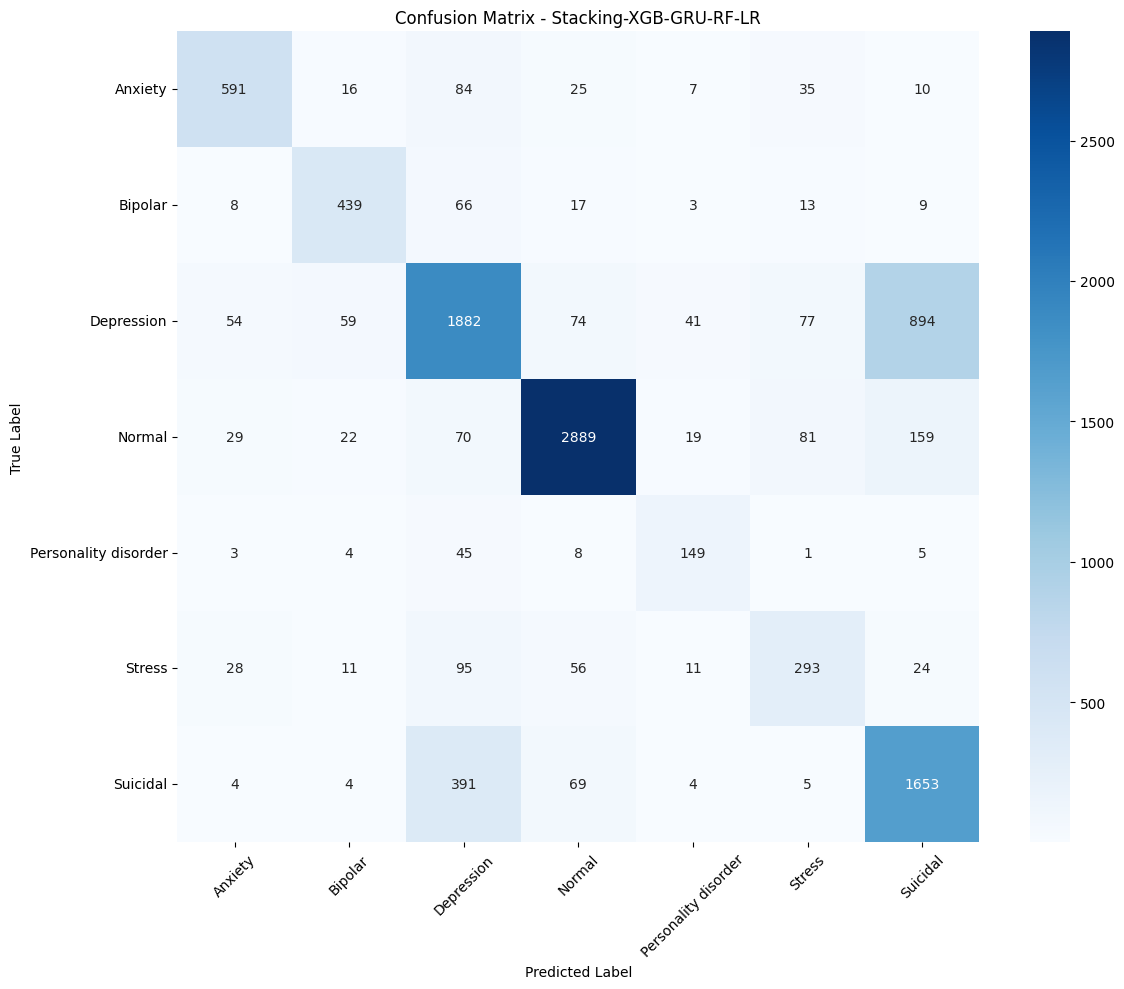


Top 10 Most Confused Pairs - Stacking-XGB-GRU-RF-LR:
------------------------------------------------------------
True Class           Predicted Class      Count     
------------------------------------------------------------
Depression           Suicidal             894       
Suicidal             Depression           391       
Normal               Suicidal             159       
Stress               Depression           95        
Anxiety              Depression           84        
Normal               Stress               81        
Depression           Stress               77        
Depression           Normal               74        
Normal               Depression           70        
Suicidal             Normal               69        

ANALYSIS 2: F1 vs SUPPORT CORRELATION

Per-Class Metrics - Stacking-XGB-GRU-RF-LR:
--------------------------------------------------------------------------------
Class                Precision  Recall     F1_Score   Support   
-----------

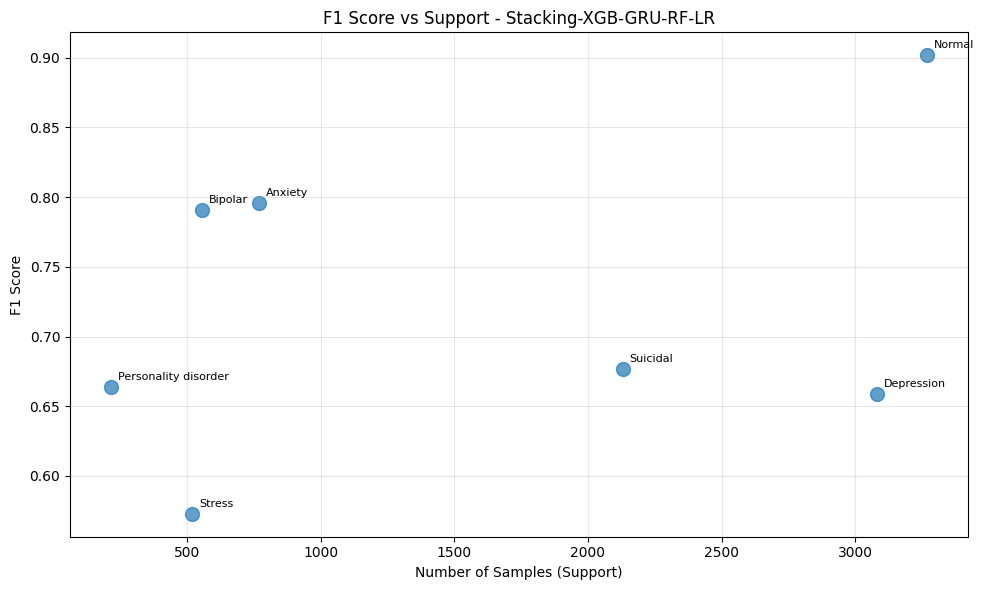


Correlation between Support and F1 Score: 0.3374

ANALYSIS 3: ROC CURVE ANALYSIS (PER-CLASS)


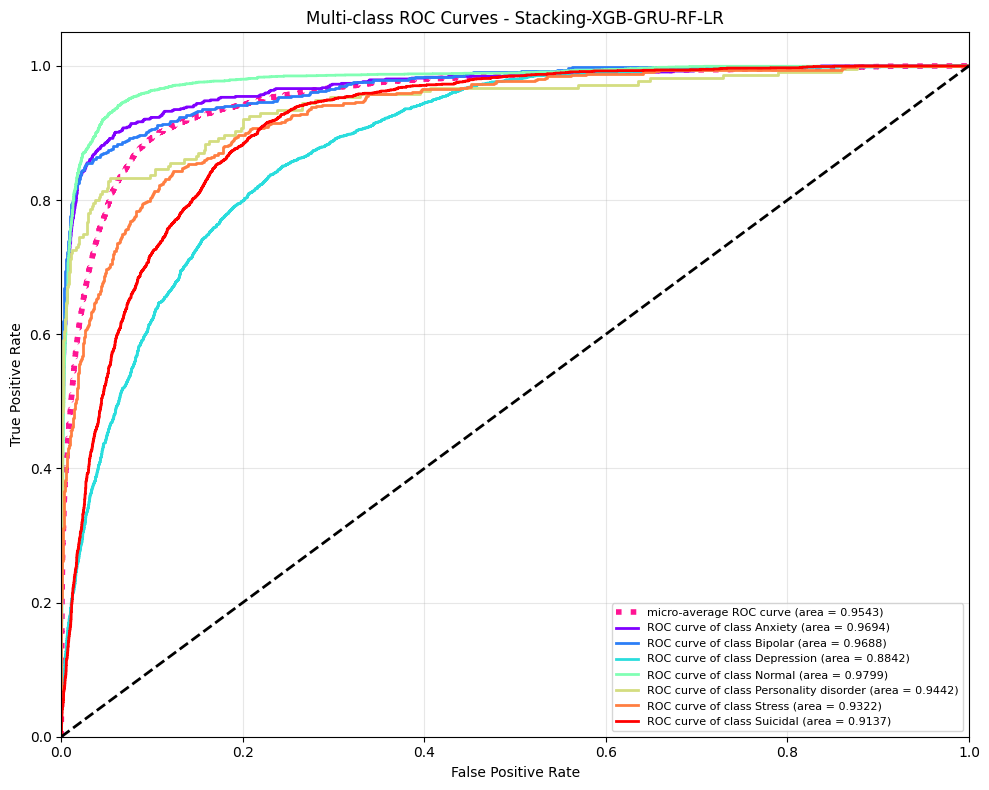


AUC Scores - Stacking-XGB-GRU-RF-LR:
--------------------------------------------------
Anxiety             : 0.9694
Bipolar             : 0.9688
Depression          : 0.8842
Normal              : 0.9799
Personality disorder: 0.9442
Stress              : 0.9322
Suicidal            : 0.9137
Micro-average       : 0.9543

ANALYSIS 4: PREDICTION SPREADSHEET

Prediction Spreadsheet Sample - Stacking-XGB-GRU-RF-LR:
----------------------------------------------------------------------------------------------------
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
# STACKING ENSEMBLES WORD2VEC with Test Set Prediction, Analysis and ROC Curves
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.base import clone
import time
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import pickle

# Load training data
X_train_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v.npy')
X_train_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_train_w2v_sequences.npy')
embedding_matrix = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/w2v_embedding_matrix.npy')
y_train = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_train.pkl')
labels = pickle.load(open("/content/drive/MyDrive/Skripsi Dataset/FinalFile/status_label_encoder.pkl",'rb'))['classes']

# Load test data
X_test_w2v = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_test_w2v.npy')
X_test_sequences = np.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_test_w2v_sequences.npy')
y_test = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/y_test.pkl')

# Load text data for analysis
X_test_text = joblib.load('/content/drive/MyDrive/Skripsi Dataset/FinalFile/X_test_statement.pkl')

# Get GRU dimensions
vocab_size, embedding_dim = embedding_matrix.shape
max_sequence_length = X_train_sequences.shape[1]
num_classes = len(np.unique(y_train))

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
all_results = []
test_predictions = {}

stacking_ensembles = {
    'Stacking-XGB-GRU-RF-LR': {
        'base_models': ['XGBoost', 'GRU', 'RandomForest'],
        'meta_model': LogisticRegression(random_state=42)
    }
}

# STACKING ENSEMBLES LOOP
for ensemble_name, ensemble_config in stacking_ensembles.items():
    base_model_names = ensemble_config['base_models']
    meta_model = ensemble_config['meta_model']

    print(f"\n{'='*60}")
    print(f"Training {ensemble_name}")
    print(f"Base Models: {base_model_names}")
    print(f"Meta Model: {type(meta_model).__name__}")
    print(f"{'='*60}")

    model_start_time = time.time()

    print("Stage 1: Generating Out-of-Fold predictions...")

    # Initialize OOF arrays for base model predictions
    oof_predictions = {}
    for model_name in base_model_names:
        oof_predictions[model_name] = np.zeros((len(X_train_w2v), num_classes))

    # Generate OOF predictions for each base model
    for train_idx, val_idx in skf.split(X_train_w2v, y_train):
        X_tr_ft = X_train_w2v[train_idx]
        X_val_ft = X_train_w2v[val_idx]
        X_tr_seq = X_train_sequences[train_idx]
        X_val_seq = X_train_sequences[val_idx]
        y_tr = y_train[train_idx]
        y_val = y_train[val_idx]

         # SINGLE RESAMPLE PIPE
        resample_pipe = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])

        X_tr_ft_hybrid, y_tr_hybrid = resample_pipe.fit_resample(X_tr_ft, y_tr)
        X_tr_seq_hybrid, y_tr_seq_hybrid = resample_pipe.fit_resample(X_tr_seq, y_tr)

        # Train each base model and get OOF predictions
        for model_name in base_model_names:
            if model_name == 'GRU':
                # GRU Model
                y_tr_cat = tf.keras.utils.to_categorical(y_tr_seq_hybrid, num_classes)
                y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)

                gru_model = Sequential([
                    Embedding(
                        input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_sequence_length,
                        trainable=False
                    ),
                    GRU(64),
                    Dense(num_classes, activation='softmax')
                ])

                gru_model.compile(
                    optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                gru_model.fit(
                    X_tr_seq_hybrid, y_tr_cat,
                    validation_data=(X_val_seq, y_val_cat),
                    epochs=50,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
                    verbose=0,
                )

                y_proba_gru = gru_model.predict(X_val_seq, verbose=0)
                oof_predictions['GRU'][val_idx] = y_proba_gru

            else:
                # ML Models
                if model_name == 'XGBoost':
                    model = XGBClassifier(random_state=42)
                elif model_name == 'RandomForest':
                    model = RandomForestClassifier(random_state=42)

                model.fit(X_tr_ft_hybrid, y_tr_hybrid)

                y_proba_ml = model.predict_proba(X_val_ft)
                oof_predictions[model_name][val_idx] = y_proba_ml

    print("Stage 1 completed: OOF predictions generated for all base models")
    print("Stage 2: Training and evaluating meta-classifier...")

    # Create meta-features dataset from OOF predictions
    X_meta_train = np.hstack([oof_predictions[model_name] for model_name in base_model_names])
    y_meta_train = y_train

    # Metrics containers for stacking ensemble
    p_macros=[]; r_macros=[]; f1_macros=[]
    p_weights=[]; r_weights=[]; f1_weights=[]
    hF1s=[]; hPs=[]; hRs=[]
    all_y_true = []; all_y_pred = []

    fold_idx = 0
    # Cross-validation on meta-features
    for train_idx, val_idx in skf.split(X_meta_train, y_meta_train):
        fold_idx += 1

        # Get meta-features splits
        X_tr_meta = X_meta_train[train_idx]
        X_val_meta = X_meta_train[val_idx]
        y_tr = y_meta_train[train_idx]
        y_val = y_meta_train[val_idx]

        resample_pipe_meta = ImbPipeline([
            ('ros', RandomOverSampler(random_state=42)),
            ('rus', RandomUnderSampler(random_state=42))
        ])
        X_tr_meta_hybrid, y_tr_hybrid = resample_pipe_meta.fit_resample(X_tr_meta, y_tr)

        # Train meta-classifier
        meta_model_clone = clone(meta_model)
        meta_model_clone.fit(X_tr_meta_hybrid, y_tr_hybrid)

        y_pred = meta_model_clone.predict(X_val_meta)

        # Calculate metrics
        p_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
        r_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
        f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
        p_weighted = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        r_weighted = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        hF1, hP, hR, _, _, _ = hierarchical_metrics_journal(y_val, y_pred, labels, ancestor_sets)

        # Store fold results
        p_macros.append(p_macro)
        r_macros.append(r_macro)
        f1_macros.append(f1_macro)
        p_weights.append(p_weighted)
        r_weights.append(r_weighted)
        f1_weights.append(f1_weighted)
        hF1s.append(hF1)
        hPs.append(hP)
        hRs.append(hR)

        all_y_true.extend(list(y_val))
        all_y_pred.extend(list(y_pred))

        # Save individual fold result
        all_results.append({
            'Model': f'Flat-w2v-{ensemble_name}-skipgram',
            'Fold': f'Fold_{fold_idx}',
            'Macro_Precision': p_macro,
            'Macro_Recall': r_macro,
            'Macro_F1': f1_macro,
            'Weighted_Precision': p_weighted,
            'Weighted_Recall': r_weighted,
            'Weighted_F1': f1_weighted,
            'Hierarchical_Precision': hP,
            'Hierarchical_Recall': hR,
            'Hierarchical_F1': hF1,
            'Type': 'Fold',
            'Time': ''
        })

        print(f"Fold {fold_idx} done. MacroF1={f1_macro:.4f}, WeightedF1={f1_weighted:.4f}, HierF1={hF1:.4f}")

    model_total_time = time.time() - model_start_time

    print(f"\nTraining final stacking model for test set prediction...")
    print("Training base models on full training data...")
    base_models_full = {}

    resample_pipe_full = ImbPipeline([
        ('ros', RandomOverSampler(random_state=42)),
        ('rus', RandomUnderSampler(random_state=42))
    ])

    X_train_ft_full, y_train_full = resample_pipe_full.fit_resample(X_train_w2v, y_train)
    X_train_seq_full, _ = resample_pipe_full.fit_resample(X_train_sequences, y_train)

    for model_name in base_model_names:
        if model_name == 'GRU':
            # GRU Model
            y_train_cat = tf.keras.utils.to_categorical(y_train_full, num_classes)

            gru_model_full = Sequential([
                Embedding(
                    input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False
                ),
                GRU(64),
                Dense(num_classes, activation='softmax')
            ])

            gru_model_full.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            gru_model_full.fit(
                X_train_seq_full, y_train_cat,
                epochs=50,
                batch_size=32,
                callbacks=[EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)],
                verbose=0,
            )
            base_models_full['GRU'] = gru_model_full

        else:
            # ML Models
            if model_name == 'XGBoost':
                model_full = XGBClassifier(random_state=42)
            elif model_name == 'RandomForest':
                model_full = RandomForestClassifier(random_state=42)

            model_full.fit(X_train_ft_full, y_train_full)
            base_models_full[model_name] = model_full

    # Generate test predictions from base models
    print("Generating test predictions from base models...")
    meta_features_test = []
    for model_name in base_model_names:
        if model_name == 'GRU':
            y_proba_test = base_models_full['GRU'].predict(X_test_sequences, verbose=0)
        else:
            y_proba_test = base_models_full[model_name].predict_proba(X_test_w2v)
        meta_features_test.append(y_proba_test)

    X_meta_test = np.hstack(meta_features_test)

    # Train final meta-classifier on ALL OOF meta-features
    X_meta_full_hybrid, y_meta_full_hybrid = resample_pipe_full.fit_resample(X_meta_train, y_meta_train)
    final_meta_model = clone(meta_model)
    final_meta_model.fit(X_meta_full_hybrid, y_meta_full_hybrid)

    # Final prediction on test set
    y_test_pred = final_meta_model.predict(X_meta_test)
    y_test_proba = final_meta_model.predict_proba(X_meta_test)

    # Store test predictions for analysis
    test_predictions[ensemble_name] = {
        'true': y_test,
        'pred': y_test_pred,
        'proba': y_test_proba,
        'meta_features': X_meta_test
    }

    # Calculate and save final average
    all_results.append({
        'Model': f'Flat-w2v-{ensemble_name}-skipgram',
        'Fold': 'Mean',
        'Macro_Precision': np.mean(p_macros),
        'Macro_Recall': np.mean(r_macros),
        'Macro_F1': np.mean(f1_macros),
        'Weighted_Precision': np.mean(p_weights),
        'Weighted_Recall': np.mean(r_weights),
        'Weighted_F1': np.mean(f1_weights),
        'Hierarchical_Precision': np.mean(hPs),
        'Hierarchical_Recall': np.mean(hRs),
        'Hierarchical_F1': np.mean(hF1s),
        'Type': 'Mean',
        'Time': model_total_time
    })

    all_results.append({
        'Model': f'Flat-w2v-{ensemble_name}-skipgram',
        'Fold': 'Std',
        'Macro_Precision': np.std(p_macros),
        'Macro_Recall': np.std(r_macros),
        'Macro_F1': np.std(f1_macros),
        'Weighted_Precision': np.std(p_weights),
        'Weighted_Recall': np.std(r_weights),
        'Weighted_F1': np.std(f1_weights),
        'Hierarchical_Precision': np.std(hPs),
        'Hierarchical_Recall': np.std(hRs),
        'Hierarchical_F1': np.std(hF1s),
        'Type': 'Std',
        'Time': ''
    })

    print(f"\n{ensemble_name} Final Results:")
    print(f"Macro F1: {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
    print(f"Weighted F1: {np.mean(f1_weights):.4f} ± {np.std(f1_weights):.4f}")
    print(f"Hierarchical F1: {np.mean(hF1s):.4f} ± {np.std(hF1s):.4f}")
    print(f"Total Training Time: {model_total_time:.2f} seconds")
    print(f"Base Models: {base_model_names}")
    print(f"Meta Model: {type(meta_model).__name__}")

# =============================================================================
# ANALYSIS 1: CONFUSION PAIR ANALYSIS
# =============================================================================
print(f"\n{'='*80}")
print("ANALYSIS 1: CONFUSION PAIR ANALYSIS")
print(f"{'='*80}")

for ensemble_name, predictions in test_predictions.items():
    y_true = predictions['true']
    y_pred = predictions['pred']

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {ensemble_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Find top 10 most confused pairs
    confused_pairs = []
    n_classes = len(labels)

    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and cm[i, j] > 0:
                true_class = labels[i]
                pred_class = labels[j]
                count = cm[i, j]
                confused_pairs.append((true_class, pred_class, count))

    # Sort by count in descending order and get top 10
    confused_pairs.sort(key=lambda x: x[2], reverse=True)
    top_confused = confused_pairs[:10]

    print(f"\nTop 10 Most Confused Pairs - {ensemble_name}:")
    print("-" * 60)
    print(f"{'True Class':<20} {'Predicted Class':<20} {'Count':<10}")
    print("-" * 60)
    for true_class, pred_class, count in top_confused:
        print(f"{true_class:<20} {pred_class:<20} {count:<10}")

    # Save confused pairs to CSV
    confused_df = pd.DataFrame(top_confused, columns=['True_Class', 'Predicted_Class', 'Count'])
    confused_df.to_csv(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/{ensemble_name}_confused_pairs.csv', index=False)

# ANALYSIS 2: F1 vs SUPPORT CORRELATION
print(f"\n{'='*80}")
print("ANALYSIS 2: F1 vs SUPPORT CORRELATION")
print(f"{'='*80}")

for ensemble_name, predictions in test_predictions.items():
    y_true = predictions['true']
    y_pred = predictions['pred']

    # Calculate per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_true, y_pred, labels=range(len(labels)), zero_division=0
    )

    # Create DataFrame for per-class metrics
    class_metrics = pd.DataFrame({
        'Class': labels,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1_Score': f1_per_class,
        'Support': support_per_class
    })

    print(f"\nPer-Class Metrics - {ensemble_name}:")
    print("-" * 80)
    print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1_Score':<10} {'Support':<10}")
    print("-" * 80)
    for _, row in class_metrics.iterrows():
        print(f"{row['Class']:<20} {row['Precision']:.4f}    {row['Recall']:.4f}    {row['F1_Score']:.4f}    {row['Support']:<10}")

    # Create scatter plot: F1 Score vs Support
    plt.figure(figsize=(10, 6))
    plt.scatter(class_metrics['Support'], class_metrics['F1_Score'], alpha=0.7, s=100)

    # Add class labels to points
    for i, row in class_metrics.iterrows():
        plt.annotate(row['Class'],
                    (row['Support'], row['F1_Score']),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8)

    plt.xlabel('Number of Samples (Support)')
    plt.ylabel('F1 Score')
    plt.title(f'F1 Score vs Support - {ensemble_name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Calculate correlation
    correlation = np.corrcoef(class_metrics['Support'], class_metrics['F1_Score'])[0, 1]
    print(f"\nCorrelation between Support and F1 Score: {correlation:.4f}")

    # Save per-class metrics to CSV
    class_metrics.to_csv(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/{ensemble_name}_per_class_metrics.csv', index=False)

# ANALYSIS 3: ROC CURVE ANALYSIS (PER-CLASS)
print(f"\n{'='*80}")
print("ANALYSIS 3: ROC CURVE ANALYSIS (PER-CLASS)")
print(f"{'='*80}")

for ensemble_name, predictions in test_predictions.items():
    y_true = predictions['true']
    y_proba = predictions['proba']

    # Binarize the output for ROC curve calculation
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    # Calculate ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculate micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.4f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot ROC curves for each class
    colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:0.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-class ROC Curves - {ensemble_name}')
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print AUC values for each class
    print(f"\nAUC Scores - {ensemble_name}:")
    print("-" * 50)
    for i in range(num_classes):
        print(f"{labels[i]:<20}: {roc_auc[i]:.4f}")
    print(f"{'Micro-average':<20}: {roc_auc['micro']:.4f}")

    # Save ROC data to CSV
    roc_data = []
    for i in range(num_classes):
        for j in range(len(fpr[i])):
            roc_data.append({
                'Class': labels[i],
                'False_Positive_Rate': fpr[i][j],
                'True_Positive_Rate': tpr[i][j],
                'AUC': roc_auc[i]
            })

    roc_df = pd.DataFrame(roc_data)
    roc_df.to_csv(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/{ensemble_name}_roc_data.csv', index=False)

# ANALYSIS 4: GENERATE SPREADSHEET WITH PREDICTIONS
print(f"\n{'='*80}")
print("ANALYSIS 4: PREDICTION SPREADSHEET")
print(f"{'='*80}")

for ensemble_name, predictions in test_predictions.items():
    y_true = predictions['true']
    y_pred = predictions['pred']
    y_proba = predictions['proba']

    # Create spreadsheet with text, true labels, and predicted labels
    results_df = pd.DataFrame({
        'Text_Input': X_test_text,
        'True_Label': [labels[i] for i in y_true],
        'Predicted_Label': [labels[i] for i in y_pred]
    })

    # Add confidence scores for each prediction
    confidence_scores = np.max(y_proba, axis=1)
    results_df['Confidence_Score'] = confidence_scores

    # Add predicted probability for each class
    for i, class_name in enumerate(labels):
        results_df[f'Prob_{class_name}'] = y_proba[:, i]

    # whether prediction was correct
    results_df['Correct_Prediction'] = (y_true == y_pred)

    print(f"\nPrediction Spreadsheet Sample - {ensemble_name}:")
    print("-" * 100)
    print(results_df.head(10).to_string(index=False))

    # Save to CSV
    results_df.to_csv(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/{ensemble_name}_predictions.csv', index=False)
    print(f"\nFull prediction spreadsheet saved: {ensemble_name}_predictions.csv")

    # Summary statistics
    accuracy = (y_true == y_pred).mean()
    print(f"\nTest Set Performance - {ensemble_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Total Samples: {len(y_true)}")
    print(f"Correct Predictions: {(y_true == y_pred).sum()}")
    print(f"Incorrect Predictions: {(y_true != y_pred).sum()}")

# ANALYSIS 5: DETAILED CLASSIFICATION REPORT
print(f"\n{'='*80}")
print("ANALYSIS 5: DETAILED CLASSIFICATION REPORT")
print(f"{'='*80}")

for ensemble_name, predictions in test_predictions.items():
    y_true = predictions['true']
    y_pred = predictions['pred']

    print(f"\nDetailed Classification Report - {ensemble_name}:")
    print("-" * 60)

    # Get detailed classification report as dictionary
    report = classification_report(y_true, y_pred,
                                 target_names=labels,
                                 output_dict=True,
                                 zero_division=0)

    # Convert to DataFrame for better display
    report_df = pd.DataFrame(report).transpose()
    print(report_df.round(4))

    # Save detailed report
    report_df.to_csv(f'/content/drive/MyDrive/Skripsi Dataset/FinalFile/{ensemble_name}_detailed_report.csv')

print(f"\n{'='*80}")
print("ALL ANALYSES COMPLETED!")
print(f"Saved files:")
print("- Confused pairs analysis")
print("- Per-class metrics with F1 vs Support correlation")
print("- ROC curves with per-class AUC scores")
print("- Prediction spreadsheet with text, true labels, and predicted labels")
print("- Detailed classification reports")
print(f"{'='*80}")

# Create final results summary
final_results_df = pd.DataFrame(all_results)
final_results_df.to_csv('/content/drive/MyDrive/Skripsi Dataset/FinalFile/stacking_ensemble_results.csv', index=False)
print(f"\nFinal results summary saved: stacking_ensemble_results.csv")

# Statistical Test

In [ ]:
file_path = "/content/drive/MyDrive/Skripsi Dataset/FinalFile/final_model_fold_results_2.xlsx"

# Load the data
try:
    df = pd.read_excel(file_path, sheet_name='Sheet1')
    print("Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst few rows:")
    display(df.head())
except Exception as e:
    print(f"Error loading file: {e}")
    print("Please update the file_path variable with the correct path to your file.")

In [ ]:
# Data Preprocessing and Filtering
# Filter only Fold rows (remove Mean and Std rows)
fold_data = df[df['Type'] == 'Fold'].copy()

# Extract unique models
models = fold_data['Model'].unique()
print(f"Found {len(models)} unique models:")
for i, model in enumerate(models, 1):
    print(f"{i}. {model}")

# Create a pivot table for analysis
metric = 'Weighted_F1'

pivot_data = fold_data.pivot_table(
    index='Fold',
    columns='Model',
    values=metric
)

print(f"\nPivot table shape: {pivot_data.shape}")
print(f"\nUsing metric: {metric}")
display(pivot_data.head())

In [ ]:
# Calculate descriptive statistics for each model
print("Descriptive Statistics for Each Model:")
stats_summary = pivot_data.describe()
display(stats_summary)

# Visualize the performance distribution
plt.figure(figsize=(14, 8))
sns.boxplot(data=pivot_data)
plt.title(f'Performance Distribution ({metric}) by Model')
plt.xticks(rotation=45, ha='right')
plt.ylabel(metric)
plt.tight_layout()
plt.show()

# Line plot to see trends across folds
plt.figure(figsize=(14, 8))
for model in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[model], marker='o', label=model, linewidth=2)
plt.title(f'Performance Across Folds ({metric})')
plt.xlabel('Fold')
plt.ylabel(metric)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Friedman test
friedman_data = pivot_data.values.T

print("Friedman Test Results:")
print("=" * 50)

stat, p_value = friedmanchisquare(*friedman_data)

print(f"Friedman Test Statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print(f"\nResult: Significant differences exist among models (p < {alpha})")
    print("Proceeding with post-hoc analysis...")
else:
    print(f"\nResult: No significant differences among models (p ≥ {alpha})")
    print("Post-hoc analysis may not be necessary.")

# Degrees of freedom
k = len(models)
df = k - 1
print(f"\nDegrees of freedom: {df}")

In [ ]:
# Post-hoc Nemenyi Test
if p_value < alpha:
    print("Performing Nemenyi Post-hoc Test...")
    print("=" * 50)

    nemenyi_results = sp.posthoc_nemenyi_friedman(friedman_data.T)

    # Set model names as index and columns
    nemenyi_results.index = pivot_data.columns
    nemenyi_results.columns = pivot_data.columns

    print("Nemenyi Test P-value Matrix:")
    display(nemenyi_results)

    # Create a heatmap of p-values
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(nemenyi_results, dtype=bool))
    sns.heatmap(nemenyi_results,
                annot=True,
                fmt=".4f",
                cmap='coolwarm',
                center=0.05,
                cbar_kws={'label': 'P-value'},
                mask=mask,
                square=True)
    plt.title('Nemenyi Post-hoc Test P-values\n(Lower triangle)')
    plt.tight_layout()
    plt.show()

else:
    print("Skipping Nemenyi test due to non-significant Friedman test result.")

In [ ]:
#Critical Difference Diagram
if p_value < alpha:
    print("Generating Critical Difference Diagram...")

    # Calculate average ranks for each model
    ranks = pivot_data.rank(axis=1, ascending=False)
    average_ranks = ranks.mean(axis=0).sort_values()

    print("\nAverage Ranks (1 = best):")
    for model, rank in average_ranks.items():
        print(f"{model}: {rank:.2f}")

    plt.figure(figsize=(14, 6))

    # Calculate critical difference
    k = len(models)
    N = len(pivot_data)
    q_alpha = 2.569

    CD = q_alpha * np.sqrt(k * (k + 1) / (6 * N))

    print(f"\nCritical Difference (CD): {CD:.3f}")
    print("Models connected by a line are not significantly different")

    # Plot ranks
    plt.scatter(average_ranks.values, [1] * len(average_ranks), s=100, color='blue', zorder=3)

    # Add model names
    for i, (model, rank) in enumerate(average_ranks.items()):
        plt.text(rank, 1.1, model, ha='center', va='bottom', fontsize=9, rotation=45)

    plt.axhline(y=1, color='gray', linestyle='-', alpha=0.3)

    # Identify groups of non-significantly different models
    groups = []
    current_group = [average_ranks.index[0]]

    for i in range(1, len(average_ranks)):
        if average_ranks.iloc[i] - average_ranks.iloc[0] <= CD:
            current_group.append(average_ranks.index[i])
        else:
            groups.append(current_group)
            current_group = [average_ranks.index[i]]
    groups.append(current_group)

    # Print
    print("\nGroups of non-significantly different models:")
    for i, group in enumerate(groups):
        print(f"Group {i+1}: {', '.join(group)}")

    plt.xlim(0.5, len(models) + 0.5)
    plt.ylim(0.5, 1.5)
    plt.xlabel('Average Rank')
    plt.title(f'Critical Difference Diagram (CD = {CD:.3f})')
    plt.yticks([])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
#Save result to drive
results_dir = "/content/drive/MyDrive/Skripsi Dataset/Statistical_Analysis_Results"
os.makedirs(results_dir, exist_ok=True)

print("Saving results to Google Drive...")

stats_summary.to_csv(f"{results_dir}/descriptive_statistics.csv")

# Save Friedman test results
friedman_results = pd.DataFrame({
    'Friedman_Statistic': [stat],
    'P_value': [p_value],
    'Significant': [p_value < 0.05]
})
friedman_results.to_csv(f"{results_dir}/friedman_test_results.csv", index=False)

if p_value < 0.05:
    # Save Nemenyi results
    nemenyi_results.to_csv(f"{results_dir}/nemenyi_test_results.csv")

    # Save ranks
    average_ranks.to_csv(f"{results_dir}/average_ranks.csv", header=['Average_Rank'])

# Create comprehensive report
report = f"""
STATISTICAL ANALYSIS REPORT
Generated on: {pd.Timestamp.now()}

DATASET INFORMATION:
- Number of models: {len(models)}
- Number of folds: {len(pivot_data)}
- Primary metric: {metric}

FRIEDMAN TEST RESULTS:
- Test Statistic: {stat:.4f}
- P-value: {p_value:.4f}
- Significant: {'Yes' if p_value < 0.05 else 'No'}

TOP PERFORMING MODELS:
"""

if p_value < 0.05:
    ranks = pivot_data.rank(axis=1, ascending=False)
    avg_ranks = ranks.mean(axis=0).sort_values()
    for i, (model, rank) in enumerate(avg_ranks.head(3).items()):
        report += f"{i+1}. {model} (Avg Rank: {rank:.2f})\n"
else:
    report += "No significant differences found among models.\n"

# Save report
with open(f"{results_dir}/analysis_report.txt", "w") as f:
    f.write(report)

print(f"All results saved to: {results_dir}")
print("Files created:")
!ls -la "{results_dir}"